# Machine Learning Techniques - ISIS4219

Segundo Semestre - 2021

## Integrantes

*   Daniel Mateo Guatibonza Solano - 201611360
*   Raquel Andrea Cerda Montañez - 201533520
*   Sergio Eduardo Cárdenas Landazabal - 201613444

## **Problema 2**

Para los bancos es sumamente importante reconocer transacciones fraudulentas con el objetivo de que los clientes no paguen por cosas que no compraron. Con respecto a lo anterior, se recogieron datos de más de 200 mil transacciones con un porcentaje de 0.172% de transacciones fraudulentas. Dada la baja cantidad de fraudes, se le pidió a ud que creara un modelo de inteligencia artificial para poder detectar este tipo de anomalías.

**Fuente de Datos**: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [66]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import seaborn as sns; sns.set()
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, f1_score, make_scorer

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras import applications

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.0-dev20211020


In [2]:
data_df = pd.read_csv('creditcard.csv')
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data_df = data_df.drop(['Time'], axis=1)
X_data = data_df.drop(['Class'], axis=1)
y_data = data_df['Class'].to_frame()
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, stratify=y_data, test_size=0.2, random_state=0)

In [4]:
# Datos de entrenamiento conjuntos para separar de acuerdo a la clase
train_data = pd.concat([X_train, y_train], axis=1)
# Asignación de los datos de la clase 1 para validación
val_1 = train_data[train_data['Class']==1]
# Datos de entrenamiento como los datos de la clase 0
train_0 = train_data[train_data['Class']==0]
X_train_0 = train_0.drop(['Class'], axis=1)
y_train_0 = train_0['Class'].to_frame()
# Partición de entrenamiento y validación para la clase 0
X_train, X_val_0, y_train, y_val_0 = train_test_split(X_train_0, y_train_0, test_size=val_1.shape[0], random_state=0)
# Concatenación de datos de validación de ambas clases
val_0 = pd.concat([X_val_0, y_val_0], axis=1)
val_data = pd.concat([val_0, val_1])
X_val = val_data.drop(['Class'], axis=1)
y_val = val_data['Class'].to_frame()

In [5]:
autoencoder = Sequential(name="Autoencoder")
autoencoder.add(Dense(20, activation='relu', input_shape=(29,)))
autoencoder.add(Activation('relu'))
autoencoder.add(Dense(10))
autoencoder.add(Activation('relu'))
autoencoder.add(Dense(10))
autoencoder.add(Activation('relu'))
autoencoder.add(Dense(20))
autoencoder.add(Activation('relu'))
autoencoder.add(Dense(29))
autoencoder.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                600       
                                                                 
 activation (Activation)     (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                

In [6]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

In [7]:
autoencoder.fit(X_train, X_train, 
                epochs=1000, batch_size=500, callbacks=callbacks)

Epoch 1/1000
455/455 [==============================] - 1s 1ms/step - loss: 435.8136
Epoch 2/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.8582
Epoch 3/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.8090
Epoch 4/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.7464
Epoch 5/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.7239
Epoch 6/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.7504
Epoch 7/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.6848
Epoch 8/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.8758
Epoch 9/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.6834
Epoch 10/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.6678
Epoch 11/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.6301
Epoch 12/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.8277

In [8]:
def crear_autoencoder(nn1 = 20, nn2 = 10, nn3 = 5, n_layers= 3, activacion_oculta = 'relu'):
    autoencoder = Sequential(name="Autoencoder")
    nn = [nn1, nn2, nn3]
    for i in range(n_layers):
        autoencoder.add(Dense(nn[i]))
        autoencoder.add(Activation(activacion_oculta))
    for i in range(n_layers-1, -1, -1):
        autoencoder.add(Dense(nn[i]))
        autoencoder.add(Activation(activacion_oculta))
    output = 29
    autoencoder.add(Dense(output, name= 'Capa_Salida'))
    autoencoder.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return autoencoder

# Modelo que utiliza el GridSearch
autoencoder_CV = KerasClassifier(build_fn=crear_autoencoder, epochs=1000, verbose=1, shuffle=True)

In [9]:
pipe = Pipeline([('autoencoder', autoencoder_CV)])

param_grid = dict(autoencoder__nn1 = [20, 18, 16],
                  autoencoder__nn2 = [14, 12, 10],
                  autoencoder__nn3 = [8, 6, 4],
                  autoencoder__n_layers = [1, 2, 3],
                  autoencoder__activacion_oculta = ['relu','sigmoid'])

score = make_scorer(mean_squared_error, greater_is_better=False)
grid = RandomizedSearchCV(pipe, param_grid, scoring=score, verbose=2, cv=3, n_iter=25, random_state=0)

In [10]:
grid.fit(X_train, X_train, autoencoder__batch_size=500, autoencoder__callbacks=callbacks)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Epoch 1/1000
303/303 [==============================] - 1s 1ms/step - loss: 742.4572
Epoch 2/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.9430
Epoch 3/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.9377
Epoch 4/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.8202
Epoch 5/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7891
Epoch 6/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.9849
Epoch 7/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7464
Epoch 8/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7705
Epoch 9/1000
303/303 [==============================] - 0s 1ms/step - loss: 1.1354
Epoch 10/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7713
Epoch 00010: early stopping
[CV] END autoencoder__activacion_oculta=relu, autoencoder__n_layers=3, autoenc

303/303 [==============================] - 0s 1ms/step - loss: 1757.9999
Epoch 50/1000
303/303 [==============================] - 0s 1ms/step - loss: 1747.5160
Epoch 51/1000
303/303 [==============================] - 0s 1ms/step - loss: 1737.1688
Epoch 52/1000
303/303 [==============================] - 0s 1ms/step - loss: 1726.9412
Epoch 53/1000
303/303 [==============================] - 0s 1ms/step - loss: 1716.8363
Epoch 54/1000
303/303 [==============================] - 0s 1ms/step - loss: 1706.8848
Epoch 55/1000
303/303 [==============================] - 0s 1ms/step - loss: 1697.0653
Epoch 56/1000
303/303 [==============================] - 0s 1ms/step - loss: 1687.3452
Epoch 57/1000
303/303 [==============================] - 0s 1ms/step - loss: 1677.7732
Epoch 58/1000
303/303 [==============================] - 0s 1ms/step - loss: 1668.3348
Epoch 59/1000
303/303 [==============================] - 0s 1ms/step - loss: 1658.9727: 0s - loss: 1
Epoch 60/1000
303/303 [====================

303/303 [==============================] - 0s 1ms/step - loss: 1148.5529
Epoch 143/1000
303/303 [==============================] - 0s 1ms/step - loss: 1144.4952
Epoch 144/1000
303/303 [==============================] - 0s 1ms/step - loss: 1140.4884
Epoch 145/1000
303/303 [==============================] - 0s 1ms/step - loss: 1136.5198
Epoch 146/1000
303/303 [==============================] - 0s 1ms/step - loss: 1132.5824
Epoch 147/1000
303/303 [==============================] - 0s 1ms/step - loss: 1128.5857
Epoch 148/1000
303/303 [==============================] - 0s 1ms/step - loss: 1124.6289
Epoch 149/1000
303/303 [==============================] - 0s 1ms/step - loss: 1120.7732
Epoch 150/1000
303/303 [==============================] - 0s 1ms/step - loss: 1116.9075
Epoch 151/1000
303/303 [==============================] - 0s 1ms/step - loss: 1113.0448
Epoch 152/1000
303/303 [==============================] - 0s 1ms/step - loss: 1109.2765
Epoch 153/1000
303/303 [=======================

303/303 [==============================] - 0s 1ms/step - loss: 867.7754
Epoch 236/1000
303/303 [==============================] - 0s 1ms/step - loss: 865.6314
Epoch 237/1000
303/303 [==============================] - 0s 1ms/step - loss: 863.6179
Epoch 238/1000
303/303 [==============================] - 0s 1ms/step - loss: 861.0298
Epoch 239/1000
303/303 [==============================] - 0s 1ms/step - loss: 858.9627
Epoch 240/1000
303/303 [==============================] - 0s 1ms/step - loss: 856.6353
Epoch 241/1000
303/303 [==============================] - 0s 1ms/step - loss: 854.5659
Epoch 242/1000
303/303 [==============================] - 0s 1ms/step - loss: 852.5449
Epoch 243/1000
303/303 [==============================] - 0s 1ms/step - loss: 850.2505
Epoch 244/1000
303/303 [==============================] - 0s 1ms/step - loss: 848.0662
Epoch 245/1000
303/303 [==============================] - 0s 1ms/step - loss: 846.0047
Epoch 246/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 700.3456
Epoch 330/1000
303/303 [==============================] - 0s 1ms/step - loss: 698.5628
Epoch 331/1000
303/303 [==============================] - 0s 1ms/step - loss: 698.6257
Epoch 332/1000
303/303 [==============================] - 0s 1ms/step - loss: 695.7675
Epoch 333/1000
303/303 [==============================] - 0s 1ms/step - loss: 694.2602
Epoch 334/1000
303/303 [==============================] - 0s 1ms/step - loss: 692.9037
Epoch 335/1000
303/303 [==============================] - 0s 1ms/step - loss: 691.7429
Epoch 336/1000
303/303 [==============================] - 0s 1ms/step - loss: 690.4902
Epoch 337/1000
303/303 [==============================] - 0s 1ms/step - loss: 689.7086
Epoch 338/1000
303/303 [==============================] - 0s 1ms/step - loss: 687.5079
Epoch 339/1000
303/303 [==============================] - 0s 1ms/step - loss: 686.1991
Epoch 340/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 589.7916
Epoch 424/1000
303/303 [==============================] - 0s 1ms/step - loss: 588.6429
Epoch 425/1000
303/303 [==============================] - 0s 1ms/step - loss: 588.1388
Epoch 426/1000
303/303 [==============================] - 0s 1ms/step - loss: 587.0193
Epoch 427/1000
303/303 [==============================] - 0s 1ms/step - loss: 586.2219
Epoch 428/1000
303/303 [==============================] - 0s 1ms/step - loss: 594.5742
Epoch 429/1000
303/303 [==============================] - 0s 1ms/step - loss: 584.5113
Epoch 430/1000
303/303 [==============================] - 0s 1ms/step - loss: 583.2177
Epoch 431/1000
303/303 [==============================] - 0s 1ms/step - loss: 582.6894
Epoch 432/1000
303/303 [==============================] - 0s 1ms/step - loss: 581.1549
Epoch 433/1000
303/303 [==============================] - 0s 1ms/step - loss: 580.0725
Epoch 434/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 516.6192
Epoch 518/1000
303/303 [==============================] - 0s 1ms/step - loss: 510.8583
Epoch 519/1000
303/303 [==============================] - 0s 1ms/step - loss: 509.9366
Epoch 520/1000
303/303 [==============================] - 0s 1ms/step - loss: 509.1820
Epoch 521/1000
303/303 [==============================] - 0s 1ms/step - loss: 508.4434
Epoch 522/1000
303/303 [==============================] - 0s 1ms/step - loss: 510.2799
Epoch 523/1000
303/303 [==============================] - 0s 1ms/step - loss: 507.5744
Epoch 524/1000
303/303 [==============================] - 0s 1ms/step - loss: 507.9672
Epoch 525/1000
303/303 [==============================] - 0s 1ms/step - loss: 506.0622
Epoch 526/1000
303/303 [==============================] - 0s 1ms/step - loss: 506.0982
Epoch 527/1000
303/303 [==============================] - 0s 1ms/step - loss: 504.2899
Epoch 528/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1880.8381
Epoch 23/1000
303/303 [==============================] - 0s 1ms/step - loss: 1869.3673
Epoch 24/1000
303/303 [==============================] - 0s 1ms/step - loss: 1858.4520
Epoch 25/1000
303/303 [==============================] - 0s 1ms/step - loss: 1847.9763
Epoch 26/1000
303/303 [==============================] - 0s 1ms/step - loss: 1808.7792
Epoch 27/1000
303/303 [==============================] - 0s 1ms/step - loss: 1781.2034
Epoch 28/1000
303/303 [==============================] - 0s 1ms/step - loss: 1764.0575
Epoch 29/1000
303/303 [==============================] - 0s 1ms/step - loss: 1748.5444
Epoch 30/1000
303/303 [==============================] - 0s 1ms/step - loss: 1733.7054
Epoch 31/1000
303/303 [==============================] - 0s 1ms/step - loss: 1719.4001
Epoch 32/1000
303/303 [==============================] - 0s 1ms/step - loss: 1705.5394
Epoch 33/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1032.5280
Epoch 117/1000
303/303 [==============================] - 0s 1ms/step - loss: 1027.8772
Epoch 118/1000
303/303 [==============================] - 0s 1ms/step - loss: 1022.9348
Epoch 119/1000
303/303 [==============================] - 0s 1ms/step - loss: 1018.1953
Epoch 120/1000
303/303 [==============================] - 0s 1ms/step - loss: 1013.5502
Epoch 121/1000
303/303 [==============================] - 0s 1ms/step - loss: 1008.9188
Epoch 122/1000
303/303 [==============================] - 0s 1ms/step - loss: 1004.3584
Epoch 123/1000
303/303 [==============================] - 0s 1ms/step - loss: 999.7908
Epoch 124/1000
303/303 [==============================] - 0s 1ms/step - loss: 995.2678
Epoch 125/1000
303/303 [==============================] - 0s 1ms/step - loss: 990.8270
Epoch 126/1000
303/303 [==============================] - 0s 1ms/step - loss: 986.3712
Epoch 127/1000
303/303 [===========================

303/303 [==============================] - 0s 1ms/step - loss: 713.6783
Epoch 211/1000
303/303 [==============================] - 0s 1ms/step - loss: 711.0748
Epoch 212/1000
303/303 [==============================] - 0s 1ms/step - loss: 708.7718
Epoch 213/1000
303/303 [==============================] - 0s 1ms/step - loss: 706.5669
Epoch 214/1000
303/303 [==============================] - 0s 1ms/step - loss: 704.1314
Epoch 215/1000
303/303 [==============================] - 0s 1ms/step - loss: 701.7127
Epoch 216/1000
303/303 [==============================] - 0s 1ms/step - loss: 699.5254
Epoch 217/1000
303/303 [==============================] - 0s 1ms/step - loss: 697.2630
Epoch 218/1000
303/303 [==============================] - 0s 1ms/step - loss: 694.9131
Epoch 219/1000
303/303 [==============================] - 0s 1ms/step - loss: 692.5984
Epoch 220/1000
303/303 [==============================] - 0s 1ms/step - loss: 690.3090
Epoch 221/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 540.5348
Epoch 305/1000
303/303 [==============================] - 0s 1ms/step - loss: 539.0270
Epoch 306/1000
303/303 [==============================] - 0s 1ms/step - loss: 537.7855
Epoch 307/1000
303/303 [==============================] - 0s 1ms/step - loss: 536.2426
Epoch 308/1000
303/303 [==============================] - 0s 1ms/step - loss: 534.8645
Epoch 309/1000
303/303 [==============================] - 0s 1ms/step - loss: 533.7690
Epoch 310/1000
303/303 [==============================] - 0s 1ms/step - loss: 532.1411
Epoch 311/1000
303/303 [==============================] - 0s 1ms/step - loss: 530.6454
Epoch 312/1000
303/303 [==============================] - 0s 1ms/step - loss: 529.4215
Epoch 313/1000
303/303 [==============================] - 0s 1ms/step - loss: 527.9348
Epoch 314/1000
303/303 [==============================] - 0s 1ms/step - loss: 526.9014
Epoch 315/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 433.3726
Epoch 399/1000
303/303 [==============================] - 0s 1ms/step - loss: 432.5020
Epoch 400/1000
303/303 [==============================] - 0s 1ms/step - loss: 432.4787
Epoch 401/1000
303/303 [==============================] - 0s 1ms/step - loss: 430.6621
Epoch 402/1000
303/303 [==============================] - 0s 1ms/step - loss: 429.7852
Epoch 403/1000
303/303 [==============================] - 0s 1ms/step - loss: 428.9380
Epoch 404/1000
303/303 [==============================] - 0s 1ms/step - loss: 428.0927
Epoch 405/1000
303/303 [==============================] - 0s 1ms/step - loss: 428.1570
Epoch 406/1000
303/303 [==============================] - 0s 1ms/step - loss: 426.1961
Epoch 407/1000
303/303 [==============================] - 0s 1ms/step - loss: 425.2973
Epoch 408/1000
303/303 [==============================] - 0s 1ms/step - loss: 424.6956
Epoch 409/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 362.7376
Epoch 493/1000
303/303 [==============================] - 0s 1ms/step - loss: 361.4892
Epoch 494/1000
303/303 [==============================] - 0s 1ms/step - loss: 361.5963
Epoch 495/1000
303/303 [==============================] - 0s 1ms/step - loss: 360.2856
Epoch 496/1000
303/303 [==============================] - 0s 1ms/step - loss: 359.8547
Epoch 497/1000
303/303 [==============================] - 0s 1ms/step - loss: 358.9785
Epoch 498/1000
303/303 [==============================] - 0s 1ms/step - loss: 358.5099
Epoch 499/1000
303/303 [==============================] - 0s 1ms/step - loss: 358.2936
Epoch 500/1000
303/303 [==============================] - 0s 1ms/step - loss: 357.2463
Epoch 501/1000
303/303 [==============================] - 0s 1ms/step - loss: 357.0067
Epoch 502/1000
303/303 [==============================] - 0s 1ms/step - loss: 356.0252
Epoch 503/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 311.2084
Epoch 587/1000
303/303 [==============================] - 0s 1ms/step - loss: 313.3985
Epoch 588/1000
303/303 [==============================] - 0s 1ms/step - loss: 310.9369
Epoch 589/1000
303/303 [==============================] - 0s 1ms/step - loss: 310.0796
Epoch 590/1000
303/303 [==============================] - 0s 1ms/step - loss: 309.5803
Epoch 591/1000
303/303 [==============================] - 0s 1ms/step - loss: 314.2578
Epoch 592/1000
303/303 [==============================] - 0s 1ms/step - loss: 308.3766
Epoch 593/1000
303/303 [==============================] - 0s 1ms/step - loss: 307.9581
Epoch 594/1000
303/303 [==============================] - 0s 1ms/step - loss: 307.5923
Epoch 595/1000
303/303 [==============================] - 0s 1ms/step - loss: 306.9914
Epoch 596/1000
303/303 [==============================] - 0s 1ms/step - loss: 306.6546
Epoch 597/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1525.5618
Epoch 51/1000
303/303 [==============================] - 0s 1ms/step - loss: 1515.5529
Epoch 52/1000
303/303 [==============================] - 0s 1ms/step - loss: 1505.6648
Epoch 53/1000
303/303 [==============================] - 0s 1ms/step - loss: 1495.9017
Epoch 54/1000
303/303 [==============================] - 0s 1ms/step - loss: 1486.2383
Epoch 55/1000
303/303 [==============================] - 0s 1ms/step - loss: 1476.6984
Epoch 56/1000
303/303 [==============================] - 0s 1ms/step - loss: 1467.2911
Epoch 57/1000
303/303 [==============================] - 0s 1ms/step - loss: 1458.0205
Epoch 58/1000
303/303 [==============================] - 0s 1ms/step - loss: 1448.8273
Epoch 59/1000
303/303 [==============================] - 0s 1ms/step - loss: 1439.7487
Epoch 60/1000
303/303 [==============================] - 0s 1ms/step - loss: 1430.7715
Epoch 61/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 927.3654
Epoch 144/1000
303/303 [==============================] - 0s 1ms/step - loss: 923.2583
Epoch 145/1000
303/303 [==============================] - 0s 1ms/step - loss: 919.1820
Epoch 146/1000
303/303 [==============================] - 0s 1ms/step - loss: 915.1303
Epoch 147/1000
303/303 [==============================] - 0s 1ms/step - loss: 911.0806
Epoch 148/1000
303/303 [==============================] - 0s 1ms/step - loss: 907.0554
Epoch 149/1000
303/303 [==============================] - 0s 1ms/step - loss: 903.0765
Epoch 150/1000
303/303 [==============================] - 0s 1ms/step - loss: 899.1442
Epoch 151/1000
303/303 [==============================] - 0s 1ms/step - loss: 895.2863
Epoch 152/1000
303/303 [==============================] - 0s 1ms/step - loss: 891.3826
Epoch 153/1000
303/303 [==============================] - 0s 1ms/step - loss: 887.5632
Epoch 154/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 644.2435
Epoch 238/1000
303/303 [==============================] - 0s 1ms/step - loss: 642.0290
Epoch 239/1000
303/303 [==============================] - 0s 1ms/step - loss: 639.7219
Epoch 240/1000
303/303 [==============================] - 0s 1ms/step - loss: 637.6054
Epoch 241/1000
303/303 [==============================] - 0s 1ms/step - loss: 635.4373
Epoch 242/1000
303/303 [==============================] - 0s 1ms/step - loss: 633.2598
Epoch 243/1000
303/303 [==============================] - 0s 1ms/step - loss: 631.2923
Epoch 244/1000
303/303 [==============================] - 0s 1ms/step - loss: 629.1820
Epoch 245/1000
303/303 [==============================] - 0s 1ms/step - loss: 627.1475
Epoch 246/1000
303/303 [==============================] - 0s 1ms/step - loss: 624.8831
Epoch 247/1000
303/303 [==============================] - 0s 1ms/step - loss: 622.8171
Epoch 248/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 484.2221
Epoch 332/1000
303/303 [==============================] - 0s 1ms/step - loss: 483.0374
Epoch 333/1000
303/303 [==============================] - 0s 1ms/step - loss: 482.2665
Epoch 334/1000
303/303 [==============================] - 0s 1ms/step - loss: 480.4088
Epoch 335/1000
303/303 [==============================] - 0s 1ms/step - loss: 479.2393
Epoch 336/1000
303/303 [==============================] - 0s 1ms/step - loss: 477.8081
Epoch 337/1000
303/303 [==============================] - 0s 1ms/step - loss: 476.5050
Epoch 338/1000
303/303 [==============================] - 0s 1ms/step - loss: 475.1874
Epoch 339/1000
303/303 [==============================] - 0s 1ms/step - loss: 474.1557
Epoch 340/1000
303/303 [==============================] - 0s 1ms/step - loss: 472.8806
Epoch 341/1000
303/303 [==============================] - 0s 1ms/step - loss: 471.7344
Epoch 342/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 384.0259
Epoch 426/1000
303/303 [==============================] - 0s 1ms/step - loss: 387.1833
Epoch 427/1000
303/303 [==============================] - 0s 1ms/step - loss: 382.4020
Epoch 428/1000
303/303 [==============================] - 0s 1ms/step - loss: 381.3867
Epoch 429/1000
303/303 [==============================] - 0s 1ms/step - loss: 380.5400
Epoch 430/1000
303/303 [==============================] - 0s 1ms/step - loss: 379.7025
Epoch 431/1000
303/303 [==============================] - 0s 1ms/step - loss: 379.0107
Epoch 432/1000
303/303 [==============================] - 0s 1ms/step - loss: 378.7036
Epoch 433/1000
303/303 [==============================] - 0s 1ms/step - loss: 378.1101
Epoch 434/1000
303/303 [==============================] - 0s 1ms/step - loss: 376.7799
Epoch 435/1000
303/303 [==============================] - 0s 1ms/step - loss: 375.5826
Epoch 436/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 316.9091
Epoch 520/1000
303/303 [==============================] - 0s 1ms/step - loss: 316.2140
Epoch 521/1000
303/303 [==============================] - 0s 1ms/step - loss: 316.9268
Epoch 522/1000
303/303 [==============================] - 0s 1ms/step - loss: 317.2591
Epoch 523/1000
303/303 [==============================] - 0s 1ms/step - loss: 327.1063
Epoch 00523: early stopping
[CV] END autoencoder__activacion_oculta=sigmoid, autoencoder__n_layers=2, autoencoder__nn1=16, autoencoder__nn2=12, autoencoder__nn3=4; total time= 3.0min
Epoch 1/1000
303/303 [==============================] - 1s 1ms/step - loss: 2557.1560
Epoch 2/1000
303/303 [==============================] - 0s 1ms/step - loss: 2526.4619
Epoch 3/1000
303/303 [==============================] - 0s 1ms/step - loss: 2492.4763
Epoch 4/1000
303/303 [==============================] - 0s 2ms/step - loss: 2462.4954
Epoch 5/1000
303/303 [==============================]

303/303 [==============================] - 0s 1ms/step - loss: 1366.1752
Epoch 89/1000
303/303 [==============================] - 0s 1ms/step - loss: 1359.2899
Epoch 90/1000
303/303 [==============================] - 0s 1ms/step - loss: 1352.6597
Epoch 91/1000
303/303 [==============================] - 0s 1ms/step - loss: 1345.9602
Epoch 92/1000
303/303 [==============================] - 0s 1ms/step - loss: 1339.3708
Epoch 93/1000
303/303 [==============================] - 0s 1ms/step - loss: 1332.9878
Epoch 94/1000
303/303 [==============================] - 0s 1ms/step - loss: 1326.5027
Epoch 95/1000
303/303 [==============================] - 0s 1ms/step - loss: 1320.1992
Epoch 96/1000
303/303 [==============================] - 0s 1ms/step - loss: 1313.9948
Epoch 97/1000
303/303 [==============================] - 0s 1ms/step - loss: 1307.8676
Epoch 98/1000
303/303 [==============================] - 0s 1ms/step - loss: 1301.7540
Epoch 99/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 946.7543
Epoch 182/1000
303/303 [==============================] - 0s 1ms/step - loss: 943.9525
Epoch 183/1000
303/303 [==============================] - 0s 1ms/step - loss: 941.1758
Epoch 184/1000
303/303 [==============================] - 0s 1ms/step - loss: 937.7686
Epoch 185/1000
303/303 [==============================] - 0s 1ms/step - loss: 934.8199
Epoch 186/1000
303/303 [==============================] - 0s 1ms/step - loss: 931.8672
Epoch 187/1000
303/303 [==============================] - 0s 1ms/step - loss: 928.9940
Epoch 188/1000
303/303 [==============================] - 0s 1ms/step - loss: 926.0536
Epoch 189/1000
303/303 [==============================] - 0s 1ms/step - loss: 923.2902
Epoch 190/1000
303/303 [==============================] - 0s 1ms/step - loss: 920.4197
Epoch 191/1000
303/303 [==============================] - 0s 1ms/step - loss: 917.4943
Epoch 192/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 730.9571
Epoch 276/1000
303/303 [==============================] - 0s 1ms/step - loss: 728.3088
Epoch 277/1000
303/303 [==============================] - 0s 1ms/step - loss: 726.5128
Epoch 278/1000
303/303 [==============================] - 0s 1ms/step - loss: 724.7288
Epoch 279/1000
303/303 [==============================] - 0s 1ms/step - loss: 723.2436
Epoch 280/1000
303/303 [==============================] - 0s 1ms/step - loss: 723.5970
Epoch 281/1000
303/303 [==============================] - 0s 1ms/step - loss: 719.5454
Epoch 282/1000
303/303 [==============================] - 0s 1ms/step - loss: 717.8165
Epoch 283/1000
303/303 [==============================] - 0s 1ms/step - loss: 716.1584
Epoch 284/1000
303/303 [==============================] - 0s 1ms/step - loss: 714.4644
Epoch 285/1000
303/303 [==============================] - 0s 1ms/step - loss: 712.9474
Epoch 286/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 597.9556
Epoch 370/1000
303/303 [==============================] - 0s 1ms/step - loss: 596.5935
Epoch 371/1000
303/303 [==============================] - 0s 1ms/step - loss: 595.3930
Epoch 372/1000
303/303 [==============================] - 0s 1ms/step - loss: 594.6602
Epoch 373/1000
303/303 [==============================] - 0s 1ms/step - loss: 593.3265
Epoch 374/1000
303/303 [==============================] - 0s 1ms/step - loss: 591.9128
Epoch 375/1000
303/303 [==============================] - 0s 1ms/step - loss: 591.4459
Epoch 376/1000
303/303 [==============================] - 0s 1ms/step - loss: 589.9947
Epoch 377/1000
303/303 [==============================] - 0s 1ms/step - loss: 590.3344
Epoch 378/1000
303/303 [==============================] - 0s 1ms/step - loss: 587.8704
Epoch 379/1000
303/303 [==============================] - 0s 1ms/step - loss: 587.1426
Epoch 380/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 2ms/step - loss: 511.3549
Epoch 464/1000
303/303 [==============================] - 0s 2ms/step - loss: 507.9563
Epoch 465/1000
303/303 [==============================] - 0s 1ms/step - loss: 507.1163
Epoch 466/1000
303/303 [==============================] - 0s 1ms/step - loss: 506.7974
Epoch 467/1000
303/303 [==============================] - 0s 1ms/step - loss: 506.7422
Epoch 468/1000
303/303 [==============================] - 0s 1ms/step - loss: 504.7374
Epoch 469/1000
303/303 [==============================] - 0s 1ms/step - loss: 503.8612
Epoch 470/1000
303/303 [==============================] - 0s 1ms/step - loss: 503.6919
Epoch 471/1000
303/303 [==============================] - 0s 1ms/step - loss: 504.6428
Epoch 472/1000
303/303 [==============================] - 0s 1ms/step - loss: 501.9289
Epoch 473/1000
303/303 [==============================] - 0s 1ms/step - loss: 501.8664
Epoch 474/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 443.6805
Epoch 558/1000
303/303 [==============================] - 0s 1ms/step - loss: 443.2390
Epoch 559/1000
303/303 [==============================] - 0s 1ms/step - loss: 444.4940
Epoch 560/1000
303/303 [==============================] - 0s 1ms/step - loss: 442.0435
Epoch 561/1000
303/303 [==============================] - 0s 1ms/step - loss: 443.4257
Epoch 562/1000
303/303 [==============================] - 0s 1ms/step - loss: 445.9370
Epoch 563/1000
303/303 [==============================] - 0s 1ms/step - loss: 440.2766
Epoch 564/1000
303/303 [==============================] - 0s 1ms/step - loss: 439.4533
Epoch 565/1000
303/303 [==============================] - 0s 1ms/step - loss: 438.9633
Epoch 566/1000
303/303 [==============================] - 0s 1ms/step - loss: 438.8362
Epoch 567/1000
303/303 [==============================] - 0s 1ms/step - loss: 437.8274
Epoch 568/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1211.4907
Epoch 80/1000
303/303 [==============================] - 0s 1ms/step - loss: 1204.2225
Epoch 81/1000
303/303 [==============================] - 0s 1ms/step - loss: 1197.0641
Epoch 82/1000
303/303 [==============================] - 0s 1ms/step - loss: 1189.9735
Epoch 83/1000
303/303 [==============================] - 0s 1ms/step - loss: 1182.9756
Epoch 84/1000
303/303 [==============================] - 0s 1ms/step - loss: 1176.0013
Epoch 85/1000
303/303 [==============================] - 0s 1ms/step - loss: 1169.1031
Epoch 86/1000
303/303 [==============================] - 0s 1ms/step - loss: 1162.2970
Epoch 87/1000
303/303 [==============================] - 0s 1ms/step - loss: 1155.5652
Epoch 88/1000
303/303 [==============================] - 0s 1ms/step - loss: 1148.8854
Epoch 89/1000
303/303 [==============================] - 0s 1ms/step - loss: 1142.2789
Epoch 90/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 762.1387
Epoch 174/1000
303/303 [==============================] - 0s 1ms/step - loss: 759.0532
Epoch 175/1000
303/303 [==============================] - 0s 1ms/step - loss: 756.0063
Epoch 176/1000
303/303 [==============================] - 0s 1ms/step - loss: 752.9630
Epoch 177/1000
303/303 [==============================] - 0s 1ms/step - loss: 750.0755
Epoch 178/1000
303/303 [==============================] - 0s 1ms/step - loss: 747.0703
Epoch 179/1000
303/303 [==============================] - 0s 1ms/step - loss: 743.9853
Epoch 180/1000
303/303 [==============================] - 0s 1ms/step - loss: 741.0344
Epoch 181/1000
303/303 [==============================] - 0s 1ms/step - loss: 738.0911
Epoch 182/1000
303/303 [==============================] - 0s 1ms/step - loss: 735.1530
Epoch 183/1000
303/303 [==============================] - 0s 1ms/step - loss: 732.3118
Epoch 184/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 549.2670
Epoch 268/1000
303/303 [==============================] - 0s 1ms/step - loss: 547.6005
Epoch 269/1000
303/303 [==============================] - 0s 1ms/step - loss: 545.9175
Epoch 270/1000
303/303 [==============================] - 0s 1ms/step - loss: 544.2739
Epoch 271/1000
303/303 [==============================] - 0s 1ms/step - loss: 542.8817
Epoch 272/1000
303/303 [==============================] - 0s 1ms/step - loss: 541.1816
Epoch 273/1000
303/303 [==============================] - 0s 1ms/step - loss: 539.9791
Epoch 274/1000
303/303 [==============================] - 0s 1ms/step - loss: 537.7748
Epoch 275/1000
303/303 [==============================] - 0s 1ms/step - loss: 536.2531
Epoch 276/1000
303/303 [==============================] - 0s 1ms/step - loss: 534.8880
Epoch 277/1000
303/303 [==============================] - 0s 1ms/step - loss: 533.0353
Epoch 278/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 428.2525
Epoch 362/1000
303/303 [==============================] - 0s 1ms/step - loss: 427.4085 0s - loss: 
Epoch 363/1000
303/303 [==============================] - 0s 1ms/step - loss: 426.9623
Epoch 364/1000
303/303 [==============================] - 0s 1ms/step - loss: 425.3520
Epoch 365/1000
303/303 [==============================] - 0s 1ms/step - loss: 424.5964
Epoch 366/1000
303/303 [==============================] - 0s 1ms/step - loss: 423.6229
Epoch 367/1000
303/303 [==============================] - 0s 1ms/step - loss: 422.6199
Epoch 368/1000
303/303 [==============================] - 0s 1ms/step - loss: 421.2790
Epoch 369/1000
303/303 [==============================] - 0s 1ms/step - loss: 421.5683
Epoch 370/1000
303/303 [==============================] - 0s 1ms/step - loss: 419.5110
Epoch 371/1000
303/303 [==============================] - 0s 1ms/step - loss: 418.5305
Epoch 372/1000
303/303 [======================

303/303 [==============================] - 0s 1ms/step - loss: 351.7638
Epoch 456/1000
303/303 [==============================] - 0s 1ms/step - loss: 354.3665
Epoch 457/1000
303/303 [==============================] - 0s 1ms/step - loss: 350.6895
Epoch 458/1000
303/303 [==============================] - 0s 1ms/step - loss: 352.6727
Epoch 459/1000
303/303 [==============================] - 0s 1ms/step - loss: 350.1823
Epoch 460/1000
303/303 [==============================] - 0s 1ms/step - loss: 348.4372
Epoch 461/1000
303/303 [==============================] - 0s 1ms/step - loss: 347.7694
Epoch 462/1000
303/303 [==============================] - 0s 1ms/step - loss: 349.2029
Epoch 463/1000
303/303 [==============================] - 0s 1ms/step - loss: 356.8866
Epoch 464/1000
303/303 [==============================] - 0s 1ms/step - loss: 345.8970
Epoch 465/1000
303/303 [==============================] - 0s 1ms/step - loss: 345.1859
Epoch 466/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1216.7784
Epoch 76/1000
303/303 [==============================] - 0s 1ms/step - loss: 1209.1682
Epoch 77/1000
303/303 [==============================] - 0s 1ms/step - loss: 1201.7137
Epoch 78/1000
303/303 [==============================] - 0s 1ms/step - loss: 1194.2709
Epoch 79/1000
303/303 [==============================] - 0s 1ms/step - loss: 1186.9252
Epoch 80/1000
303/303 [==============================] - 0s 1ms/step - loss: 1179.6479
Epoch 81/1000
303/303 [==============================] - 0s 1ms/step - loss: 1172.4402
Epoch 82/1000
303/303 [==============================] - 0s 1ms/step - loss: 1165.3674
Epoch 83/1000
303/303 [==============================] - 0s 1ms/step - loss: 1158.3448
Epoch 84/1000
303/303 [==============================] - 0s 1ms/step - loss: 1151.4072
Epoch 85/1000
303/303 [==============================] - 0s 1ms/step - loss: 1144.5544
Epoch 86/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 755.9265
Epoch 170/1000
303/303 [==============================] - 0s 1ms/step - loss: 752.8102
Epoch 171/1000
303/303 [==============================] - 0s 1ms/step - loss: 749.6333
Epoch 172/1000
303/303 [==============================] - 0s 1ms/step - loss: 746.5906
Epoch 173/1000
303/303 [==============================] - 0s 1ms/step - loss: 743.6343
Epoch 174/1000
303/303 [==============================] - 0s 1ms/step - loss: 740.4987
Epoch 175/1000
303/303 [==============================] - 0s 1ms/step - loss: 737.2415
Epoch 176/1000
303/303 [==============================] - 0s 1ms/step - loss: 734.2137
Epoch 177/1000
303/303 [==============================] - 0s 1ms/step - loss: 731.2672
Epoch 178/1000
303/303 [==============================] - 0s 1ms/step - loss: 728.2161
Epoch 179/1000
303/303 [==============================] - 0s 1ms/step - loss: 725.3076
Epoch 180/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 534.0809
Epoch 264/1000
303/303 [==============================] - 0s 1ms/step - loss: 532.0590
Epoch 265/1000
303/303 [==============================] - 0s 1ms/step - loss: 531.3927
Epoch 266/1000
303/303 [==============================] - 0s 1ms/step - loss: 528.5428
Epoch 267/1000
303/303 [==============================] - 0s 1ms/step - loss: 526.5978
Epoch 268/1000
303/303 [==============================] - 0s 1ms/step - loss: 524.9303
Epoch 269/1000
303/303 [==============================] - 0s 1ms/step - loss: 523.5239
Epoch 270/1000
303/303 [==============================] - 0s 1ms/step - loss: 521.8658
Epoch 271/1000
303/303 [==============================] - 0s 1ms/step - loss: 520.7687
Epoch 272/1000
303/303 [==============================] - 0s 1ms/step - loss: 518.7963
Epoch 273/1000
303/303 [==============================] - 0s 1ms/step - loss: 516.7670
Epoch 274/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 405.7853
Epoch 358/1000
303/303 [==============================] - 0s 1ms/step - loss: 404.5686
Epoch 359/1000
303/303 [==============================] - 0s 1ms/step - loss: 403.5656
Epoch 360/1000
303/303 [==============================] - 0s 1ms/step - loss: 402.9676
Epoch 361/1000
303/303 [==============================] - 0s 1ms/step - loss: 403.2992
Epoch 362/1000
303/303 [==============================] - 0s 1ms/step - loss: 400.6752
Epoch 363/1000
303/303 [==============================] - 0s 1ms/step - loss: 400.0906
Epoch 364/1000
303/303 [==============================] - 0s 1ms/step - loss: 398.2379
Epoch 365/1000
303/303 [==============================] - 0s 1ms/step - loss: 398.4695
Epoch 366/1000
303/303 [==============================] - 0s 1ms/step - loss: 401.1836
Epoch 367/1000
303/303 [==============================] - 0s 1ms/step - loss: 401.6875
Epoch 00367: early stopping
[CV] END autoencoder__activaci

303/303 [==============================] - 0s 1ms/step - loss: 0.9058
Epoch 6/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7836
Epoch 7/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.8866
Epoch 8/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6733
Epoch 9/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6642
Epoch 10/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7183
Epoch 11/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6304
Epoch 12/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6303
Epoch 13/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6120
Epoch 14/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6097
Epoch 15/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6445
Epoch 16/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6353
Epoch 17/1

303/303 [==============================] - 0s 1ms/step - loss: 2021.5049
Epoch 26/1000
303/303 [==============================] - 0s 1ms/step - loss: 2005.5565
Epoch 27/1000
303/303 [==============================] - 0s 1ms/step - loss: 1989.9097
Epoch 28/1000
303/303 [==============================] - 0s 1ms/step - loss: 1974.5656
Epoch 29/1000
303/303 [==============================] - 0s 1ms/step - loss: 1959.5172
Epoch 30/1000
303/303 [==============================] - 0s 1ms/step - loss: 1944.7205
Epoch 31/1000
303/303 [==============================] - 0s 1ms/step - loss: 1930.2067
Epoch 32/1000
303/303 [==============================] - 0s 1ms/step - loss: 1915.9514
Epoch 33/1000
303/303 [==============================] - 0s 1ms/step - loss: 1901.9188
Epoch 34/1000
303/303 [==============================] - 0s 1ms/step - loss: 1888.0901
Epoch 35/1000
303/303 [==============================] - 0s 1ms/step - loss: 1874.4661
Epoch 36/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1187.4158
Epoch 120/1000
303/303 [==============================] - 0s 1ms/step - loss: 1182.4844
Epoch 121/1000
303/303 [==============================] - 0s 1ms/step - loss: 1177.6139
Epoch 122/1000
303/303 [==============================] - 0s 1ms/step - loss: 1172.8234
Epoch 123/1000
303/303 [==============================] - 0s 1ms/step - loss: 1168.0140
Epoch 124/1000
303/303 [==============================] - 0s 1ms/step - loss: 1163.2836
Epoch 125/1000
303/303 [==============================] - 0s 1ms/step - loss: 1158.5928
Epoch 126/1000
303/303 [==============================] - 0s 1ms/step - loss: 1153.9700
Epoch 127/1000
303/303 [==============================] - 0s 1ms/step - loss: 1149.3367
Epoch 128/1000
303/303 [==============================] - 0s 1ms/step - loss: 1144.7581
Epoch 129/1000
303/303 [==============================] - 0s 1ms/step - loss: 1140.1832
Epoch 130/1000
303/303 [=======================

303/303 [==============================] - 0s 1ms/step - loss: 862.5916
Epoch 213/1000
303/303 [==============================] - 0s 1ms/step - loss: 859.9796
Epoch 214/1000
303/303 [==============================] - 0s 1ms/step - loss: 857.5088
Epoch 215/1000
303/303 [==============================] - 0s 1ms/step - loss: 855.1795
Epoch 216/1000
303/303 [==============================] - 0s 1ms/step - loss: 852.7736
Epoch 217/1000
303/303 [==============================] - 0s 1ms/step - loss: 850.3256
Epoch 218/1000
303/303 [==============================] - 0s 1ms/step - loss: 847.9090
Epoch 219/1000
303/303 [==============================] - 0s 1ms/step - loss: 845.3901
Epoch 220/1000
303/303 [==============================] - 0s 1ms/step - loss: 843.0422
Epoch 221/1000
303/303 [==============================] - 0s 1ms/step - loss: 840.8030
Epoch 222/1000
303/303 [==============================] - 0s 1ms/step - loss: 838.4042
Epoch 223/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 680.3927
Epoch 307/1000
303/303 [==============================] - 0s 1ms/step - loss: 678.8601
Epoch 308/1000
303/303 [==============================] - 0s 1ms/step - loss: 677.5546
Epoch 309/1000
303/303 [==============================] - 0s 1ms/step - loss: 676.3633
Epoch 310/1000
303/303 [==============================] - 0s 1ms/step - loss: 674.9139
Epoch 311/1000
303/303 [==============================] - 0s 1ms/step - loss: 673.2755
Epoch 312/1000
303/303 [==============================] - 0s 1ms/step - loss: 671.5674
Epoch 313/1000
303/303 [==============================] - 0s 1ms/step - loss: 670.1230
Epoch 314/1000
303/303 [==============================] - 0s 1ms/step - loss: 668.5806
Epoch 315/1000
303/303 [==============================] - 0s 1ms/step - loss: 667.1689
Epoch 316/1000
303/303 [==============================] - 0s 1ms/step - loss: 665.9288
Epoch 317/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 565.9363
Epoch 401/1000
303/303 [==============================] - 0s 1ms/step - loss: 565.4464
Epoch 402/1000
303/303 [==============================] - 0s 1ms/step - loss: 563.1780
Epoch 403/1000
303/303 [==============================] - 0s 1ms/step - loss: 562.0863
Epoch 404/1000
303/303 [==============================] - 0s 1ms/step - loss: 562.5460
Epoch 405/1000
303/303 [==============================] - 0s 1ms/step - loss: 560.0620
Epoch 406/1000
303/303 [==============================] - 0s 1ms/step - loss: 559.2615
Epoch 407/1000
303/303 [==============================] - 0s 1ms/step - loss: 560.1459
Epoch 408/1000
303/303 [==============================] - 0s 1ms/step - loss: 557.1774
Epoch 409/1000
303/303 [==============================] - 0s 1ms/step - loss: 556.2286
Epoch 410/1000
303/303 [==============================] - 0s 1ms/step - loss: 555.1987
Epoch 411/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 486.9951
Epoch 495/1000
303/303 [==============================] - 0s 1ms/step - loss: 485.2169
Epoch 496/1000
303/303 [==============================] - 0s 1ms/step - loss: 484.3785
Epoch 497/1000
303/303 [==============================] - 0s 1ms/step - loss: 483.1734
Epoch 498/1000
303/303 [==============================] - 0s 1ms/step - loss: 483.3345
Epoch 499/1000
303/303 [==============================] - 0s 1ms/step - loss: 481.9611
Epoch 500/1000
303/303 [==============================] - 0s 1ms/step - loss: 480.9930
Epoch 501/1000
303/303 [==============================] - 0s 1ms/step - loss: 483.2832
Epoch 502/1000
303/303 [==============================] - 0s 1ms/step - loss: 479.7790
Epoch 503/1000
303/303 [==============================] - 0s 1ms/step - loss: 478.9171
Epoch 504/1000
303/303 [==============================] - 0s 1ms/step - loss: 478.2465
Epoch 505/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 425.4088
Epoch 589/1000
303/303 [==============================] - 0s 1ms/step - loss: 424.8039
Epoch 590/1000
303/303 [==============================] - 0s 1ms/step - loss: 426.9643
Epoch 591/1000
303/303 [==============================] - 0s 1ms/step - loss: 423.8515
Epoch 592/1000
303/303 [==============================] - 0s 1ms/step - loss: 423.2151
Epoch 593/1000
303/303 [==============================] - 0s 1ms/step - loss: 422.8750
Epoch 594/1000
303/303 [==============================] - 0s 1ms/step - loss: 423.2341
Epoch 595/1000
303/303 [==============================] - 0s 1ms/step - loss: 421.5999
Epoch 596/1000
303/303 [==============================] - 0s 1ms/step - loss: 421.4727
Epoch 597/1000
303/303 [==============================] - 0s 1ms/step - loss: 420.9515
Epoch 598/1000
303/303 [==============================] - 0s 1ms/step - loss: 421.0013
Epoch 599/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 391.5102
Epoch 00682: early stopping
[CV] END autoencoder__activacion_oculta=sigmoid, autoencoder__n_layers=2, autoencoder__nn1=18, autoencoder__nn2=10, autoencoder__nn3=6; total time= 4.2min
Epoch 1/1000
303/303 [==============================] - 1s 1ms/step - loss: 2279.3083
Epoch 2/1000
303/303 [==============================] - 0s 1ms/step - loss: 2240.3523
Epoch 3/1000
303/303 [==============================] - 0s 1ms/step - loss: 2208.2971
Epoch 4/1000
303/303 [==============================] - 0s 1ms/step - loss: 2180.3879
Epoch 5/1000
303/303 [==============================] - 0s 1ms/step - loss: 2153.5752
Epoch 6/1000
303/303 [==============================] - 0s 1ms/step - loss: 2127.6958
Epoch 7/1000
303/303 [==============================] - 0s 1ms/step - loss: 2102.9722
Epoch 8/1000
303/303 [==============================] - 0s 1ms/step - loss: 2079.4927
Epoch 9/1000
303/303 [==============================] - 0

303/303 [==============================] - 0s 1ms/step - loss: 1097.7915
Epoch 93/1000
303/303 [==============================] - 0s 1ms/step - loss: 1091.6565
Epoch 94/1000
303/303 [==============================] - 0s 1ms/step - loss: 1085.5878
Epoch 95/1000
303/303 [==============================] - 0s 1ms/step - loss: 1079.5643
Epoch 96/1000
303/303 [==============================] - 0s 1ms/step - loss: 1073.6116
Epoch 97/1000
303/303 [==============================] - 0s 1ms/step - loss: 1067.7959
Epoch 98/1000
303/303 [==============================] - 0s 1ms/step - loss: 1061.9673
Epoch 99/1000
303/303 [==============================] - 0s 1ms/step - loss: 1056.2218
Epoch 100/1000
303/303 [==============================] - 0s 1ms/step - loss: 1050.6035
Epoch 101/1000
303/303 [==============================] - 0s 1ms/step - loss: 1044.9448
Epoch 102/1000
303/303 [==============================] - 0s 1ms/step - loss: 1039.3831
Epoch 103/1000
303/303 [==============================

303/303 [==============================] - 0s 1ms/step - loss: 715.3146
Epoch 187/1000
303/303 [==============================] - 0s 1ms/step - loss: 712.6058
Epoch 188/1000
303/303 [==============================] - 0s 1ms/step - loss: 709.9398
Epoch 189/1000
303/303 [==============================] - 0s 1ms/step - loss: 707.4402
Epoch 190/1000
303/303 [==============================] - 0s 1ms/step - loss: 704.7090
Epoch 191/1000
303/303 [==============================] - 0s 1ms/step - loss: 702.0347
Epoch 192/1000
303/303 [==============================] - 0s 1ms/step - loss: 699.4148
Epoch 193/1000
303/303 [==============================] - 0s 1ms/step - loss: 697.2578
Epoch 194/1000
303/303 [==============================] - 0s 1ms/step - loss: 694.3409
Epoch 195/1000
303/303 [==============================] - 0s 1ms/step - loss: 691.8593
Epoch 196/1000
303/303 [==============================] - 0s 1ms/step - loss: 689.1359
Epoch 197/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 525.1477
Epoch 281/1000
303/303 [==============================] - 0s 1ms/step - loss: 523.8437
Epoch 282/1000
303/303 [==============================] - 0s 1ms/step - loss: 523.8461
Epoch 283/1000
303/303 [==============================] - 0s 1ms/step - loss: 520.8026
Epoch 284/1000
303/303 [==============================] - 0s 1ms/step - loss: 519.2870
Epoch 285/1000
303/303 [==============================] - 0s 1ms/step - loss: 518.2948
Epoch 286/1000
303/303 [==============================] - 0s 1ms/step - loss: 516.5060
Epoch 287/1000
303/303 [==============================] - 0s 1ms/step - loss: 515.5239
Epoch 288/1000
303/303 [==============================] - 0s 1ms/step - loss: 513.8096
Epoch 289/1000
303/303 [==============================] - 0s 1ms/step - loss: 512.7115
Epoch 290/1000
303/303 [==============================] - 0s 1ms/step - loss: 510.6727
Epoch 291/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 414.2157
Epoch 375/1000
303/303 [==============================] - 0s 1ms/step - loss: 413.7658
Epoch 376/1000
303/303 [==============================] - 0s 1ms/step - loss: 412.9287
Epoch 377/1000
303/303 [==============================] - 0s 1ms/step - loss: 411.0199
Epoch 378/1000
303/303 [==============================] - 0s 1ms/step - loss: 410.1064
Epoch 379/1000
303/303 [==============================] - 0s 1ms/step - loss: 409.2183
Epoch 380/1000
303/303 [==============================] - 0s 1ms/step - loss: 408.8067
Epoch 381/1000
303/303 [==============================] - 0s 1ms/step - loss: 409.5825
Epoch 382/1000
303/303 [==============================] - 0s 1ms/step - loss: 406.5054
Epoch 383/1000
303/303 [==============================] - 0s 1ms/step - loss: 405.6711
Epoch 384/1000
303/303 [==============================] - 0s 1ms/step - loss: 405.7373
Epoch 385/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1563.8628
Epoch 44/1000
303/303 [==============================] - 0s 1ms/step - loss: 1543.0100
Epoch 45/1000
303/303 [==============================] - 0s 1ms/step - loss: 1527.2576
Epoch 46/1000
303/303 [==============================] - 0s 1ms/step - loss: 1513.5525
Epoch 47/1000
303/303 [==============================] - 0s 1ms/step - loss: 1500.6342
Epoch 48/1000
303/303 [==============================] - 0s 1ms/step - loss: 1488.3121
Epoch 49/1000
303/303 [==============================] - 0s 1ms/step - loss: 1476.4333
Epoch 50/1000
303/303 [==============================] - 0s 1ms/step - loss: 1464.9319
Epoch 51/1000
303/303 [==============================] - 0s 1ms/step - loss: 1453.7534
Epoch 52/1000
303/303 [==============================] - 0s 1ms/step - loss: 1442.8191
Epoch 53/1000
303/303 [==============================] - 0s 1ms/step - loss: 1432.1049
Epoch 54/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 879.2759
Epoch 138/1000
303/303 [==============================] - 0s 1ms/step - loss: 875.1629
Epoch 139/1000
303/303 [==============================] - 0s 1ms/step - loss: 871.0922
Epoch 140/1000
303/303 [==============================] - 0s 1ms/step - loss: 866.9582
Epoch 141/1000
303/303 [==============================] - 0s 1ms/step - loss: 863.0500
Epoch 142/1000
303/303 [==============================] - 0s 1ms/step - loss: 858.9609
Epoch 143/1000
303/303 [==============================] - 0s 1ms/step - loss: 854.9850
Epoch 144/1000
303/303 [==============================] - 0s 1ms/step - loss: 851.0805
Epoch 145/1000
303/303 [==============================] - 0s 1ms/step - loss: 847.1829
Epoch 146/1000
303/303 [==============================] - 0s 1ms/step - loss: 843.3327
Epoch 147/1000
303/303 [==============================] - 0s 1ms/step - loss: 839.4335
Epoch 148/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 599.1450
Epoch 232/1000
303/303 [==============================] - 0s 1ms/step - loss: 596.9947
Epoch 233/1000
303/303 [==============================] - 0s 1ms/step - loss: 595.0040
Epoch 234/1000
303/303 [==============================] - 0s 1ms/step - loss: 592.7787
Epoch 235/1000
303/303 [==============================] - 0s 1ms/step - loss: 591.0806
Epoch 236/1000
303/303 [==============================] - 0s 1ms/step - loss: 588.7305
Epoch 237/1000
303/303 [==============================] - 0s 1ms/step - loss: 586.4814
Epoch 238/1000
303/303 [==============================] - 0s 1ms/step - loss: 584.6703
Epoch 239/1000
303/303 [==============================] - 0s 1ms/step - loss: 582.5140
Epoch 240/1000
303/303 [==============================] - 0s 1ms/step - loss: 580.5426
Epoch 241/1000
303/303 [==============================] - 0s 1ms/step - loss: 578.7093
Epoch 242/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 445.3206
Epoch 326/1000
303/303 [==============================] - 0s 1ms/step - loss: 443.3626
Epoch 327/1000
303/303 [==============================] - 0s 1ms/step - loss: 444.8983
Epoch 328/1000
303/303 [==============================] - 0s 1ms/step - loss: 440.8904
Epoch 329/1000
303/303 [==============================] - 0s 1ms/step - loss: 439.9085
Epoch 330/1000
303/303 [==============================] - 0s 1ms/step - loss: 438.6246
Epoch 331/1000
303/303 [==============================] - 0s 1ms/step - loss: 437.3365
Epoch 332/1000
303/303 [==============================] - 0s 1ms/step - loss: 436.3296
Epoch 333/1000
303/303 [==============================] - 0s 1ms/step - loss: 434.6852
Epoch 334/1000
303/303 [==============================] - 0s 1ms/step - loss: 433.9977
Epoch 335/1000
303/303 [==============================] - 0s 1ms/step - loss: 432.2371
Epoch 336/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 350.3560
Epoch 420/1000
303/303 [==============================] - 0s 1ms/step - loss: 348.8326
Epoch 421/1000
303/303 [==============================] - 0s 1ms/step - loss: 348.2043
Epoch 422/1000
303/303 [==============================] - 0s 1ms/step - loss: 351.6677
Epoch 423/1000
303/303 [==============================] - 0s 1ms/step - loss: 346.6873
Epoch 424/1000
303/303 [==============================] - 0s 1ms/step - loss: 345.7121
Epoch 425/1000
303/303 [==============================] - 0s 1ms/step - loss: 344.9644
Epoch 426/1000
303/303 [==============================] - 0s 1ms/step - loss: 344.5684
Epoch 427/1000
303/303 [==============================] - 0s 1ms/step - loss: 343.7230
Epoch 428/1000
303/303 [==============================] - 0s 1ms/step - loss: 342.9869
Epoch 429/1000
303/303 [==============================] - 0s 1ms/step - loss: 342.3183
Epoch 430/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 1ms/step - loss: 2556.1355
Epoch 2/1000
303/303 [==============================] - 0s 1ms/step - loss: 2526.4780
Epoch 3/1000
303/303 [==============================] - 0s 1ms/step - loss: 2500.4951
Epoch 4/1000
303/303 [==============================] - 0s 1ms/step - loss: 2473.8992
Epoch 5/1000
303/303 [==============================] - 0s 1ms/step - loss: 2446.7998
Epoch 6/1000
303/303 [==============================] - 0s 1ms/step - loss: 2424.0339
Epoch 7/1000
303/303 [==============================] - 0s 1ms/step - loss: 2405.1548
Epoch 8/1000
303/303 [==============================] - 0s 1ms/step - loss: 2388.7378
Epoch 9/1000
303/303 [==============================] - 0s 1ms/step - loss: 2374.2979
Epoch 10/1000
303/303 [==============================] - 0s 1ms/step - loss: 2361.5889
Epoch 11/1000
303/303 [==============================] - 0s 1ms/step - loss: 2350.4514
Epoch 12/1000
303/303 [==============================] - 0s 1ms/s

303/303 [==============================] - 0s 1ms/step - loss: 1414.7399
Epoch 96/1000
303/303 [==============================] - 0s 1ms/step - loss: 1408.1967
Epoch 97/1000
303/303 [==============================] - 0s 1ms/step - loss: 1401.7048
Epoch 98/1000
303/303 [==============================] - 0s 1ms/step - loss: 1395.3016
Epoch 99/1000
303/303 [==============================] - 0s 1ms/step - loss: 1388.9945
Epoch 100/1000
303/303 [==============================] - 0s 1ms/step - loss: 1382.7649
Epoch 101/1000
303/303 [==============================] - 0s 1ms/step - loss: 1376.6262
Epoch 102/1000
303/303 [==============================] - 0s 1ms/step - loss: 1370.5192
Epoch 103/1000
303/303 [==============================] - 0s 1ms/step - loss: 1364.4696
Epoch 104/1000
303/303 [==============================] - 0s 1ms/step - loss: 1358.4761
Epoch 105/1000
303/303 [==============================] - 0s 1ms/step - loss: 1352.5594
Epoch 106/1000
303/303 [===========================

303/303 [==============================] - 0s 1ms/step - loss: 1003.1177
Epoch 189/1000
303/303 [==============================] - 0s 1ms/step - loss: 1000.0730
Epoch 190/1000
303/303 [==============================] - 0s 1ms/step - loss: 997.0262
Epoch 191/1000
303/303 [==============================] - 0s 1ms/step - loss: 994.1269
Epoch 192/1000
303/303 [==============================] - 0s 1ms/step - loss: 991.0486
Epoch 193/1000
303/303 [==============================] - 0s 1ms/step - loss: 988.0897
Epoch 194/1000
303/303 [==============================] - 0s 1ms/step - loss: 985.1730
Epoch 195/1000
303/303 [==============================] - 0s 1ms/step - loss: 982.2057
Epoch 196/1000
303/303 [==============================] - 0s 1ms/step - loss: 979.4523
Epoch 197/1000
303/303 [==============================] - 0s 1ms/step - loss: 976.3926
Epoch 198/1000
303/303 [==============================] - 0s 1ms/step - loss: 973.5422
Epoch 199/1000
303/303 [==============================] 

303/303 [==============================] - 0s 1ms/step - loss: 782.2699
Epoch 283/1000
303/303 [==============================] - 0s 1ms/step - loss: 780.3198
Epoch 284/1000
303/303 [==============================] - 0s 1ms/step - loss: 778.5999
Epoch 285/1000
303/303 [==============================] - 0s 1ms/step - loss: 776.8461
Epoch 286/1000
303/303 [==============================] - 0s 1ms/step - loss: 775.0477
Epoch 287/1000
303/303 [==============================] - 0s 1ms/step - loss: 773.5780
Epoch 288/1000
303/303 [==============================] - 0s 1ms/step - loss: 771.5338
Epoch 289/1000
303/303 [==============================] - 0s 1ms/step - loss: 769.7977
Epoch 290/1000
303/303 [==============================] - 0s 1ms/step - loss: 768.0731
Epoch 291/1000
303/303 [==============================] - 0s 1ms/step - loss: 766.4468
Epoch 292/1000
303/303 [==============================] - 0s 1ms/step - loss: 764.5932
Epoch 293/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 644.5898
Epoch 377/1000
303/303 [==============================] - 0s 1ms/step - loss: 643.3328
Epoch 378/1000
303/303 [==============================] - 0s 1ms/step - loss: 642.4598
Epoch 379/1000
303/303 [==============================] - 0s 1ms/step - loss: 641.1812
Epoch 380/1000
303/303 [==============================] - 0s 1ms/step - loss: 639.8741
Epoch 381/1000
303/303 [==============================] - 0s 1ms/step - loss: 638.7328
Epoch 382/1000
303/303 [==============================] - 0s 1ms/step - loss: 637.5645
Epoch 383/1000
303/303 [==============================] - 0s 1ms/step - loss: 636.5648
Epoch 384/1000
303/303 [==============================] - 0s 1ms/step - loss: 635.3032
Epoch 385/1000
303/303 [==============================] - 0s 1ms/step - loss: 634.3939
Epoch 386/1000
303/303 [==============================] - 0s 1ms/step - loss: 633.1057
Epoch 387/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 550.8845
Epoch 471/1000
303/303 [==============================] - 0s 1ms/step - loss: 550.1622
Epoch 472/1000
303/303 [==============================] - 0s 1ms/step - loss: 549.5111
Epoch 473/1000
303/303 [==============================] - 0s 1ms/step - loss: 548.8053
Epoch 474/1000
303/303 [==============================] - 0s 1ms/step - loss: 547.5243
Epoch 475/1000
303/303 [==============================] - 0s 1ms/step - loss: 546.6468
Epoch 476/1000
303/303 [==============================] - 0s 1ms/step - loss: 546.1829
Epoch 477/1000
303/303 [==============================] - 0s 1ms/step - loss: 545.1028
Epoch 478/1000
303/303 [==============================] - 0s 1ms/step - loss: 544.3151
Epoch 479/1000
303/303 [==============================] - 0s 1ms/step - loss: 543.6545
Epoch 480/1000
303/303 [==============================] - 0s 1ms/step - loss: 543.0722
Epoch 481/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 482.8945
Epoch 565/1000
303/303 [==============================] - 0s 1ms/step - loss: 481.8106
Epoch 566/1000
303/303 [==============================] - 0s 1ms/step - loss: 480.9400
Epoch 567/1000
303/303 [==============================] - 0s 1ms/step - loss: 524.8198
Epoch 568/1000
303/303 [==============================] - 0s 1ms/step - loss: 487.8683
Epoch 569/1000
303/303 [==============================] - 0s 1ms/step - loss: 482.2356
Epoch 00569: early stopping
[CV] END autoencoder__activacion_oculta=sigmoid, autoencoder__n_layers=3, autoencoder__nn1=16, autoencoder__nn2=10, autoencoder__nn3=8; total time= 3.9min
Epoch 1/1000
303/303 [==============================] - 1s 1ms/step - loss: 2285.0588
Epoch 2/1000
303/303 [==============================] - 0s 1ms/step - loss: 2258.6387
Epoch 3/1000
303/303 [==============================] - 0s 1ms/step - loss: 2234.1206
Epoch 4/1000
303/303 [==============================

303/303 [==============================] - 0s 1ms/step - loss: 1194.8275
Epoch 88/1000
303/303 [==============================] - 0s 1ms/step - loss: 1188.3619
Epoch 89/1000
303/303 [==============================] - 0s 1ms/step - loss: 1181.9569
Epoch 90/1000
303/303 [==============================] - 0s 1ms/step - loss: 1175.6141
Epoch 91/1000
303/303 [==============================] - 0s 1ms/step - loss: 1169.3435
Epoch 92/1000
303/303 [==============================] - 0s 1ms/step - loss: 1163.1415
Epoch 93/1000
303/303 [==============================] - 0s 1ms/step - loss: 1157.0150
Epoch 94/1000
303/303 [==============================] - 0s 1ms/step - loss: 1150.9290
Epoch 95/1000
303/303 [==============================] - 0s 1ms/step - loss: 1144.9253
Epoch 96/1000
303/303 [==============================] - 0s 1ms/step - loss: 1138.9459
Epoch 97/1000
303/303 [==============================] - 0s 1ms/step - loss: 1133.0593
Epoch 98/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 789.7459
Epoch 182/1000
303/303 [==============================] - 0s 1ms/step - loss: 786.8632
Epoch 183/1000
303/303 [==============================] - 0s 1ms/step - loss: 784.0174
Epoch 184/1000
303/303 [==============================] - 0s 1ms/step - loss: 781.1255
Epoch 185/1000
303/303 [==============================] - 0s 1ms/step - loss: 778.2795
Epoch 186/1000
303/303 [==============================] - 0s 1ms/step - loss: 775.4362
Epoch 187/1000
303/303 [==============================] - 0s 1ms/step - loss: 772.6643
Epoch 188/1000
303/303 [==============================] - 0s 1ms/step - loss: 770.0189
Epoch 189/1000
303/303 [==============================] - 0s 1ms/step - loss: 767.1485
Epoch 190/1000
303/303 [==============================] - 0s 1ms/step - loss: 764.4915
Epoch 191/1000
303/303 [==============================] - 0s 1ms/step - loss: 761.7829
Epoch 192/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 584.3931
Epoch 276/1000
303/303 [==============================] - 0s 1ms/step - loss: 582.7760
Epoch 277/1000
303/303 [==============================] - 0s 1ms/step - loss: 581.1320
Epoch 278/1000
303/303 [==============================] - 0s 1ms/step - loss: 579.7922
Epoch 279/1000
303/303 [==============================] - 0s 1ms/step - loss: 578.0199
Epoch 280/1000
303/303 [==============================] - 0s 1ms/step - loss: 576.4211
Epoch 281/1000
303/303 [==============================] - 0s 1ms/step - loss: 574.6937
Epoch 282/1000
303/303 [==============================] - 0s 1ms/step - loss: 573.2209
Epoch 283/1000
303/303 [==============================] - 0s 1ms/step - loss: 571.5349
Epoch 284/1000
303/303 [==============================] - 0s 1ms/step - loss: 570.0991
Epoch 285/1000
303/303 [==============================] - 0s 1ms/step - loss: 568.6005
Epoch 286/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 462.2202
Epoch 370/1000
303/303 [==============================] - 0s 1ms/step - loss: 461.0866
Epoch 371/1000
303/303 [==============================] - 0s 1ms/step - loss: 459.7796
Epoch 372/1000
303/303 [==============================] - 0s 1ms/step - loss: 458.9831
Epoch 373/1000
303/303 [==============================] - 0s 1ms/step - loss: 459.5146
Epoch 374/1000
303/303 [==============================] - 0s 1ms/step - loss: 456.8436
Epoch 375/1000
303/303 [==============================] - 0s 1ms/step - loss: 455.6170
Epoch 376/1000
303/303 [==============================] - 0s 1ms/step - loss: 454.6355
Epoch 377/1000
303/303 [==============================] - 0s 1ms/step - loss: 453.7275
Epoch 378/1000
303/303 [==============================] - 0s 1ms/step - loss: 452.8279
Epoch 379/1000
303/303 [==============================] - 0s 1ms/step - loss: 451.6143
Epoch 380/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 383.6154
Epoch 464/1000
303/303 [==============================] - 0s 1ms/step - loss: 380.6733
Epoch 465/1000
303/303 [==============================] - 0s 1ms/step - loss: 379.9708
Epoch 466/1000
303/303 [==============================] - 0s 1ms/step - loss: 379.3158
Epoch 467/1000
303/303 [==============================] - 0s 1ms/step - loss: 379.8528
Epoch 468/1000
303/303 [==============================] - 0s 1ms/step - loss: 378.4788
Epoch 469/1000
303/303 [==============================] - 0s 1ms/step - loss: 377.5204
Epoch 470/1000
303/303 [==============================] - 0s 1ms/step - loss: 376.5472
Epoch 471/1000
303/303 [==============================] - 0s 1ms/step - loss: 376.0465
Epoch 472/1000
303/303 [==============================] - 0s 1ms/step - loss: 375.1767
Epoch 473/1000
303/303 [==============================] - 0s 1ms/step - loss: 375.2349
Epoch 474/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 325.6602
Epoch 558/1000
303/303 [==============================] - 0s 1ms/step - loss: 324.8683
Epoch 559/1000
303/303 [==============================] - 0s 1ms/step - loss: 324.3710
Epoch 560/1000
303/303 [==============================] - 0s 1ms/step - loss: 327.0156
Epoch 561/1000
303/303 [==============================] - 0s 1ms/step - loss: 323.0432
Epoch 562/1000
303/303 [==============================] - 0s 1ms/step - loss: 322.7784
Epoch 563/1000
303/303 [==============================] - 0s 1ms/step - loss: 322.1389
Epoch 564/1000
303/303 [==============================] - 0s 1ms/step - loss: 322.6783
Epoch 565/1000
303/303 [==============================] - 0s 1ms/step - loss: 321.0702
Epoch 566/1000
303/303 [==============================] - 0s 1ms/step - loss: 321.7246
Epoch 567/1000
303/303 [==============================] - 0s 1ms/step - loss: 320.4893
Epoch 568/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 284.2086
Epoch 652/1000
303/303 [==============================] - 0s 1ms/step - loss: 284.2103
Epoch 653/1000
303/303 [==============================] - 0s 1ms/step - loss: 283.6649
Epoch 654/1000
303/303 [==============================] - 0s 1ms/step - loss: 283.9234
Epoch 655/1000
303/303 [==============================] - 0s 1ms/step - loss: 302.9221
Epoch 656/1000
303/303 [==============================] - 0s 1ms/step - loss: 284.6154
Epoch 00656: early stopping
[CV] END autoencoder__activacion_oculta=sigmoid, autoencoder__n_layers=3, autoencoder__nn1=16, autoencoder__nn2=10, autoencoder__nn3=8; total time= 4.5min
Epoch 1/1000
303/303 [==============================] - 1s 1ms/step - loss: 2293.0576
Epoch 2/1000
303/303 [==============================] - 0s 1ms/step - loss: 2262.4998
Epoch 3/1000
303/303 [==============================] - 0s 1ms/step - loss: 2232.1326
Epoch 4/1000
303/303 [==============================

303/303 [==============================] - 0s 1ms/step - loss: 1194.1299
Epoch 88/1000
303/303 [==============================] - 0s 1ms/step - loss: 1187.5356
Epoch 89/1000
303/303 [==============================] - 0s 1ms/step - loss: 1181.0839
Epoch 90/1000
303/303 [==============================] - 0s 1ms/step - loss: 1174.6329
Epoch 91/1000
303/303 [==============================] - 0s 1ms/step - loss: 1168.3828
Epoch 92/1000
303/303 [==============================] - 0s 1ms/step - loss: 1162.1024
Epoch 93/1000
303/303 [==============================] - 0s 1ms/step - loss: 1155.8849
Epoch 94/1000
303/303 [==============================] - 0s 1ms/step - loss: 1149.7678
Epoch 95/1000
303/303 [==============================] - 0s 1ms/step - loss: 1143.7139
Epoch 96/1000
303/303 [==============================] - 0s 1ms/step - loss: 1137.6935
Epoch 97/1000
303/303 [==============================] - 0s 1ms/step - loss: 1131.7886
Epoch 98/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 780.9013
Epoch 182/1000
303/303 [==============================] - 0s 1ms/step - loss: 777.6746
Epoch 183/1000
303/303 [==============================] - 0s 1ms/step - loss: 774.6368
Epoch 184/1000
303/303 [==============================] - 0s 1ms/step - loss: 771.6509
Epoch 185/1000
303/303 [==============================] - 0s 1ms/step - loss: 768.7778
Epoch 186/1000
303/303 [==============================] - 0s 1ms/step - loss: 766.1356
Epoch 187/1000
303/303 [==============================] - 0s 1ms/step - loss: 762.9874
Epoch 188/1000
303/303 [==============================] - 0s 1ms/step - loss: 760.0875
Epoch 189/1000
303/303 [==============================] - 0s 1ms/step - loss: 757.3086
Epoch 190/1000
303/303 [==============================] - 0s 1ms/step - loss: 754.4401
Epoch 191/1000
303/303 [==============================] - 0s 1ms/step - loss: 751.6262
Epoch 192/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 567.0357
Epoch 276/1000
303/303 [==============================] - 0s 1ms/step - loss: 565.9235
Epoch 277/1000
303/303 [==============================] - 0s 1ms/step - loss: 564.4995
Epoch 278/1000
303/303 [==============================] - 0s 1ms/step - loss: 561.9266
Epoch 279/1000
303/303 [==============================] - 0s 1ms/step - loss: 560.2212
Epoch 280/1000
303/303 [==============================] - 0s 1ms/step - loss: 558.9471
Epoch 281/1000
303/303 [==============================] - 0s 1ms/step - loss: 557.0971
Epoch 282/1000
303/303 [==============================] - 0s 1ms/step - loss: 556.0812
Epoch 283/1000
303/303 [==============================] - 0s 1ms/step - loss: 553.6179
Epoch 284/1000
303/303 [==============================] - 0s 1ms/step - loss: 552.4473
Epoch 285/1000
303/303 [==============================] - 0s 1ms/step - loss: 550.2560
Epoch 286/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 438.0606
Epoch 370/1000
303/303 [==============================] - 0s 1ms/step - loss: 437.1167
Epoch 371/1000
303/303 [==============================] - 0s 1ms/step - loss: 436.1039
Epoch 372/1000
303/303 [==============================] - 0s 1ms/step - loss: 434.9839
Epoch 373/1000
303/303 [==============================] - 0s 1ms/step - loss: 433.6929
Epoch 374/1000
303/303 [==============================] - 0s 1ms/step - loss: 432.5897
Epoch 375/1000
303/303 [==============================] - 0s 1ms/step - loss: 433.8734
Epoch 376/1000
303/303 [==============================] - 0s 1ms/step - loss: 430.3335
Epoch 377/1000
303/303 [==============================] - 0s 1ms/step - loss: 429.5215
Epoch 378/1000
303/303 [==============================] - 0s 1ms/step - loss: 428.6421
Epoch 379/1000
303/303 [==============================] - 0s 1ms/step - loss: 428.0729
Epoch 380/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 354.0602
Epoch 464/1000
303/303 [==============================] - 0s 1ms/step - loss: 353.0541
Epoch 465/1000
303/303 [==============================] - 0s 1ms/step - loss: 352.3049
Epoch 466/1000
303/303 [==============================] - 0s 1ms/step - loss: 352.0507
Epoch 467/1000
303/303 [==============================] - 0s 1ms/step - loss: 350.8988
Epoch 468/1000
303/303 [==============================] - 0s 1ms/step - loss: 350.6309
Epoch 469/1000
303/303 [==============================] - 0s 1ms/step - loss: 350.0355
Epoch 470/1000
303/303 [==============================] - 0s 1ms/step - loss: 348.9362
Epoch 471/1000
303/303 [==============================] - 0s 1ms/step - loss: 348.2963
Epoch 472/1000
303/303 [==============================] - 0s 1ms/step - loss: 349.2032
Epoch 473/1000
303/303 [==============================] - 0s 1ms/step - loss: 347.0827
Epoch 474/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 295.1581
Epoch 558/1000
303/303 [==============================] - 0s 1ms/step - loss: 294.7043
Epoch 559/1000
303/303 [==============================] - 0s 1ms/step - loss: 296.5276
Epoch 560/1000
303/303 [==============================] - 0s 1ms/step - loss: 293.7224
Epoch 561/1000
303/303 [==============================] - 0s 1ms/step - loss: 292.7838
Epoch 562/1000
303/303 [==============================] - 0s 1ms/step - loss: 292.8038
Epoch 563/1000
303/303 [==============================] - 0s 1ms/step - loss: 292.2844
Epoch 564/1000
303/303 [==============================] - 0s 1ms/step - loss: 291.9946
Epoch 565/1000
303/303 [==============================] - 0s 1ms/step - loss: 291.2133
Epoch 566/1000
303/303 [==============================] - 0s 1ms/step - loss: 290.5826
Epoch 567/1000
303/303 [==============================] - 0s 1ms/step - loss: 289.7446
Epoch 568/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 2237.7102
Epoch 16/1000
303/303 [==============================] - 0s 1ms/step - loss: 2218.0645
Epoch 17/1000
303/303 [==============================] - 0s 1ms/step - loss: 2199.5605
Epoch 18/1000
303/303 [==============================] - 0s 1ms/step - loss: 2183.4736
Epoch 19/1000
303/303 [==============================] - 0s 1ms/step - loss: 2167.9690
Epoch 20/1000
303/303 [==============================] - 0s 1ms/step - loss: 2152.9951
Epoch 21/1000
303/303 [==============================] - 0s 1ms/step - loss: 2138.5366
Epoch 22/1000
303/303 [==============================] - 0s 1ms/step - loss: 2124.5398
Epoch 23/1000
303/303 [==============================] - 0s 1ms/step - loss: 2111.0432
Epoch 24/1000
303/303 [==============================] - 0s 1ms/step - loss: 2097.9871
Epoch 25/1000
303/303 [==============================] - 0s 1ms/step - loss: 2085.3499
Epoch 26/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1302.8291
Epoch 109/1000
303/303 [==============================] - 0s 1ms/step - loss: 1297.1321
Epoch 110/1000
303/303 [==============================] - 0s 1ms/step - loss: 1291.4880: 0s - los
Epoch 111/1000
303/303 [==============================] - 0s 1ms/step - loss: 1285.8944
Epoch 112/1000
303/303 [==============================] - 0s 1ms/step - loss: 1280.3792
Epoch 113/1000
303/303 [==============================] - 0s 1ms/step - loss: 1274.8988
Epoch 114/1000
303/303 [==============================] - 0s 1ms/step - loss: 1269.4777
Epoch 115/1000
303/303 [==============================] - 0s 1ms/step - loss: 1264.1079
Epoch 116/1000
303/303 [==============================] - 0s 1ms/step - loss: 1258.7722
Epoch 117/1000
303/303 [==============================] - 0s 1ms/step - loss: 1253.5065
Epoch 118/1000
303/303 [==============================] - 0s 1ms/step - loss: 1248.2367
Epoch 119/1000
303/303 [=============

303/303 [==============================] - 0s 1ms/step - loss: 928.7623
Epoch 202/1000
303/303 [==============================] - 0s 1ms/step - loss: 925.8385
Epoch 203/1000
303/303 [==============================] - 0s 1ms/step - loss: 923.0767
Epoch 204/1000
303/303 [==============================] - 0s 1ms/step - loss: 920.3328
Epoch 205/1000
303/303 [==============================] - 0s 1ms/step - loss: 917.5267
Epoch 206/1000
303/303 [==============================] - 0s 1ms/step - loss: 914.8050
Epoch 207/1000
303/303 [==============================] - 0s 1ms/step - loss: 912.1940
Epoch 208/1000
303/303 [==============================] - 0s 1ms/step - loss: 909.4467
Epoch 209/1000
303/303 [==============================] - 0s 1ms/step - loss: 906.7285
Epoch 210/1000
303/303 [==============================] - 0s 1ms/step - loss: 904.0974
Epoch 211/1000
303/303 [==============================] - 0s 1ms/step - loss: 901.4236
Epoch 212/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 726.3198
Epoch 296/1000
303/303 [==============================] - 0s 1ms/step - loss: 725.2373
Epoch 297/1000
303/303 [==============================] - 0s 1ms/step - loss: 723.0509
Epoch 298/1000
303/303 [==============================] - 0s 1ms/step - loss: 721.4089
Epoch 299/1000
303/303 [==============================] - 0s 1ms/step - loss: 719.9052
Epoch 300/1000
303/303 [==============================] - 0s 1ms/step - loss: 718.2212
Epoch 301/1000
303/303 [==============================] - 0s 1ms/step - loss: 716.6340
Epoch 302/1000
303/303 [==============================] - 0s 1ms/step - loss: 715.1118
Epoch 303/1000
303/303 [==============================] - 0s 1ms/step - loss: 713.3384
Epoch 304/1000
303/303 [==============================] - 0s 1ms/step - loss: 712.1186
Epoch 305/1000
303/303 [==============================] - 0s 1ms/step - loss: 710.1523
Epoch 306/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 600.6931
Epoch 390/1000
303/303 [==============================] - 0s 1ms/step - loss: 598.8085
Epoch 391/1000
303/303 [==============================] - 0s 1ms/step - loss: 597.7329
Epoch 392/1000
303/303 [==============================] - 0s 1ms/step - loss: 596.6821
Epoch 393/1000
303/303 [==============================] - 0s 1ms/step - loss: 596.1439
Epoch 394/1000
303/303 [==============================] - 0s 1ms/step - loss: 594.7926
Epoch 395/1000
303/303 [==============================] - 0s 1ms/step - loss: 594.1046
Epoch 396/1000
303/303 [==============================] - 0s 1ms/step - loss: 592.6096
Epoch 397/1000
303/303 [==============================] - 0s 1ms/step - loss: 591.4241
Epoch 398/1000
303/303 [==============================] - 0s 1ms/step - loss: 590.3989
Epoch 399/1000
303/303 [==============================] - 0s 1ms/step - loss: 589.3195
Epoch 400/1000
303/303 [==============================] - 

Epoch 483/1000
303/303 [==============================] - 0s 1ms/step - loss: 514.5986
Epoch 484/1000
303/303 [==============================] - 0s 1ms/step - loss: 513.3113
Epoch 485/1000
303/303 [==============================] - 0s 1ms/step - loss: 512.4614
Epoch 486/1000
303/303 [==============================] - 0s 1ms/step - loss: 512.3359
Epoch 487/1000
303/303 [==============================] - 0s 1ms/step - loss: 512.0580
Epoch 488/1000
303/303 [==============================] - 0s 1ms/step - loss: 510.0914
Epoch 489/1000
303/303 [==============================] - 0s 1ms/step - loss: 509.2881
Epoch 490/1000
303/303 [==============================] - 0s 1ms/step - loss: 508.7364
Epoch 491/1000
303/303 [==============================] - 0s 1ms/step - loss: 509.1480
Epoch 492/1000
303/303 [==============================] - 0s 1ms/step - loss: 507.0945
Epoch 493/1000
303/303 [==============================] - 0s 1ms/step - loss: 506.5507
Epoch 494/1000
303/303 [===================

303/303 [==============================] - 0s 1ms/step - loss: 1642.6367
Epoch 55/1000
303/303 [==============================] - 0s 1ms/step - loss: 1638.6294
Epoch 56/1000
303/303 [==============================] - 0s 1ms/step - loss: 1634.8446
Epoch 57/1000
303/303 [==============================] - 0s 1ms/step - loss: 1631.2904
Epoch 58/1000
303/303 [==============================] - 0s 1ms/step - loss: 1627.9470
Epoch 59/1000
303/303 [==============================] - 0s 1ms/step - loss: 1624.8060
Epoch 60/1000
303/303 [==============================] - 0s 1ms/step - loss: 1621.8735
Epoch 61/1000
303/303 [==============================] - 0s 1ms/step - loss: 1619.1282
Epoch 62/1000
303/303 [==============================] - 0s 1ms/step - loss: 1616.5756
Epoch 63/1000
303/303 [==============================] - 0s 1ms/step - loss: 1614.2164
Epoch 64/1000
303/303 [==============================] - 0s 1ms/step - loss: 1612.0383
Epoch 65/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 968.1168
Epoch 148/1000
303/303 [==============================] - 0s 1ms/step - loss: 964.0588
Epoch 149/1000
303/303 [==============================] - 0s 1ms/step - loss: 960.0413
Epoch 150/1000
303/303 [==============================] - 0s 1ms/step - loss: 956.0391
Epoch 151/1000
303/303 [==============================] - 0s 1ms/step - loss: 952.0807
Epoch 152/1000
303/303 [==============================] - 0s 1ms/step - loss: 948.1224
Epoch 153/1000
303/303 [==============================] - 0s 1ms/step - loss: 944.2067
Epoch 154/1000
303/303 [==============================] - 0s 1ms/step - loss: 940.3429
Epoch 155/1000
303/303 [==============================] - 0s 1ms/step - loss: 936.5066
Epoch 156/1000
303/303 [==============================] - 0s 1ms/step - loss: 932.6920
Epoch 157/1000
303/303 [==============================] - 0s 1ms/step - loss: 928.9225
Epoch 158/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 689.2028
Epoch 242/1000
303/303 [==============================] - 0s 1ms/step - loss: 686.9937
Epoch 243/1000
303/303 [==============================] - 0s 1ms/step - loss: 684.8618
Epoch 244/1000
303/303 [==============================] - 0s 1ms/step - loss: 682.8626
Epoch 245/1000
303/303 [==============================] - 0s 1ms/step - loss: 680.6387
Epoch 246/1000
303/303 [==============================] - 0s 1ms/step - loss: 678.5945
Epoch 247/1000
303/303 [==============================] - 0s 1ms/step - loss: 676.4659
Epoch 248/1000
303/303 [==============================] - 0s 1ms/step - loss: 674.4313
Epoch 249/1000
303/303 [==============================] - 0s 1ms/step - loss: 672.3647
Epoch 250/1000
303/303 [==============================] - 0s 1ms/step - loss: 670.3431
Epoch 251/1000
303/303 [==============================] - 0s 1ms/step - loss: 668.3155
Epoch 252/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 532.4761
Epoch 336/1000
303/303 [==============================] - 0s 1ms/step - loss: 531.2596
Epoch 337/1000
303/303 [==============================] - 0s 1ms/step - loss: 529.9006
Epoch 338/1000
303/303 [==============================] - 0s 1ms/step - loss: 528.8924
Epoch 339/1000
303/303 [==============================] - 0s 1ms/step - loss: 527.2717
Epoch 340/1000
303/303 [==============================] - 0s 1ms/step - loss: 526.2758
Epoch 341/1000
303/303 [==============================] - 0s 1ms/step - loss: 524.7327
Epoch 342/1000
303/303 [==============================] - 0s 1ms/step - loss: 523.4542
Epoch 343/1000
303/303 [==============================] - 0s 1ms/step - loss: 522.1895
Epoch 344/1000
303/303 [==============================] - 0s 1ms/step - loss: 520.9643
Epoch 345/1000
303/303 [==============================] - 0s 1ms/step - loss: 519.7751
Epoch 346/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 433.2163
Epoch 430/1000
303/303 [==============================] - 0s 1ms/step - loss: 432.2572
Epoch 431/1000
303/303 [==============================] - 0s 1ms/step - loss: 431.5082
Epoch 432/1000
303/303 [==============================] - 0s 1ms/step - loss: 430.9250
Epoch 433/1000
303/303 [==============================] - 0s 1ms/step - loss: 429.9706
Epoch 434/1000
303/303 [==============================] - 0s 1ms/step - loss: 428.9400
Epoch 435/1000
303/303 [==============================] - 0s 1ms/step - loss: 428.0562
Epoch 436/1000
303/303 [==============================] - 0s 1ms/step - loss: 427.1332
Epoch 437/1000
303/303 [==============================] - 0s 1ms/step - loss: 426.4619
Epoch 438/1000
303/303 [==============================] - 0s 1ms/step - loss: 425.5302
Epoch 439/1000
303/303 [==============================] - 0s 1ms/step - loss: 424.9520
Epoch 440/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 364.9711
Epoch 524/1000
303/303 [==============================] - 0s 1ms/step - loss: 364.4062
Epoch 525/1000
303/303 [==============================] - 0s 1ms/step - loss: 363.7572
Epoch 526/1000
303/303 [==============================] - 0s 1ms/step - loss: 363.0439
Epoch 527/1000
303/303 [==============================] - 0s 1ms/step - loss: 362.5889
Epoch 528/1000
303/303 [==============================] - 0s 1ms/step - loss: 362.1399
Epoch 529/1000
303/303 [==============================] - 0s 1ms/step - loss: 362.0987
Epoch 530/1000
303/303 [==============================] - 0s 1ms/step - loss: 360.6883
Epoch 531/1000
303/303 [==============================] - 0s 1ms/step - loss: 360.0779
Epoch 532/1000
303/303 [==============================] - 0s 1ms/step - loss: 359.6977
Epoch 533/1000
303/303 [==============================] - 0s 1ms/step - loss: 360.3965
Epoch 534/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 316.0546
Epoch 618/1000
303/303 [==============================] - 0s 1ms/step - loss: 316.3115
Epoch 619/1000
303/303 [==============================] - 0s 1ms/step - loss: 315.2899
Epoch 620/1000
303/303 [==============================] - 0s 1ms/step - loss: 314.6722
Epoch 621/1000
303/303 [==============================] - 0s 1ms/step - loss: 314.3436
Epoch 622/1000
303/303 [==============================] - 0s 1ms/step - loss: 314.3534
Epoch 623/1000
303/303 [==============================] - 0s 1ms/step - loss: 314.0543
Epoch 624/1000
303/303 [==============================] - 0s 1ms/step - loss: 312.9370
Epoch 625/1000
303/303 [==============================] - 0s 1ms/step - loss: 312.3157
Epoch 626/1000
303/303 [==============================] - 0s 1ms/step - loss: 312.8895
Epoch 627/1000
303/303 [==============================] - 0s 1ms/step - loss: 311.5294
Epoch 628/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1580.7965
Epoch 39/1000
303/303 [==============================] - 0s 1ms/step - loss: 1567.9213
Epoch 40/1000
303/303 [==============================] - 0s 1ms/step - loss: 1555.2985
Epoch 41/1000
303/303 [==============================] - 0s 1ms/step - loss: 1542.9329
Epoch 42/1000
303/303 [==============================] - 0s 1ms/step - loss: 1530.7906
Epoch 43/1000
303/303 [==============================] - 0s 1ms/step - loss: 1518.8477
Epoch 44/1000
303/303 [==============================] - 0s 1ms/step - loss: 1507.0909
Epoch 45/1000
303/303 [==============================] - 0s 1ms/step - loss: 1495.5453
Epoch 46/1000
303/303 [==============================] - 0s 1ms/step - loss: 1484.2018
Epoch 47/1000
303/303 [==============================] - 0s 1ms/step - loss: 1473.0149
Epoch 48/1000
303/303 [==============================] - 0s 1ms/step - loss: 1461.9858
Epoch 49/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 877.0621
Epoch 133/1000
303/303 [==============================] - 0s 1ms/step - loss: 872.6433
Epoch 134/1000
303/303 [==============================] - 0s 1ms/step - loss: 868.2986
Epoch 135/1000
303/303 [==============================] - 0s 1ms/step - loss: 863.9046
Epoch 136/1000
303/303 [==============================] - 0s 1ms/step - loss: 859.6162
Epoch 137/1000
303/303 [==============================] - 0s 1ms/step - loss: 855.3290
Epoch 138/1000
303/303 [==============================] - 0s 1ms/step - loss: 851.0975
Epoch 139/1000
303/303 [==============================] - 0s 1ms/step - loss: 846.9342
Epoch 140/1000
303/303 [==============================] - 0s 1ms/step - loss: 842.7303
Epoch 141/1000
303/303 [==============================] - 0s 1ms/step - loss: 838.6294
Epoch 142/1000
303/303 [==============================] - 0s 1ms/step - loss: 834.5531
Epoch 143/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 583.7946
Epoch 227/1000
303/303 [==============================] - 0s 1ms/step - loss: 581.6188
Epoch 228/1000
303/303 [==============================] - 0s 1ms/step - loss: 579.7109
Epoch 229/1000
303/303 [==============================] - 0s 1ms/step - loss: 577.3676
Epoch 230/1000
303/303 [==============================] - 0s 1ms/step - loss: 575.1589
Epoch 231/1000
303/303 [==============================] - 0s 1ms/step - loss: 573.0248
Epoch 232/1000
303/303 [==============================] - 0s 1ms/step - loss: 571.0248
Epoch 233/1000
303/303 [==============================] - 0s 1ms/step - loss: 568.9432
Epoch 234/1000
303/303 [==============================] - 0s 1ms/step - loss: 566.7479
Epoch 235/1000
303/303 [==============================] - 0s 1ms/step - loss: 564.7056
Epoch 236/1000
303/303 [==============================] - 0s 1ms/step - loss: 562.8604
Epoch 237/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 428.0980
Epoch 321/1000
303/303 [==============================] - 0s 1ms/step - loss: 427.2765
Epoch 322/1000
303/303 [==============================] - 0s 1ms/step - loss: 425.4789
Epoch 323/1000
303/303 [==============================] - 0s 1ms/step - loss: 424.4035
Epoch 324/1000
303/303 [==============================] - 0s 1ms/step - loss: 424.7281
Epoch 325/1000
303/303 [==============================] - 0s 1ms/step - loss: 421.8354
Epoch 326/1000
303/303 [==============================] - 0s 1ms/step - loss: 420.6120
Epoch 327/1000
303/303 [==============================] - 0s 1ms/step - loss: 419.4973
Epoch 328/1000
303/303 [==============================] - 0s 1ms/step - loss: 418.4805
Epoch 329/1000
303/303 [==============================] - 0s 1ms/step - loss: 417.0608
Epoch 330/1000
303/303 [==============================] - 0s 1ms/step - loss: 416.8069
Epoch 331/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1905.8195
Epoch 35/1000
303/303 [==============================] - 0s 1ms/step - loss: 1892.5444
Epoch 36/1000
303/303 [==============================] - 0s 1ms/step - loss: 1879.4734
Epoch 37/1000
303/303 [==============================] - 0s 1ms/step - loss: 1866.6085
Epoch 38/1000
303/303 [==============================] - 0s 1ms/step - loss: 1853.9553
Epoch 39/1000
303/303 [==============================] - 0s 1ms/step - loss: 1841.4933
Epoch 40/1000
303/303 [==============================] - 0s 1ms/step - loss: 1829.1819
Epoch 41/1000
303/303 [==============================] - 0s 1ms/step - loss: 1817.0400
Epoch 42/1000
303/303 [==============================] - 0s 1ms/step - loss: 1805.0701
Epoch 43/1000
303/303 [==============================] - 0s 1ms/step - loss: 1793.2861
Epoch 44/1000
303/303 [==============================] - 0s 1ms/step - loss: 1781.6669
Epoch 45/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1165.6162
Epoch 128/1000
303/303 [==============================] - 0s 1ms/step - loss: 1160.8181
Epoch 129/1000
303/303 [==============================] - 0s 1ms/step - loss: 1156.0620
Epoch 130/1000
303/303 [==============================] - 0s 1ms/step - loss: 1151.3170
Epoch 131/1000
303/303 [==============================] - 0s 1ms/step - loss: 1146.6665
Epoch 132/1000
303/303 [==============================] - 0s 1ms/step - loss: 1142.0238
Epoch 133/1000
303/303 [==============================] - 0s 1ms/step - loss: 1137.4484
Epoch 134/1000
303/303 [==============================] - 0s 1ms/step - loss: 1132.8990
Epoch 135/1000
303/303 [==============================] - 0s 1ms/step - loss: 1128.3617
Epoch 136/1000
303/303 [==============================] - 0s 1ms/step - loss: 1123.9020
Epoch 137/1000
303/303 [==============================] - 0s 1ms/step - loss: 1119.4196
Epoch 138/1000
303/303 [=======================

303/303 [==============================] - 0s 1ms/step - loss: 847.6523
Epoch 221/1000
303/303 [==============================] - 0s 1ms/step - loss: 844.6251
Epoch 222/1000
303/303 [==============================] - 0s 1ms/step - loss: 842.1633
Epoch 223/1000
303/303 [==============================] - 0s 1ms/step - loss: 839.7621
Epoch 224/1000
303/303 [==============================] - 0s 1ms/step - loss: 837.9020
Epoch 225/1000
303/303 [==============================] - 0s 1ms/step - loss: 835.0728
Epoch 226/1000
303/303 [==============================] - 0s 1ms/step - loss: 832.7140
Epoch 227/1000
303/303 [==============================] - 0s 1ms/step - loss: 830.5693
Epoch 228/1000
303/303 [==============================] - 0s 1ms/step - loss: 828.1191
Epoch 229/1000
303/303 [==============================] - 0s 1ms/step - loss: 825.9465
Epoch 230/1000
303/303 [==============================] - 0s 1ms/step - loss: 823.5454
Epoch 231/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 669.8011
Epoch 315/1000
303/303 [==============================] - 0s 1ms/step - loss: 668.8848
Epoch 316/1000
303/303 [==============================] - 0s 1ms/step - loss: 666.9308
Epoch 317/1000
303/303 [==============================] - 0s 1ms/step - loss: 665.5027
Epoch 318/1000
303/303 [==============================] - 0s 1ms/step - loss: 664.2138
Epoch 319/1000
303/303 [==============================] - 0s 1ms/step - loss: 663.0715
Epoch 320/1000
303/303 [==============================] - 0s 1ms/step - loss: 661.1776
Epoch 321/1000
303/303 [==============================] - 0s 1ms/step - loss: 659.7604
Epoch 322/1000
303/303 [==============================] - 0s 1ms/step - loss: 658.7574
Epoch 323/1000
303/303 [==============================] - 0s 1ms/step - loss: 657.5596
Epoch 324/1000
303/303 [==============================] - 0s 1ms/step - loss: 655.5759
Epoch 325/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 559.9462
Epoch 408/1000
303/303 [==============================] - 0s 1ms/step - loss: 560.6132
Epoch 409/1000
303/303 [==============================] - 0s 1ms/step - loss: 556.4000
Epoch 410/1000
303/303 [==============================] - 0s 1ms/step - loss: 555.4139
Epoch 411/1000
303/303 [==============================] - 0s 1ms/step - loss: 554.9705
Epoch 412/1000
303/303 [==============================] - 0s 1ms/step - loss: 554.0771
Epoch 413/1000
303/303 [==============================] - 0s 1ms/step - loss: 552.6847
Epoch 414/1000
303/303 [==============================] - 0s 1ms/step - loss: 552.3561
Epoch 415/1000
303/303 [==============================] - 0s 1ms/step - loss: 550.9598
Epoch 416/1000
303/303 [==============================] - 0s 1ms/step - loss: 549.9696
Epoch 417/1000
303/303 [==============================] - 0s 1ms/step - loss: 549.6298
Epoch 418/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 481.2027
Epoch 502/1000
303/303 [==============================] - 0s 1ms/step - loss: 480.3130
Epoch 503/1000
303/303 [==============================] - 0s 1ms/step - loss: 479.6029
Epoch 504/1000
303/303 [==============================] - 0s 1ms/step - loss: 478.3288
Epoch 505/1000
303/303 [==============================] - 0s 1ms/step - loss: 479.4408
Epoch 506/1000
303/303 [==============================] - 0s 1ms/step - loss: 476.7791
Epoch 507/1000
303/303 [==============================] - 0s 1ms/step - loss: 475.8081
Epoch 508/1000
303/303 [==============================] - 0s 1ms/step - loss: 476.3076
Epoch 509/1000
303/303 [==============================] - 0s 1ms/step - loss: 475.3259
Epoch 510/1000
303/303 [==============================] - 0s 1ms/step - loss: 473.9995
Epoch 511/1000
303/303 [==============================] - 0s 1ms/step - loss: 472.9904
Epoch 512/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 422.3193
Epoch 596/1000
303/303 [==============================] - 0s 1ms/step - loss: 422.5259
Epoch 597/1000
303/303 [==============================] - 0s 1ms/step - loss: 421.0473
Epoch 598/1000
303/303 [==============================] - 0s 1ms/step - loss: 419.9751
Epoch 599/1000
303/303 [==============================] - 0s 1ms/step - loss: 419.6530
Epoch 600/1000
303/303 [==============================] - 0s 1ms/step - loss: 419.7655
Epoch 601/1000
303/303 [==============================] - 0s 1ms/step - loss: 419.0862
Epoch 602/1000
303/303 [==============================] - 0s 1ms/step - loss: 418.2289
Epoch 603/1000
303/303 [==============================] - 0s 1ms/step - loss: 419.3772
Epoch 604/1000
303/303 [==============================] - 0s 1ms/step - loss: 416.9874
Epoch 605/1000
303/303 [==============================] - 0s 1ms/step - loss: 416.4303
Epoch 606/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1497.0043
Epoch 48/1000
303/303 [==============================] - 0s 1ms/step - loss: 1486.2427
Epoch 49/1000
303/303 [==============================] - 0s 1ms/step - loss: 1475.6158
Epoch 50/1000
303/303 [==============================] - 0s 1ms/step - loss: 1465.1416
Epoch 51/1000
303/303 [==============================] - 0s 1ms/step - loss: 1454.8228
Epoch 52/1000
303/303 [==============================] - 0s 1ms/step - loss: 1444.6331
Epoch 53/1000
303/303 [==============================] - 0s 1ms/step - loss: 1434.5707
Epoch 54/1000
303/303 [==============================] - 0s 1ms/step - loss: 1424.6515
Epoch 55/1000
303/303 [==============================] - 0s 1ms/step - loss: 1414.8378
Epoch 56/1000
303/303 [==============================] - 0s 1ms/step - loss: 1405.1603
Epoch 57/1000
303/303 [==============================] - 0s 1ms/step - loss: 1395.6002
Epoch 58/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 875.9099
Epoch 142/1000
303/303 [==============================] - 0s 1ms/step - loss: 871.9107
Epoch 143/1000
303/303 [==============================] - 0s 1ms/step - loss: 867.9124
Epoch 144/1000
303/303 [==============================] - 0s 1ms/step - loss: 863.9470
Epoch 145/1000
303/303 [==============================] - 0s 1ms/step - loss: 860.0582
Epoch 146/1000
303/303 [==============================] - 0s 1ms/step - loss: 856.1611
Epoch 147/1000
303/303 [==============================] - 0s 1ms/step - loss: 852.3516
Epoch 148/1000
303/303 [==============================] - 0s 1ms/step - loss: 848.4469
Epoch 149/1000
303/303 [==============================] - 0s 1ms/step - loss: 844.6313
Epoch 150/1000
303/303 [==============================] - 0s 1ms/step - loss: 840.8699
Epoch 151/1000
303/303 [==============================] - 0s 1ms/step - loss: 837.1349
Epoch 152/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 607.2144
Epoch 236/1000
303/303 [==============================] - 0s 1ms/step - loss: 605.2421
Epoch 237/1000
303/303 [==============================] - 0s 1ms/step - loss: 603.0515
Epoch 238/1000
303/303 [==============================] - 0s 1ms/step - loss: 601.0637
Epoch 239/1000
303/303 [==============================] - 0s 1ms/step - loss: 599.1161
Epoch 240/1000
303/303 [==============================] - 0s 1ms/step - loss: 597.3116
Epoch 241/1000
303/303 [==============================] - 0s 1ms/step - loss: 595.3056
Epoch 242/1000
303/303 [==============================] - 0s 1ms/step - loss: 593.4130
Epoch 243/1000
303/303 [==============================] - 0s 1ms/step - loss: 591.6671
Epoch 244/1000
303/303 [==============================] - 0s 1ms/step - loss: 589.6185
Epoch 245/1000
303/303 [==============================] - 0s 1ms/step - loss: 587.7729
Epoch 246/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 462.7331
Epoch 330/1000
303/303 [==============================] - 0s 1ms/step - loss: 461.6473
Epoch 331/1000
303/303 [==============================] - 0s 1ms/step - loss: 460.3694
Epoch 332/1000
303/303 [==============================] - 0s 1ms/step - loss: 459.1925
Epoch 333/1000
303/303 [==============================] - 0s 1ms/step - loss: 458.0335
Epoch 334/1000
303/303 [==============================] - 0s 1ms/step - loss: 457.9007
Epoch 335/1000
303/303 [==============================] - 0s 1ms/step - loss: 455.9216
Epoch 336/1000
303/303 [==============================] - 0s 1ms/step - loss: 454.5376
Epoch 337/1000
303/303 [==============================] - 0s 1ms/step - loss: 453.4116
Epoch 338/1000
303/303 [==============================] - 0s 1ms/step - loss: 452.2834
Epoch 339/1000
303/303 [==============================] - 0s 1ms/step - loss: 451.2323
Epoch 340/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 374.4250
Epoch 424/1000
303/303 [==============================] - 0s 1ms/step - loss: 373.0130
Epoch 425/1000
303/303 [==============================] - 0s 1ms/step - loss: 372.5646
Epoch 426/1000
303/303 [==============================] - 0s 1ms/step - loss: 371.6808
Epoch 427/1000
303/303 [==============================] - 0s 1ms/step - loss: 370.9751
Epoch 428/1000
303/303 [==============================] - 0s 1ms/step - loss: 369.9839
Epoch 429/1000
303/303 [==============================] - 0s 1ms/step - loss: 369.3478
Epoch 430/1000
303/303 [==============================] - 0s 1ms/step - loss: 369.7610
Epoch 431/1000
303/303 [==============================] - 0s 1ms/step - loss: 367.7113
Epoch 432/1000
303/303 [==============================] - 0s 1ms/step - loss: 366.9457
Epoch 433/1000
303/303 [==============================] - 0s 1ms/step - loss: 366.2213
Epoch 434/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 313.7306
Epoch 518/1000
303/303 [==============================] - 0s 1ms/step - loss: 315.2550
Epoch 519/1000
303/303 [==============================] - 0s 1ms/step - loss: 312.6723
Epoch 520/1000
303/303 [==============================] - 0s 1ms/step - loss: 312.1368
Epoch 521/1000
303/303 [==============================] - 0s 1ms/step - loss: 311.6198
Epoch 522/1000
303/303 [==============================] - 0s 1ms/step - loss: 311.6917
Epoch 523/1000
303/303 [==============================] - 0s 1ms/step - loss: 310.8904
Epoch 524/1000
303/303 [==============================] - 0s 1ms/step - loss: 310.4187
Epoch 525/1000
303/303 [==============================] - 0s 1ms/step - loss: 314.7716
Epoch 526/1000
303/303 [==============================] - 0s 1ms/step - loss: 309.4425
Epoch 527/1000
303/303 [==============================] - 0s 1ms/step - loss: 308.5944
Epoch 528/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 271.2146
Epoch 612/1000
303/303 [==============================] - 0s 1ms/step - loss: 270.7216
Epoch 613/1000
303/303 [==============================] - 0s 1ms/step - loss: 270.4197
Epoch 614/1000
303/303 [==============================] - 0s 1ms/step - loss: 270.8609
Epoch 615/1000
303/303 [==============================] - 0s 1ms/step - loss: 270.3279
Epoch 616/1000
303/303 [==============================] - 0s 1ms/step - loss: 269.3939
Epoch 617/1000
303/303 [==============================] - 0s 1ms/step - loss: 268.8956
Epoch 618/1000
303/303 [==============================] - 0s 1ms/step - loss: 269.1801
Epoch 619/1000
303/303 [==============================] - 0s 1ms/step - loss: 268.9254
Epoch 620/1000
303/303 [==============================] - 0s 1ms/step - loss: 267.7337
Epoch 621/1000
303/303 [==============================] - 0s 1ms/step - loss: 269.1472
Epoch 622/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1794.0166
Epoch 26/1000
303/303 [==============================] - 0s 1ms/step - loss: 1779.3784
Epoch 27/1000
303/303 [==============================] - 0s 1ms/step - loss: 1764.9958
Epoch 28/1000
303/303 [==============================] - 0s 1ms/step - loss: 1750.8542
Epoch 29/1000
303/303 [==============================] - 0s 1ms/step - loss: 1736.9500
Epoch 30/1000
303/303 [==============================] - 0s 1ms/step - loss: 1723.3068
Epoch 31/1000
303/303 [==============================] - 0s 1ms/step - loss: 1709.8717
Epoch 32/1000
303/303 [==============================] - 0s 1ms/step - loss: 1696.6349
Epoch 33/1000
303/303 [==============================] - 0s 1ms/step - loss: 1683.6079
Epoch 34/1000
303/303 [==============================] - 0s 1ms/step - loss: 1670.7788
Epoch 35/1000
303/303 [==============================] - 0s 1ms/step - loss: 1658.1467
Epoch 36/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 998.5208
Epoch 120/1000
303/303 [==============================] - 0s 1ms/step - loss: 993.5916
Epoch 121/1000
303/303 [==============================] - 0s 1ms/step - loss: 988.6567
Epoch 122/1000
303/303 [==============================] - 0s 1ms/step - loss: 983.7052
Epoch 123/1000
303/303 [==============================] - 0s 1ms/step - loss: 978.9625
Epoch 124/1000
303/303 [==============================] - 0s 1ms/step - loss: 974.1008
Epoch 125/1000
303/303 [==============================] - 0s 1ms/step - loss: 969.5157
Epoch 126/1000
303/303 [==============================] - 0s 1ms/step - loss: 964.6664
Epoch 127/1000
303/303 [==============================] - 0s 1ms/step - loss: 959.9744
Epoch 128/1000
303/303 [==============================] - 0s 1ms/step - loss: 955.3636
Epoch 129/1000
303/303 [==============================] - 0s 1ms/step - loss: 950.7889
Epoch 130/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 667.4573
Epoch 214/1000
303/303 [==============================] - 0s 1ms/step - loss: 664.9807
Epoch 215/1000
303/303 [==============================] - 0s 1ms/step - loss: 662.7716
Epoch 216/1000
303/303 [==============================] - 0s 1ms/step - loss: 660.0938
Epoch 217/1000
303/303 [==============================] - 0s 1ms/step - loss: 657.6019
Epoch 218/1000
303/303 [==============================] - 0s 1ms/step - loss: 655.3151
Epoch 219/1000
303/303 [==============================] - 0s 1ms/step - loss: 652.8644
Epoch 220/1000
303/303 [==============================] - 0s 1ms/step - loss: 650.4362
Epoch 221/1000
303/303 [==============================] - 0s 1ms/step - loss: 648.4868
Epoch 222/1000
303/303 [==============================] - 0s 1ms/step - loss: 645.7796
Epoch 223/1000
303/303 [==============================] - 0s 1ms/step - loss: 643.3745
Epoch 224/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 490.7926
Epoch 308/1000
303/303 [==============================] - 0s 1ms/step - loss: 489.5367
Epoch 309/1000
303/303 [==============================] - 0s 1ms/step - loss: 487.6364
Epoch 310/1000
303/303 [==============================] - 0s 1ms/step - loss: 486.1396
Epoch 311/1000
303/303 [==============================] - 0s 1ms/step - loss: 484.6069
Epoch 312/1000
303/303 [==============================] - 0s 1ms/step - loss: 483.3726
Epoch 313/1000
303/303 [==============================] - 0s 1ms/step - loss: 482.6119
Epoch 314/1000
303/303 [==============================] - 0s 1ms/step - loss: 480.4540
Epoch 315/1000
303/303 [==============================] - 0s 1ms/step - loss: 479.5384
Epoch 316/1000
303/303 [==============================] - 0s 1ms/step - loss: 477.7085
Epoch 317/1000
303/303 [==============================] - 0s 1ms/step - loss: 477.0276
Epoch 318/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 383.1451
Epoch 402/1000
303/303 [==============================] - 0s 1ms/step - loss: 385.1685
Epoch 403/1000
303/303 [==============================] - 0s 1ms/step - loss: 381.0548
Epoch 404/1000
303/303 [==============================] - 0s 1ms/step - loss: 380.5279
Epoch 405/1000
303/303 [==============================] - 0s 1ms/step - loss: 379.4151
Epoch 406/1000
303/303 [==============================] - 0s 1ms/step - loss: 379.1393
Epoch 407/1000
303/303 [==============================] - 0s 1ms/step - loss: 379.1053
Epoch 408/1000
303/303 [==============================] - 0s 1ms/step - loss: 377.3187
Epoch 409/1000
303/303 [==============================] - 0s 1ms/step - loss: 376.2516
Epoch 410/1000
303/303 [==============================] - 0s 1ms/step - loss: 374.9551
Epoch 411/1000
303/303 [==============================] - 0s 1ms/step - loss: 374.4046
Epoch 412/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 2141.7673
Epoch 18/1000
303/303 [==============================] - 0s 1ms/step - loss: 2122.1130
Epoch 19/1000
303/303 [==============================] - 0s 1ms/step - loss: 2103.0376
Epoch 20/1000
303/303 [==============================] - 0s 1ms/step - loss: 2084.4685
Epoch 21/1000
303/303 [==============================] - 0s 1ms/step - loss: 2066.3303
Epoch 22/1000
303/303 [==============================] - 0s 1ms/step - loss: 2048.6316
Epoch 23/1000
303/303 [==============================] - 0s 1ms/step - loss: 2031.3352
Epoch 24/1000
303/303 [==============================] - 0s 1ms/step - loss: 2014.4176
Epoch 25/1000
303/303 [==============================] - 0s 1ms/step - loss: 1997.8368
Epoch 26/1000
303/303 [==============================] - 0s 1ms/step - loss: 1981.5706
Epoch 27/1000
303/303 [==============================] - 0s 1ms/step - loss: 1965.5978
Epoch 28/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1186.8685
Epoch 112/1000
303/303 [==============================] - 0s 1ms/step - loss: 1181.4019
Epoch 113/1000
303/303 [==============================] - 0s 1ms/step - loss: 1175.9192
Epoch 114/1000
303/303 [==============================] - 0s 1ms/step - loss: 1170.5492
Epoch 115/1000
303/303 [==============================] - 0s 1ms/step - loss: 1165.2551
Epoch 116/1000
303/303 [==============================] - 0s 1ms/step - loss: 1160.0173
Epoch 117/1000
303/303 [==============================] - 0s 1ms/step - loss: 1154.7280
Epoch 118/1000
303/303 [==============================] - 0s 1ms/step - loss: 1149.5029
Epoch 119/1000
303/303 [==============================] - 0s 1ms/step - loss: 1144.3593
Epoch 120/1000
303/303 [==============================] - 0s 1ms/step - loss: 1139.3080
Epoch 121/1000
303/303 [==============================] - 0s 1ms/step - loss: 1134.3087
Epoch 122/1000
303/303 [=======================

303/303 [==============================] - 0s 1ms/step - loss: 833.2669
Epoch 205/1000
303/303 [==============================] - 0s 1ms/step - loss: 830.7314
Epoch 206/1000
303/303 [==============================] - 0s 1ms/step - loss: 828.0979
Epoch 207/1000
303/303 [==============================] - 0s 1ms/step - loss: 825.6471
Epoch 208/1000
303/303 [==============================] - 0s 1ms/step - loss: 823.0234
Epoch 209/1000
303/303 [==============================] - 0s 1ms/step - loss: 821.2001
Epoch 210/1000
303/303 [==============================] - 0s 1ms/step - loss: 818.0278
Epoch 211/1000
303/303 [==============================] - 0s 1ms/step - loss: 815.3320
Epoch 212/1000
303/303 [==============================] - 0s 1ms/step - loss: 812.8292
Epoch 213/1000
303/303 [==============================] - 0s 1ms/step - loss: 810.3511
Epoch 214/1000
303/303 [==============================] - 0s 1ms/step - loss: 808.0151
Epoch 215/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 648.0145
Epoch 299/1000
303/303 [==============================] - 0s 1ms/step - loss: 646.6007
Epoch 300/1000
303/303 [==============================] - 1s 2ms/step - loss: 644.0031
Epoch 301/1000
303/303 [==============================] - 1s 2ms/step - loss: 642.5826
Epoch 302/1000
303/303 [==============================] - 0s 1ms/step - loss: 640.9991
Epoch 303/1000
303/303 [==============================] - 0s 1ms/step - loss: 640.1669
Epoch 304/1000
303/303 [==============================] - 0s 2ms/step - loss: 638.2778
Epoch 305/1000
303/303 [==============================] - 0s 1ms/step - loss: 636.7780
Epoch 306/1000
303/303 [==============================] - 0s 1ms/step - loss: 635.4054
Epoch 307/1000
303/303 [==============================] - 0s 1ms/step - loss: 633.9423
Epoch 308/1000
303/303 [==============================] - 0s 1ms/step - loss: 635.4471
Epoch 309/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 533.4543
Epoch 393/1000
303/303 [==============================] - 0s 1ms/step - loss: 532.0488
Epoch 394/1000
303/303 [==============================] - 0s 1ms/step - loss: 531.9793
Epoch 395/1000
303/303 [==============================] - 0s 1ms/step - loss: 557.3719
Epoch 396/1000
303/303 [==============================] - 0s 1ms/step - loss: 529.6657
Epoch 397/1000
303/303 [==============================] - 0s 1ms/step - loss: 528.2823
Epoch 398/1000
303/303 [==============================] - 0s 1ms/step - loss: 527.7795
Epoch 399/1000
303/303 [==============================] - 0s 1ms/step - loss: 526.3717
Epoch 400/1000
303/303 [==============================] - 0s 1ms/step - loss: 525.7384
Epoch 401/1000
303/303 [==============================] - 0s 1ms/step - loss: 524.5378
Epoch 402/1000
303/303 [==============================] - 0s 1ms/step - loss: 523.8451
Epoch 403/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 456.7124
Epoch 487/1000
303/303 [==============================] - 0s 1ms/step - loss: 455.2571
Epoch 488/1000
303/303 [==============================] - 0s 1ms/step - loss: 455.1098
Epoch 489/1000
303/303 [==============================] - 0s 1ms/step - loss: 453.3672
Epoch 490/1000
303/303 [==============================] - 0s 1ms/step - loss: 452.6171
Epoch 491/1000
303/303 [==============================] - 0s 1ms/step - loss: 452.0919
Epoch 492/1000
303/303 [==============================] - 0s 1ms/step - loss: 451.4995
Epoch 493/1000
303/303 [==============================] - 0s 1ms/step - loss: 450.6743
Epoch 494/1000
303/303 [==============================] - 0s 1ms/step - loss: 450.3821
Epoch 495/1000
303/303 [==============================] - 0s 1ms/step - loss: 452.8591
Epoch 496/1000
303/303 [==============================] - 0s 1ms/step - loss: 449.9080
Epoch 497/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 401.8834
Epoch 581/1000
303/303 [==============================] - 0s 1ms/step - loss: 398.4756
Epoch 582/1000
303/303 [==============================] - 0s 1ms/step - loss: 397.9794
Epoch 583/1000
303/303 [==============================] - 0s 1ms/step - loss: 397.1728
Epoch 584/1000
303/303 [==============================] - 0s 1ms/step - loss: 401.4351
Epoch 585/1000
303/303 [==============================] - 0s 1ms/step - loss: 396.9082
Epoch 586/1000
303/303 [==============================] - 0s 1ms/step - loss: 395.4517
Epoch 587/1000
303/303 [==============================] - 0s 1ms/step - loss: 396.2972
Epoch 588/1000
303/303 [==============================] - 0s 1ms/step - loss: 395.3676
Epoch 589/1000
303/303 [==============================] - 0s 1ms/step - loss: 394.1331
Epoch 590/1000
303/303 [==============================] - 0s 1ms/step - loss: 399.4659
Epoch 591/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 2095.3054
Epoch 10/1000
303/303 [==============================] - 0s 1ms/step - loss: 2081.0852
Epoch 11/1000
303/303 [==============================] - 0s 1ms/step - loss: 2070.1338
Epoch 12/1000
303/303 [==============================] - 0s 1ms/step - loss: 2060.5457
Epoch 13/1000
303/303 [==============================] - 0s 1ms/step - loss: 2051.6206
Epoch 14/1000
303/303 [==============================] - 0s 1ms/step - loss: 2003.4858
Epoch 15/1000
303/303 [==============================] - 0s 1ms/step - loss: 1946.7170
Epoch 16/1000
303/303 [==============================] - 0s 1ms/step - loss: 1914.1873
Epoch 17/1000
303/303 [==============================] - 0s 1ms/step - loss: 1887.9749
Epoch 18/1000
303/303 [==============================] - 0s 1ms/step - loss: 1864.4072
Epoch 19/1000
303/303 [==============================] - 0s 1ms/step - loss: 1842.6073
Epoch 20/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 982.2449
Epoch 104/1000
303/303 [==============================] - 0s 1ms/step - loss: 976.7313
Epoch 105/1000
303/303 [==============================] - 0s 1ms/step - loss: 971.3342
Epoch 106/1000
303/303 [==============================] - 0s 1ms/step - loss: 965.9590
Epoch 107/1000
303/303 [==============================] - 0s 1ms/step - loss: 960.6698
Epoch 108/1000
303/303 [==============================] - 0s 1ms/step - loss: 955.4100
Epoch 109/1000
303/303 [==============================] - 0s 1ms/step - loss: 950.2751
Epoch 110/1000
303/303 [==============================] - 0s 1ms/step - loss: 945.1257
Epoch 111/1000
303/303 [==============================] - 0s 1ms/step - loss: 940.0802
Epoch 112/1000
303/303 [==============================] - 0s 1ms/step - loss: 935.0202
Epoch 113/1000
303/303 [==============================] - 0s 1ms/step - loss: 930.0762
Epoch 114/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 639.0095
Epoch 198/1000
303/303 [==============================] - 0s 1ms/step - loss: 636.6115
Epoch 199/1000
303/303 [==============================] - 0s 1ms/step - loss: 634.2959
Epoch 200/1000
303/303 [==============================] - 0s 1ms/step - loss: 632.0826
Epoch 201/1000
303/303 [==============================] - 0s 1ms/step - loss: 629.5561
Epoch 202/1000
303/303 [==============================] - 0s 1ms/step - loss: 627.1815
Epoch 203/1000
303/303 [==============================] - 0s 1ms/step - loss: 625.0024
Epoch 204/1000
303/303 [==============================] - 0s 1ms/step - loss: 622.8557
Epoch 205/1000
303/303 [==============================] - 0s 1ms/step - loss: 620.3474
Epoch 206/1000
303/303 [==============================] - 0s 1ms/step - loss: 618.2123
Epoch 207/1000
303/303 [==============================] - 0s 1ms/step - loss: 615.8754
Epoch 208/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 470.0096
Epoch 292/1000
303/303 [==============================] - 0s 1ms/step - loss: 469.6863
Epoch 293/1000
303/303 [==============================] - 0s 1ms/step - loss: 467.8687
Epoch 294/1000
303/303 [==============================] - 0s 1ms/step - loss: 465.8549
Epoch 295/1000
303/303 [==============================] - 0s 1ms/step - loss: 464.9235
Epoch 296/1000
303/303 [==============================] - 0s 1ms/step - loss: 463.3606
Epoch 297/1000
303/303 [==============================] - 0s 1ms/step - loss: 462.0656
Epoch 298/1000
303/303 [==============================] - 0s 1ms/step - loss: 461.2861
Epoch 299/1000
303/303 [==============================] - 0s 1ms/step - loss: 461.3138
Epoch 300/1000
303/303 [==============================] - 0s 1ms/step - loss: 458.2116
Epoch 301/1000
303/303 [==============================] - 0s 1ms/step - loss: 457.1085
Epoch 302/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 371.2405
Epoch 386/1000
303/303 [==============================] - 0s 1ms/step - loss: 371.0366
Epoch 387/1000
303/303 [==============================] - 0s 1ms/step - loss: 369.4191
Epoch 388/1000
303/303 [==============================] - 0s 1ms/step - loss: 370.2673
Epoch 389/1000
303/303 [==============================] - 0s 1ms/step - loss: 368.0644
Epoch 390/1000
303/303 [==============================] - 0s 1ms/step - loss: 367.1002
Epoch 391/1000
303/303 [==============================] - 0s 1ms/step - loss: 366.2432
Epoch 392/1000
303/303 [==============================] - 0s 1ms/step - loss: 367.0798
Epoch 393/1000
303/303 [==============================] - 0s 1ms/step - loss: 364.5731
Epoch 394/1000
303/303 [==============================] - 0s 1ms/step - loss: 363.6515
Epoch 395/1000
303/303 [==============================] - 0s 1ms/step - loss: 366.1363
Epoch 396/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 307.2424
Epoch 480/1000
303/303 [==============================] - 0s 1ms/step - loss: 306.7921
Epoch 481/1000
303/303 [==============================] - 0s 1ms/step - loss: 307.9698
Epoch 482/1000
303/303 [==============================] - 0s 1ms/step - loss: 309.6938
Epoch 483/1000
303/303 [==============================] - 0s 1ms/step - loss: 304.4757
Epoch 484/1000
303/303 [==============================] - 0s 1ms/step - loss: 304.0137
Epoch 485/1000
303/303 [==============================] - 0s 1ms/step - loss: 303.4738
Epoch 486/1000
303/303 [==============================] - 0s 1ms/step - loss: 303.3682
Epoch 487/1000
303/303 [==============================] - 0s 1ms/step - loss: 302.7983
Epoch 488/1000
303/303 [==============================] - 0s 1ms/step - loss: 302.4440
Epoch 489/1000
303/303 [==============================] - 0s 1ms/step - loss: 303.6238
Epoch 490/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1607.7427
Epoch 35/1000
303/303 [==============================] - 0s 1ms/step - loss: 1593.4441
Epoch 36/1000
303/303 [==============================] - 0s 1ms/step - loss: 1579.4050
Epoch 37/1000
303/303 [==============================] - 0s 1ms/step - loss: 1565.6166
Epoch 38/1000
303/303 [==============================] - 0s 1ms/step - loss: 1552.0603
Epoch 39/1000
303/303 [==============================] - 0s 1ms/step - loss: 1538.7207
Epoch 40/1000
303/303 [==============================] - 0s 1ms/step - loss: 1525.6011
Epoch 41/1000
303/303 [==============================] - 0s 1ms/step - loss: 1512.7106
Epoch 42/1000
303/303 [==============================] - 0s 1ms/step - loss: 1500.0529
Epoch 43/1000
303/303 [==============================] - 0s 1ms/step - loss: 1487.5977
Epoch 44/1000
303/303 [==============================] - 0s 1ms/step - loss: 1475.3152
Epoch 45/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 857.9338
Epoch 129/1000
303/303 [==============================] - 0s 1ms/step - loss: 853.6046
Epoch 130/1000
303/303 [==============================] - 0s 1ms/step - loss: 849.1493
Epoch 131/1000
303/303 [==============================] - 0s 1ms/step - loss: 844.8534
Epoch 132/1000
303/303 [==============================] - 0s 1ms/step - loss: 840.5829
Epoch 133/1000
303/303 [==============================] - 0s 1ms/step - loss: 836.4080
Epoch 134/1000
303/303 [==============================] - 0s 1ms/step - loss: 832.1687
Epoch 135/1000
303/303 [==============================] - 0s 1ms/step - loss: 828.0417
Epoch 136/1000
303/303 [==============================] - 0s 1ms/step - loss: 823.8612
Epoch 137/1000
303/303 [==============================] - 0s 1ms/step - loss: 819.7926
Epoch 138/1000
303/303 [==============================] - 0s 1ms/step - loss: 815.6782
Epoch 139/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 567.9197
Epoch 223/1000
303/303 [==============================] - 0s 1ms/step - loss: 565.8741
Epoch 224/1000
303/303 [==============================] - 0s 1ms/step - loss: 563.5670
Epoch 225/1000
303/303 [==============================] - 0s 1ms/step - loss: 561.4603
Epoch 226/1000
303/303 [==============================] - 0s 1ms/step - loss: 559.4181
Epoch 227/1000
303/303 [==============================] - 0s 1ms/step - loss: 557.2240
Epoch 228/1000
303/303 [==============================] - 0s 1ms/step - loss: 555.3350
Epoch 229/1000
303/303 [==============================] - 0s 1ms/step - loss: 553.1428
Epoch 230/1000
303/303 [==============================] - 0s 1ms/step - loss: 551.0066
Epoch 231/1000
303/303 [==============================] - 0s 1ms/step - loss: 549.0441
Epoch 232/1000
303/303 [==============================] - 0s 1ms/step - loss: 546.8895
Epoch 233/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 414.3953
Epoch 317/1000
303/303 [==============================] - 0s 1ms/step - loss: 413.0517
Epoch 318/1000
303/303 [==============================] - 0s 2ms/step - loss: 412.4100
Epoch 319/1000
303/303 [==============================] - 0s 1ms/step - loss: 411.3758
Epoch 320/1000
303/303 [==============================] - 0s 1ms/step - loss: 409.8489
Epoch 321/1000
303/303 [==============================] - 0s 2ms/step - loss: 408.4397
Epoch 322/1000
303/303 [==============================] - 0s 1ms/step - loss: 407.2445
Epoch 323/1000
303/303 [==============================] - 0s 1ms/step - loss: 406.0548
Epoch 324/1000
303/303 [==============================] - 0s 1ms/step - loss: 404.6209
Epoch 325/1000
303/303 [==============================] - 0s 1ms/step - loss: 403.5771
Epoch 326/1000
303/303 [==============================] - 0s 1ms/step - loss: 402.5692
Epoch 327/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 322.8451
Epoch 411/1000
303/303 [==============================] - 0s 1ms/step - loss: 321.8642
Epoch 412/1000
303/303 [==============================] - 0s 1ms/step - loss: 321.1808
Epoch 413/1000
303/303 [==============================] - 0s 1ms/step - loss: 323.4396
Epoch 414/1000
303/303 [==============================] - 0s 1ms/step - loss: 319.7432
Epoch 415/1000
303/303 [==============================] - 0s 1ms/step - loss: 321.4952
Epoch 416/1000
303/303 [==============================] - 0s 1ms/step - loss: 317.9359
Epoch 417/1000
303/303 [==============================] - 0s 1ms/step - loss: 317.1778
Epoch 418/1000
303/303 [==============================] - 0s 1ms/step - loss: 316.9545
Epoch 419/1000
303/303 [==============================] - 0s 1ms/step - loss: 316.7653
Epoch 420/1000
303/303 [==============================] - 0s 1ms/step - loss: 315.0348
Epoch 421/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 2252.4497
Epoch 15/1000
303/303 [==============================] - 0s 1ms/step - loss: 2236.3372
Epoch 16/1000
303/303 [==============================] - 0s 1ms/step - loss: 2220.8711
Epoch 17/1000
303/303 [==============================] - 0s 1ms/step - loss: 2206.0103
Epoch 18/1000
303/303 [==============================] - 0s 1ms/step - loss: 2191.7222
Epoch 19/1000
303/303 [==============================] - 0s 1ms/step - loss: 2178.0186
Epoch 20/1000
303/303 [==============================] - 0s 1ms/step - loss: 2164.9102
Epoch 21/1000
303/303 [==============================] - 0s 1ms/step - loss: 2152.3147
Epoch 22/1000
303/303 [==============================] - 0s 1ms/step - loss: 2140.2205
Epoch 23/1000
303/303 [==============================] - 0s 1ms/step - loss: 2128.6519
Epoch 24/1000
303/303 [==============================] - 0s 1ms/step - loss: 2117.5913
Epoch 25/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1301.2004
Epoch 109/1000
303/303 [==============================] - 0s 1ms/step - loss: 1295.5494: 0s - loss:
Epoch 110/1000
303/303 [==============================] - 0s 1ms/step - loss: 1289.9448
Epoch 111/1000
303/303 [==============================] - 0s 1ms/step - loss: 1284.3533
Epoch 112/1000
303/303 [==============================] - 0s 1ms/step - loss: 1278.8173
Epoch 113/1000
303/303 [==============================] - 0s 1ms/step - loss: 1273.3279
Epoch 114/1000
303/303 [==============================] - 0s 1ms/step - loss: 1267.8737
Epoch 115/1000
303/303 [==============================] - 0s 1ms/step - loss: 1262.4894
Epoch 116/1000
303/303 [==============================] - 0s 1ms/step - loss: 1257.1533
Epoch 117/1000
303/303 [==============================] - 0s 1ms/step - loss: 1251.8490
Epoch 118/1000
303/303 [==============================] - 0s 1ms/step - loss: 1246.6132
Epoch 119/1000
303/303 [===========

303/303 [==============================] - 0s 1ms/step - loss: 930.8352A: 0s - loss: 12
Epoch 201/1000
303/303 [==============================] - 0s 1ms/step - loss: 927.9995
Epoch 202/1000
303/303 [==============================] - 0s 1ms/step - loss: 925.3065
Epoch 203/1000
303/303 [==============================] - 0s 1ms/step - loss: 922.3718
Epoch 204/1000
303/303 [==============================] - 0s 1ms/step - loss: 919.6052
Epoch 205/1000
303/303 [==============================] - 0s 1ms/step - loss: 916.9073
Epoch 206/1000
303/303 [==============================] - 0s 1ms/step - loss: 914.1595
Epoch 207/1000
303/303 [==============================] - 0s 1ms/step - loss: 911.5177
Epoch 208/1000
303/303 [==============================] - 0s 1ms/step - loss: 908.8170
Epoch 209/1000
303/303 [==============================] - 0s 1ms/step - loss: 906.0945
Epoch 210/1000
303/303 [==============================] - 0s 1ms/step - loss: 903.4059
Epoch 211/1000
303/303 [==================

303/303 [==============================] - 0s 1ms/step - loss: 726.9980
Epoch 295/1000
303/303 [==============================] - 0s 1ms/step - loss: 725.3553
Epoch 296/1000
303/303 [==============================] - 0s 1ms/step - loss: 723.6637
Epoch 297/1000
303/303 [==============================] - 0s 1ms/step - loss: 722.1518
Epoch 298/1000
303/303 [==============================] - 0s 1ms/step - loss: 720.4106
Epoch 299/1000
303/303 [==============================] - 0s 1ms/step - loss: 718.7938
Epoch 300/1000
303/303 [==============================] - 0s 1ms/step - loss: 717.2966
Epoch 301/1000
303/303 [==============================] - 0s 1ms/step - loss: 715.4476
Epoch 302/1000
303/303 [==============================] - 0s 1ms/step - loss: 713.8535
Epoch 303/1000
303/303 [==============================] - 0s 1ms/step - loss: 712.2871
Epoch 304/1000
303/303 [==============================] - 0s 1ms/step - loss: 710.6950
Epoch 305/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 600.6071
Epoch 389/1000
303/303 [==============================] - 0s 1ms/step - loss: 599.5438
Epoch 390/1000
303/303 [==============================] - 0s 1ms/step - loss: 599.1172
Epoch 391/1000
303/303 [==============================] - 0s 1ms/step - loss: 597.2982
Epoch 392/1000
303/303 [==============================] - 0s 1ms/step - loss: 596.3912
Epoch 393/1000
303/303 [==============================] - 0s 1ms/step - loss: 595.2640
Epoch 394/1000
303/303 [==============================] - 0s 1ms/step - loss: 594.2904
Epoch 395/1000
303/303 [==============================] - 0s 1ms/step - loss: 593.6058
Epoch 396/1000
303/303 [==============================] - 0s 1ms/step - loss: 592.0251
Epoch 397/1000
303/303 [==============================] - 0s 1ms/step - loss: 591.0349
Epoch 398/1000
303/303 [==============================] - 0s 1ms/step - loss: 590.0598
Epoch 399/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 516.2328
Epoch 482/1000
303/303 [==============================] - 0s 1ms/step - loss: 515.3896
Epoch 483/1000
303/303 [==============================] - 0s 1ms/step - loss: 514.5288
Epoch 484/1000
303/303 [==============================] - 0s 1ms/step - loss: 513.5200
Epoch 485/1000
303/303 [==============================] - 0s 1ms/step - loss: 512.6561
Epoch 486/1000
303/303 [==============================] - 0s 1ms/step - loss: 511.7539
Epoch 487/1000
303/303 [==============================] - 0s 1ms/step - loss: 511.4947
Epoch 488/1000
303/303 [==============================] - 0s 1ms/step - loss: 510.4608
Epoch 489/1000
303/303 [==============================] - 0s 1ms/step - loss: 510.2671
Epoch 490/1000
303/303 [==============================] - 0s 1ms/step - loss: 508.9064
Epoch 491/1000
303/303 [==============================] - 0s 1ms/step - loss: 507.9479
Epoch 492/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1691.6722
Epoch 38/1000
303/303 [==============================] - 0s 1ms/step - loss: 1680.0396
Epoch 39/1000
303/303 [==============================] - 0s 1ms/step - loss: 1668.6058
Epoch 40/1000
303/303 [==============================] - 0s 1ms/step - loss: 1657.3297
Epoch 41/1000
303/303 [==============================] - 0s 1ms/step - loss: 1646.2163
Epoch 42/1000
303/303 [==============================] - 0s 1ms/step - loss: 1635.2661: 0s - loss:
Epoch 43/1000
303/303 [==============================] - 0s 1ms/step - loss: 1624.4922
Epoch 44/1000
303/303 [==============================] - 0s 1ms/step - loss: 1613.8698
Epoch 45/1000
303/303 [==============================] - 0s 1ms/step - loss: 1603.3737
Epoch 46/1000
303/303 [==============================] - 0s 1ms/step - loss: 1593.0256
Epoch 47/1000
303/303 [==============================] - 0s 1ms/step - loss: 1582.8081
Epoch 48/1000
303/303 [======================

303/303 [==============================] - 0s 1ms/step - loss: 1023.3718
Epoch 131/1000
303/303 [==============================] - 0s 1ms/step - loss: 1018.8882
Epoch 132/1000
303/303 [==============================] - 0s 1ms/step - loss: 1014.4442
Epoch 133/1000
303/303 [==============================] - 0s 1ms/step - loss: 1010.0182
Epoch 134/1000
303/303 [==============================] - 0s 1ms/step - loss: 1005.6435
Epoch 135/1000
303/303 [==============================] - 0s 1ms/step - loss: 1001.3006
Epoch 136/1000
303/303 [==============================] - 0s 1ms/step - loss: 996.9946
Epoch 137/1000
303/303 [==============================] - 0s 1ms/step - loss: 992.6929
Epoch 138/1000
303/303 [==============================] - 0s 1ms/step - loss: 988.4479
Epoch 139/1000
303/303 [==============================] - 0s 1ms/step - loss: 984.2665
Epoch 140/1000
303/303 [==============================] - 0s 1ms/step - loss: 980.0846
Epoch 141/1000
303/303 [============================

303/303 [==============================] - 0s 1ms/step - loss: 718.4865
Epoch 225/1000
303/303 [==============================] - 0s 1ms/step - loss: 716.1331
Epoch 226/1000
303/303 [==============================] - 0s 1ms/step - loss: 713.8495
Epoch 227/1000
303/303 [==============================] - 0s 1ms/step - loss: 711.5973
Epoch 228/1000
303/303 [==============================] - 0s 1ms/step - loss: 709.2438
Epoch 229/1000
303/303 [==============================] - 0s 1ms/step - loss: 707.0385
Epoch 230/1000
303/303 [==============================] - 0s 1ms/step - loss: 704.7953
Epoch 231/1000
303/303 [==============================] - 0s 1ms/step - loss: 702.5080
Epoch 232/1000
303/303 [==============================] - 0s 1ms/step - loss: 700.2225
Epoch 233/1000
303/303 [==============================] - 0s 1ms/step - loss: 698.0653
Epoch 234/1000
303/303 [==============================] - 0s 1ms/step - loss: 695.9008
Epoch 235/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 549.7350
Epoch 319/1000
303/303 [==============================] - 0s 1ms/step - loss: 548.3744 0s - loss: 40
Epoch 320/1000
303/303 [==============================] - 0s 1ms/step - loss: 546.9651
Epoch 321/1000
303/303 [==============================] - 0s 1ms/step - loss: 545.7413
Epoch 322/1000
303/303 [==============================] - 0s 1ms/step - loss: 544.2553
Epoch 323/1000
303/303 [==============================] - 0s 1ms/step - loss: 542.9543
Epoch 324/1000
303/303 [==============================] - 0s 1ms/step - loss: 542.3981
Epoch 325/1000
303/303 [==============================] - 0s 1ms/step - loss: 540.1508
Epoch 326/1000
303/303 [==============================] - 0s 1ms/step - loss: 538.7884
Epoch 327/1000
303/303 [==============================] - 0s 1ms/step - loss: 537.4582
Epoch 328/1000
303/303 [==============================] - 0s 1ms/step - loss: 536.1892
Epoch 329/1000
303/303 [====================

303/303 [==============================] - 0s 1ms/step - loss: 444.2343
Epoch 413/1000
303/303 [==============================] - 0s 1ms/step - loss: 443.2921
Epoch 414/1000
303/303 [==============================] - 0s 1ms/step - loss: 442.6384
Epoch 415/1000
303/303 [==============================] - 0s 1ms/step - loss: 441.5183
Epoch 416/1000
303/303 [==============================] - 0s 1ms/step - loss: 440.9378
Epoch 417/1000
303/303 [==============================] - 0s 1ms/step - loss: 439.8384
Epoch 418/1000
303/303 [==============================] - 0s 1ms/step - loss: 438.8438
Epoch 419/1000
303/303 [==============================] - 0s 1ms/step - loss: 437.9513
Epoch 420/1000
303/303 [==============================] - 0s 1ms/step - loss: 437.3170
Epoch 421/1000
303/303 [==============================] - 0s 1ms/step - loss: 437.0943
Epoch 422/1000
303/303 [==============================] - 0s 1ms/step - loss: 435.3466
Epoch 423/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 373.4335
Epoch 506/1000
303/303 [==============================] - 0s 1ms/step - loss: 373.8337
Epoch 507/1000
303/303 [==============================] - 0s 1ms/step - loss: 372.4026
Epoch 508/1000
303/303 [==============================] - 0s 1ms/step - loss: 371.5546
Epoch 509/1000
303/303 [==============================] - 0s 1ms/step - loss: 370.8712
Epoch 510/1000
303/303 [==============================] - 0s 1ms/step - loss: 370.3794
Epoch 511/1000
303/303 [==============================] - 0s 1ms/step - loss: 371.3884
Epoch 512/1000
303/303 [==============================] - 0s 1ms/step - loss: 369.1270
Epoch 513/1000
303/303 [==============================] - 0s 1ms/step - loss: 368.4132
Epoch 514/1000
303/303 [==============================] - 0s 1ms/step - loss: 367.8291
Epoch 515/1000
303/303 [==============================] - 0s 1ms/step - loss: 367.3205
Epoch 516/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 2135.7400
Epoch 7/1000
303/303 [==============================] - 0s 1ms/step - loss: 2108.0815
Epoch 8/1000
303/303 [==============================] - 0s 1ms/step - loss: 2083.4468
Epoch 9/1000
303/303 [==============================] - 0s 1ms/step - loss: 2059.8083
Epoch 10/1000
303/303 [==============================] - 0s 1ms/step - loss: 2035.8940
Epoch 11/1000
303/303 [==============================] - 0s 1ms/step - loss: 2013.8036
Epoch 12/1000
303/303 [==============================] - 0s 1ms/step - loss: 1992.4905
Epoch 13/1000
303/303 [==============================] - 0s 1ms/step - loss: 1971.8354
Epoch 14/1000
303/303 [==============================] - 0s 1ms/step - loss: 1951.7750
Epoch 15/1000
303/303 [==============================] - 0s 1ms/step - loss: 1932.2534
Epoch 16/1000
303/303 [==============================] - 0s 1ms/step - loss: 1913.2096
Epoch 17/1000
303/303 [==============================] - 0s 

303/303 [==============================] - 0s 1ms/step - loss: 1048.5959
Epoch 101/1000
303/303 [==============================] - 0s 1ms/step - loss: 1042.8612
Epoch 102/1000
303/303 [==============================] - 0s 1ms/step - loss: 1037.1816
Epoch 103/1000
303/303 [==============================] - 0s 1ms/step - loss: 1031.5488
Epoch 104/1000
303/303 [==============================] - 0s 1ms/step - loss: 1025.9669
Epoch 105/1000
303/303 [==============================] - 0s 1ms/step - loss: 1020.4527A: 0s - loss: 84
Epoch 106/1000
303/303 [==============================] - 0s 1ms/step - loss: 1014.9858
Epoch 107/1000
303/303 [==============================] - 0s 1ms/step - loss: 1009.6101
Epoch 108/1000
303/303 [==============================] - 0s 1ms/step - loss: 1004.2753
Epoch 109/1000
303/303 [==============================] - 0s 1ms/step - loss: 998.9886
Epoch 110/1000
303/303 [==============================] - 0s 1ms/step - loss: 993.7584
Epoch 111/1000
303/303 [=========

303/303 [==============================] - 0s 1ms/step - loss: 684.9118
Epoch 194/1000
303/303 [==============================] - 0s 1ms/step - loss: 682.1861
Epoch 195/1000
303/303 [==============================] - 0s 1ms/step - loss: 679.5021
Epoch 196/1000
303/303 [==============================] - 0s 1ms/step - loss: 676.9232
Epoch 197/1000
303/303 [==============================] - 0s 1ms/step - loss: 674.2174
Epoch 198/1000
303/303 [==============================] - 0s 1ms/step - loss: 671.6741
Epoch 199/1000
303/303 [==============================] - 0s 1ms/step - loss: 668.9583
Epoch 200/1000
303/303 [==============================] - 0s 1ms/step - loss: 666.3570
Epoch 201/1000
303/303 [==============================] - 0s 1ms/step - loss: 663.8644
Epoch 202/1000
303/303 [==============================] - 0s 1ms/step - loss: 661.2653
Epoch 203/1000
303/303 [==============================] - 0s 1ms/step - loss: 658.7236
Epoch 204/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 495.5865
Epoch 287/1000
303/303 [==============================] - 0s 1ms/step - loss: 494.6125
Epoch 288/1000
303/303 [==============================] - 0s 1ms/step - loss: 492.7596
Epoch 289/1000
303/303 [==============================] - 0s 1ms/step - loss: 490.9551
Epoch 290/1000
303/303 [==============================] - 0s 1ms/step - loss: 489.5242
Epoch 291/1000
303/303 [==============================] - 0s 1ms/step - loss: 488.0582
Epoch 292/1000
303/303 [==============================] - 0s 1ms/step - loss: 486.5503
Epoch 293/1000
303/303 [==============================] - 0s 1ms/step - loss: 485.1129
Epoch 294/1000
303/303 [==============================] - 0s 1ms/step - loss: 483.6322
Epoch 295/1000
303/303 [==============================] - 0s 1ms/step - loss: 482.6951
Epoch 296/1000
303/303 [==============================] - 0s 1ms/step - loss: 480.6281
Epoch 297/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 381.7054
Epoch 381/1000
303/303 [==============================] - 0s 1ms/step - loss: 384.8984
Epoch 382/1000
303/303 [==============================] - 0s 1ms/step - loss: 380.2703
Epoch 383/1000
303/303 [==============================] - 0s 1ms/step - loss: 378.9821
Epoch 384/1000
303/303 [==============================] - 0s 1ms/step - loss: 378.0340
Epoch 385/1000
303/303 [==============================] - 0s 1ms/step - loss: 377.1632
Epoch 386/1000
303/303 [==============================] - 0s 1ms/step - loss: 376.1501
Epoch 387/1000
303/303 [==============================] - 0s 1ms/step - loss: 375.5103
Epoch 388/1000
303/303 [==============================] - 0s 1ms/step - loss: 374.4570
Epoch 389/1000
303/303 [==============================] - 0s 1ms/step - loss: 375.0133
Epoch 390/1000
303/303 [==============================] - 0s 1ms/step - loss: 372.3909
Epoch 391/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 953us/step - loss: 0.4329
Epoch 15/1000
303/303 [==============================] - 0s 960us/step - loss: 0.4089
Epoch 16/1000
303/303 [==============================] - 0s 930us/step - loss: 0.4302
Epoch 17/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.3746
Epoch 18/1000
303/303 [==============================] - 0s 947us/step - loss: 0.4168
Epoch 19/1000
303/303 [==============================] - 0s 985us/step - loss: 0.3945
Epoch 20/1000
303/303 [==============================] - 0s 933us/step - loss: 0.4308
Epoch 00020: early stopping
[CV] END autoencoder__activacion_oculta=relu, autoencoder__n_layers=1, autoencoder__nn1=16, autoencoder__nn2=10, autoencoder__nn3=4; total time=   7.3s
Epoch 1/1000
303/303 [==============================] - 1s 958us/step - loss: 862.5057
Epoch 2/1000
303/303 [==============================] - 0s 935us/step - loss: 1.2145
Epoch 3/1000
303/303 [==============================] - 0s 929

Epoch 12/1000
303/303 [==============================] - 0s 1ms/step - loss: 2331.0256
Epoch 13/1000
303/303 [==============================] - 0s 1ms/step - loss: 2323.3965
Epoch 14/1000
303/303 [==============================] - 0s 1ms/step - loss: 2317.1179
Epoch 15/1000
303/303 [==============================] - 0s 1ms/step - loss: 2312.0359
Epoch 16/1000
303/303 [==============================] - 0s 1ms/step - loss: 2307.9929
Epoch 17/1000
303/303 [==============================] - 0s 1ms/step - loss: 2304.8779
Epoch 18/1000
303/303 [==============================] - 0s 1ms/step - loss: 2302.5593
Epoch 19/1000
303/303 [==============================] - 0s 1ms/step - loss: 2300.8992
Epoch 20/1000
303/303 [==============================] - 0s 1ms/step - loss: 2258.1277
Epoch 21/1000
303/303 [==============================] - 0s 1ms/step - loss: 2175.8274
Epoch 22/1000
303/303 [==============================] - 0s 1ms/step - loss: 2142.6567
Epoch 23/1000
303/303 [====================

303/303 [==============================] - 0s 1ms/step - loss: 1844.3654
Epoch 107/1000
303/303 [==============================] - 0s 1ms/step - loss: 1844.3594
Epoch 108/1000
303/303 [==============================] - 0s 1ms/step - loss: 1844.3403
Epoch 109/1000
303/303 [==============================] - 0s 1ms/step - loss: 1844.3301
Epoch 110/1000
303/303 [==============================] - 0s 1ms/step - loss: 1844.3229
Epoch 111/1000
303/303 [==============================] - 0s 1ms/step - loss: 1844.3047
Epoch 112/1000
303/303 [==============================] - 0s 1ms/step - loss: 1844.2922
Epoch 113/1000
303/303 [==============================] - 0s 1ms/step - loss: 1844.2816
Epoch 114/1000
303/303 [==============================] - 0s 1ms/step - loss: 1844.2678
Epoch 115/1000
303/303 [==============================] - 0s 1ms/step - loss: 1844.2609
Epoch 116/1000
303/303 [==============================] - 0s 1ms/step - loss: 1844.2487
Epoch 117/1000
303/303 [=======================

303/303 [==============================] - 0s 1ms/step - loss: 1194.2008
Epoch 200/1000
303/303 [==============================] - 0s 1ms/step - loss: 1189.1151
Epoch 201/1000
303/303 [==============================] - 0s 1ms/step - loss: 1184.1230
Epoch 202/1000
303/303 [==============================] - 0s 1ms/step - loss: 1179.1954
Epoch 203/1000
303/303 [==============================] - 0s 1ms/step - loss: 1174.2295
Epoch 204/1000
303/303 [==============================] - 0s 1ms/step - loss: 1169.3295
Epoch 205/1000
303/303 [==============================] - 0s 1ms/step - loss: 1164.5311
Epoch 206/1000
303/303 [==============================] - 0s 1ms/step - loss: 1159.8187
Epoch 207/1000
303/303 [==============================] - 0s 1ms/step - loss: 1154.9865
Epoch 208/1000
303/303 [==============================] - 0s 1ms/step - loss: 1150.2931
Epoch 209/1000
303/303 [==============================] - 0s 1ms/step - loss: 1145.6715
Epoch 210/1000
303/303 [=======================

303/303 [==============================] - 0s 1ms/step - loss: 864.1746
Epoch 293/1000
303/303 [==============================] - 0s 1ms/step - loss: 861.6442
Epoch 294/1000
303/303 [==============================] - 0s 1ms/step - loss: 859.1740
Epoch 295/1000
303/303 [==============================] - 0s 1ms/step - loss: 857.4300
Epoch 296/1000
303/303 [==============================] - 0s 1ms/step - loss: 854.2371
Epoch 297/1000
303/303 [==============================] - 0s 1ms/step - loss: 851.7540
Epoch 298/1000
303/303 [==============================] - 0s 1ms/step - loss: 849.3448
Epoch 299/1000
303/303 [==============================] - 0s 1ms/step - loss: 846.9577
Epoch 300/1000
303/303 [==============================] - 0s 1ms/step - loss: 844.5337
Epoch 301/1000
303/303 [==============================] - 0s 1ms/step - loss: 843.2597
Epoch 302/1000
303/303 [==============================] - 0s 1ms/step - loss: 839.7791
Epoch 303/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 681.4565
Epoch 387/1000
303/303 [==============================] - 0s 1ms/step - loss: 679.8164
Epoch 388/1000
303/303 [==============================] - 0s 1ms/step - loss: 678.7318
Epoch 389/1000
303/303 [==============================] - 0s 1ms/step - loss: 677.2482
Epoch 390/1000
303/303 [==============================] - 0s 1ms/step - loss: 676.2612
Epoch 391/1000
303/303 [==============================] - 0s 1ms/step - loss: 675.1952
Epoch 392/1000
303/303 [==============================] - 0s 1ms/step - loss: 672.5391
Epoch 393/1000
303/303 [==============================] - 0s 1ms/step - loss: 670.9470
Epoch 394/1000
303/303 [==============================] - 0s 1ms/step - loss: 669.6564
Epoch 395/1000
303/303 [==============================] - 0s 1ms/step - loss: 668.3931
Epoch 396/1000
303/303 [==============================] - 0s 1ms/step - loss: 666.7683
Epoch 397/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 566.3280
Epoch 481/1000
303/303 [==============================] - 0s 1ms/step - loss: 565.0676
Epoch 482/1000
303/303 [==============================] - 0s 1ms/step - loss: 564.1466
Epoch 483/1000
303/303 [==============================] - 0s 1ms/step - loss: 563.9894
Epoch 484/1000
303/303 [==============================] - 0s 1ms/step - loss: 562.5522
Epoch 485/1000
303/303 [==============================] - 0s 1ms/step - loss: 561.3663
Epoch 486/1000
303/303 [==============================] - 0s 1ms/step - loss: 562.0969
Epoch 487/1000
303/303 [==============================] - 0s 1ms/step - loss: 559.3160
Epoch 488/1000
303/303 [==============================] - 0s 1ms/step - loss: 559.0312
Epoch 489/1000
303/303 [==============================] - 0s 1ms/step - loss: 559.2159
Epoch 490/1000
303/303 [==============================] - 0s 1ms/step - loss: 555.9761
Epoch 491/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 485.8282
Epoch 575/1000
303/303 [==============================] - 0s 1ms/step - loss: 491.6429
Epoch 576/1000
303/303 [==============================] - 0s 1ms/step - loss: 489.6754
Epoch 577/1000
303/303 [==============================] - 0s 1ms/step - loss: 483.7901
Epoch 578/1000
303/303 [==============================] - 0s 1ms/step - loss: 482.9919
Epoch 579/1000
303/303 [==============================] - 0s 1ms/step - loss: 482.6714
Epoch 580/1000
303/303 [==============================] - 0s 1ms/step - loss: 481.8231
Epoch 581/1000
303/303 [==============================] - 0s 1ms/step - loss: 488.1616
Epoch 582/1000
303/303 [==============================] - 0s 1ms/step - loss: 480.7862
Epoch 583/1000
303/303 [==============================] - 0s 1ms/step - loss: 479.4651
Epoch 584/1000
303/303 [==============================] - 0s 1ms/step - loss: 478.7587
Epoch 585/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1370.5072
Epoch 58/1000
303/303 [==============================] - 0s 1ms/step - loss: 1361.0085
Epoch 59/1000
303/303 [==============================] - 0s 1ms/step - loss: 1351.6412
Epoch 60/1000
303/303 [==============================] - 0s 1ms/step - loss: 1342.4186
Epoch 61/1000
303/303 [==============================] - 0s 1ms/step - loss: 1333.3123
Epoch 62/1000
303/303 [==============================] - 0s 1ms/step - loss: 1324.3036
Epoch 63/1000
303/303 [==============================] - 0s 1ms/step - loss: 1315.4075
Epoch 64/1000
303/303 [==============================] - 0s 1ms/step - loss: 1306.6382
Epoch 65/1000
303/303 [==============================] - 0s 1ms/step - loss: 1297.9868
Epoch 66/1000
303/303 [==============================] - 0s 1ms/step - loss: 1289.4396
Epoch 67/1000
303/303 [==============================] - 0s 1ms/step - loss: 1280.9799
Epoch 68/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 825.0783
Epoch 152/1000
303/303 [==============================] - 0s 1ms/step - loss: 821.5569
Epoch 153/1000
303/303 [==============================] - 0s 1ms/step - loss: 818.1121
Epoch 154/1000
303/303 [==============================] - 0s 1ms/step - loss: 814.7045
Epoch 155/1000
303/303 [==============================] - 0s 1ms/step - loss: 811.2961
Epoch 156/1000
303/303 [==============================] - 0s 1ms/step - loss: 807.8076
Epoch 157/1000
303/303 [==============================] - 0s 1ms/step - loss: 804.5375
Epoch 158/1000
303/303 [==============================] - 0s 1ms/step - loss: 801.0630
Epoch 159/1000
303/303 [==============================] - 0s 1ms/step - loss: 797.7475
Epoch 160/1000
303/303 [==============================] - 0s 1ms/step - loss: 794.4400
Epoch 161/1000
303/303 [==============================] - 0s 1ms/step - loss: 791.2881
Epoch 162/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 584.6228
Epoch 246/1000
303/303 [==============================] - 0s 1ms/step - loss: 582.8134
Epoch 247/1000
303/303 [==============================] - 0s 1ms/step - loss: 582.2689
Epoch 248/1000
303/303 [==============================] - 0s 1ms/step - loss: 579.3578
Epoch 249/1000
303/303 [==============================] - 0s 1ms/step - loss: 577.3503
Epoch 250/1000
303/303 [==============================] - 0s 1ms/step - loss: 575.5811
Epoch 251/1000
303/303 [==============================] - 0s 1ms/step - loss: 573.9041
Epoch 252/1000
303/303 [==============================] - 0s 1ms/step - loss: 572.2405
Epoch 253/1000
303/303 [==============================] - 0s 1ms/step - loss: 570.7654
Epoch 254/1000
303/303 [==============================] - 0s 1ms/step - loss: 568.8268
Epoch 255/1000
303/303 [==============================] - 0s 1ms/step - loss: 566.8979
Epoch 256/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 450.6570
Epoch 340/1000
303/303 [==============================] - 0s 1ms/step - loss: 449.5888
Epoch 341/1000
303/303 [==============================] - 0s 1ms/step - loss: 450.9895
Epoch 342/1000
303/303 [==============================] - 0s 1ms/step - loss: 447.2532
Epoch 343/1000
303/303 [==============================] - 0s 1ms/step - loss: 446.1455
Epoch 344/1000
303/303 [==============================] - 0s 1ms/step - loss: 445.0796
Epoch 345/1000
303/303 [==============================] - 0s 1ms/step - loss: 444.2497
Epoch 346/1000
303/303 [==============================] - 0s 1ms/step - loss: 443.8448
Epoch 347/1000
303/303 [==============================] - 0s 1ms/step - loss: 442.1809
Epoch 348/1000
303/303 [==============================] - 0s 1ms/step - loss: 440.9989
Epoch 349/1000
303/303 [==============================] - 0s 1ms/step - loss: 440.4111
Epoch 350/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 366.9212
Epoch 434/1000
303/303 [==============================] - 0s 1ms/step - loss: 365.7713
Epoch 435/1000
303/303 [==============================] - 0s 1ms/step - loss: 366.5300
Epoch 436/1000
303/303 [==============================] - 0s 1ms/step - loss: 364.9152
Epoch 437/1000
303/303 [==============================] - 0s 1ms/step - loss: 364.2141
Epoch 438/1000
303/303 [==============================] - 0s 1ms/step - loss: 362.9543
Epoch 439/1000
303/303 [==============================] - 0s 1ms/step - loss: 362.6473
Epoch 440/1000
303/303 [==============================] - 0s 1ms/step - loss: 361.5178
Epoch 441/1000
303/303 [==============================] - 0s 1ms/step - loss: 361.0847
Epoch 442/1000
303/303 [==============================] - 0s 1ms/step - loss: 360.5950
Epoch 443/1000
303/303 [==============================] - 0s 1ms/step - loss: 359.5197
Epoch 444/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 2153.8813
Epoch 7/1000
303/303 [==============================] - 0s 1ms/step - loss: 2134.8962
Epoch 8/1000
303/303 [==============================] - 0s 1ms/step - loss: 2118.6267
Epoch 9/1000
303/303 [==============================] - 0s 1ms/step - loss: 2104.5176
Epoch 10/1000
303/303 [==============================] - 0s 1ms/step - loss: 2092.2485
Epoch 11/1000
303/303 [==============================] - 0s 1ms/step - loss: 2080.1411
Epoch 12/1000
303/303 [==============================] - 0s 1ms/step - loss: 2064.5928
Epoch 13/1000
303/303 [==============================] - 0s 1ms/step - loss: 2017.3497
Epoch 14/1000
303/303 [==============================] - 0s 1ms/step - loss: 1981.9469
Epoch 15/1000
303/303 [==============================] - 0s 1ms/step - loss: 1957.6106
Epoch 16/1000
303/303 [==============================] - 0s 1ms/step - loss: 1932.1920
Epoch 17/1000
303/303 [==============================] - 0s 

303/303 [==============================] - 0s 1ms/step - loss: 1050.1486
Epoch 101/1000
303/303 [==============================] - 0s 1ms/step - loss: 1044.3563
Epoch 102/1000
303/303 [==============================] - 0s 1ms/step - loss: 1038.6710
Epoch 103/1000
303/303 [==============================] - 0s 1ms/step - loss: 1033.0275
Epoch 104/1000
303/303 [==============================] - 0s 1ms/step - loss: 1027.4484
Epoch 105/1000
303/303 [==============================] - 0s 1ms/step - loss: 1021.9109
Epoch 106/1000
303/303 [==============================] - 0s 1ms/step - loss: 1016.4608
Epoch 107/1000
303/303 [==============================] - 0s 1ms/step - loss: 1011.0669
Epoch 108/1000
303/303 [==============================] - 0s 1ms/step - loss: 1005.7534
Epoch 109/1000
303/303 [==============================] - 0s 1ms/step - loss: 1000.4363
Epoch 110/1000
303/303 [==============================] - 0s 1ms/step - loss: 995.2170
Epoch 111/1000
303/303 [========================

303/303 [==============================] - 0s 1ms/step - loss: 683.0900
Epoch 195/1000
303/303 [==============================] - 0s 1ms/step - loss: 680.6302
Epoch 196/1000
303/303 [==============================] - 0s 1ms/step - loss: 677.8792
Epoch 197/1000
303/303 [==============================] - 0s 1ms/step - loss: 675.3197
Epoch 198/1000
303/303 [==============================] - 0s 1ms/step - loss: 672.5414
Epoch 199/1000
303/303 [==============================] - 0s 1ms/step - loss: 670.1559
Epoch 200/1000
303/303 [==============================] - 0s 1ms/step - loss: 667.4669
Epoch 201/1000
303/303 [==============================] - 0s 1ms/step - loss: 665.3475
Epoch 202/1000
303/303 [==============================] - 0s 1ms/step - loss: 662.2803
Epoch 203/1000
303/303 [==============================] - 0s 1ms/step - loss: 659.7638
Epoch 204/1000
303/303 [==============================] - 0s 1ms/step - loss: 657.2875
Epoch 205/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 492.5431
Epoch 289/1000
303/303 [==============================] - 0s 1ms/step - loss: 491.1159
Epoch 290/1000
303/303 [==============================] - 0s 1ms/step - loss: 489.7259
Epoch 291/1000
303/303 [==============================] - 0s 1ms/step - loss: 488.0572
Epoch 292/1000
303/303 [==============================] - 0s 1ms/step - loss: 486.8235
Epoch 293/1000
303/303 [==============================] - 0s 1ms/step - loss: 485.0385
Epoch 294/1000
303/303 [==============================] - 0s 1ms/step - loss: 483.6255
Epoch 295/1000
303/303 [==============================] - 0s 1ms/step - loss: 482.3388
Epoch 296/1000
303/303 [==============================] - 0s 1ms/step - loss: 480.9127
Epoch 297/1000
303/303 [==============================] - 0s 1ms/step - loss: 479.2553
Epoch 298/1000
303/303 [==============================] - 0s 1ms/step - loss: 477.7769
Epoch 299/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 379.6955
Epoch 383/1000
303/303 [==============================] - 0s 1ms/step - loss: 382.0567
Epoch 384/1000
303/303 [==============================] - 0s 1ms/step - loss: 378.8943
Epoch 385/1000
303/303 [==============================] - 0s 1ms/step - loss: 376.9154
Epoch 386/1000
303/303 [==============================] - 0s 1ms/step - loss: 375.9896
Epoch 387/1000
303/303 [==============================] - 0s 1ms/step - loss: 375.0908
Epoch 388/1000
303/303 [==============================] - 0s 1ms/step - loss: 374.1025
Epoch 389/1000
303/303 [==============================] - 0s 1ms/step - loss: 375.0051
Epoch 390/1000
303/303 [==============================] - 0s 1ms/step - loss: 372.2679
Epoch 391/1000
303/303 [==============================] - 0s 1ms/step - loss: 371.2809
Epoch 392/1000
303/303 [==============================] - 0s 1ms/step - loss: 370.3321
Epoch 393/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 306.8227
Epoch 477/1000
303/303 [==============================] - 0s 1ms/step - loss: 305.8754
Epoch 478/1000
303/303 [==============================] - 0s 1ms/step - loss: 305.8391
Epoch 479/1000
303/303 [==============================] - 0s 1ms/step - loss: 304.5120
Epoch 480/1000
303/303 [==============================] - 0s 1ms/step - loss: 304.5530
Epoch 481/1000
303/303 [==============================] - 0s 1ms/step - loss: 303.9396
Epoch 482/1000
303/303 [==============================] - 0s 1ms/step - loss: 302.8825
Epoch 483/1000
303/303 [==============================] - 0s 1ms/step - loss: 302.0745
Epoch 484/1000
303/303 [==============================] - 0s 1ms/step - loss: 301.9107
Epoch 485/1000
303/303 [==============================] - 0s 1ms/step - loss: 302.4637
Epoch 486/1000
303/303 [==============================] - 0s 1ms/step - loss: 300.2526
Epoch 487/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 255.3410
Epoch 571/1000
303/303 [==============================] - 0s 1ms/step - loss: 256.0868
Epoch 572/1000
303/303 [==============================] - 0s 1ms/step - loss: 255.5784
Epoch 573/1000
303/303 [==============================] - 0s 1ms/step - loss: 254.2770
Epoch 574/1000
303/303 [==============================] - 0s 1ms/step - loss: 253.7766
Epoch 575/1000
303/303 [==============================] - 0s 1ms/step - loss: 261.9831
Epoch 576/1000
303/303 [==============================] - 0s 1ms/step - loss: 256.0770
Epoch 577/1000
303/303 [==============================] - 0s 1ms/step - loss: 252.2606
Epoch 578/1000
303/303 [==============================] - 0s 1ms/step - loss: 251.6425
Epoch 579/1000
303/303 [==============================] - 0s 1ms/step - loss: 251.2636
Epoch 580/1000
303/303 [==============================] - 0s 1ms/step - loss: 251.5914
Epoch 581/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1948.6409
Epoch 38/1000
303/303 [==============================] - 0s 1ms/step - loss: 1941.1012
Epoch 39/1000
303/303 [==============================] - 0s 1ms/step - loss: 1933.8966
Epoch 40/1000
303/303 [==============================] - 0s 1ms/step - loss: 1921.3811
Epoch 41/1000
303/303 [==============================] - 0s 1ms/step - loss: 1840.3073
Epoch 42/1000
303/303 [==============================] - 0s 1ms/step - loss: 1823.4176
Epoch 43/1000
303/303 [==============================] - 0s 1ms/step - loss: 1808.9633
Epoch 44/1000
303/303 [==============================] - 0s 1ms/step - loss: 1795.5300
Epoch 45/1000
303/303 [==============================] - 0s 1ms/step - loss: 1782.7616
Epoch 46/1000
303/303 [==============================] - 0s 1ms/step - loss: 1770.4735
Epoch 47/1000
303/303 [==============================] - 0s 1ms/step - loss: 1758.5868
Epoch 48/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1154.6709
Epoch 131/1000
303/303 [==============================] - 0s 1ms/step - loss: 1149.9944
Epoch 132/1000
303/303 [==============================] - 0s 1ms/step - loss: 1145.3256
Epoch 133/1000
303/303 [==============================] - 0s 1ms/step - loss: 1140.6840
Epoch 134/1000
303/303 [==============================] - 0s 1ms/step - loss: 1136.0917
Epoch 135/1000
303/303 [==============================] - 0s 1ms/step - loss: 1131.5393
Epoch 136/1000
303/303 [==============================] - 0s 1ms/step - loss: 1127.0195
Epoch 137/1000
303/303 [==============================] - 0s 1ms/step - loss: 1122.4965
Epoch 138/1000
303/303 [==============================] - 0s 1ms/step - loss: 1118.0419
Epoch 139/1000
303/303 [==============================] - 0s 1ms/step - loss: 1113.6764
Epoch 140/1000
303/303 [==============================] - 0s 1ms/step - loss: 1109.2988
Epoch 141/1000
303/303 [=======================

303/303 [==============================] - 0s 1ms/step - loss: 840.9479
Epoch 224/1000
303/303 [==============================] - 0s 1ms/step - loss: 838.4617
Epoch 225/1000
303/303 [==============================] - 0s 1ms/step - loss: 836.1151
Epoch 226/1000
303/303 [==============================] - 0s 1ms/step - loss: 833.6558
Epoch 227/1000
303/303 [==============================] - 0s 1ms/step - loss: 831.3207
Epoch 228/1000
303/303 [==============================] - 0s 1ms/step - loss: 829.1396
Epoch 229/1000
303/303 [==============================] - 0s 1ms/step - loss: 826.7477
Epoch 230/1000
303/303 [==============================] - 0s 1ms/step - loss: 824.2823
Epoch 231/1000
303/303 [==============================] - 0s 1ms/step - loss: 822.1705
Epoch 232/1000
303/303 [==============================] - 0s 1ms/step - loss: 819.6230
Epoch 233/1000
303/303 [==============================] - 0s 1ms/step - loss: 817.3213
Epoch 234/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 665.3746
Epoch 318/1000
303/303 [==============================] - 0s 1ms/step - loss: 663.9608
Epoch 319/1000
303/303 [==============================] - 0s 1ms/step - loss: 662.5906
Epoch 320/1000
303/303 [==============================] - 0s 1ms/step - loss: 661.1086
Epoch 321/1000
303/303 [==============================] - 0s 1ms/step - loss: 659.6697
Epoch 322/1000
303/303 [==============================] - 0s 1ms/step - loss: 659.8954
Epoch 323/1000
303/303 [==============================] - 0s 1ms/step - loss: 656.8063
Epoch 324/1000
303/303 [==============================] - 0s 1ms/step - loss: 655.3452
Epoch 325/1000
303/303 [==============================] - 0s 1ms/step - loss: 653.9611
Epoch 326/1000
303/303 [==============================] - 0s 1ms/step - loss: 652.7735
Epoch 327/1000
303/303 [==============================] - 0s 1ms/step - loss: 651.2192
Epoch 328/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 554.2003
Epoch 412/1000
303/303 [==============================] - 0s 1ms/step - loss: 553.5011
Epoch 413/1000
303/303 [==============================] - 0s 1ms/step - loss: 552.4788
Epoch 414/1000
303/303 [==============================] - 0s 1ms/step - loss: 551.9036
Epoch 415/1000
303/303 [==============================] - 0s 1ms/step - loss: 550.5663
Epoch 416/1000
303/303 [==============================] - 0s 1ms/step - loss: 549.8901
Epoch 417/1000
303/303 [==============================] - 0s 1ms/step - loss: 548.9985
Epoch 418/1000
303/303 [==============================] - 0s 1ms/step - loss: 547.7489
Epoch 419/1000
303/303 [==============================] - 0s 1ms/step - loss: 547.4092
Epoch 420/1000
303/303 [==============================] - 0s 1ms/step - loss: 546.2287
Epoch 421/1000
303/303 [==============================] - 0s 1ms/step - loss: 545.2356
Epoch 422/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 477.0228
Epoch 506/1000
303/303 [==============================] - 0s 1ms/step - loss: 483.2049
Epoch 507/1000
303/303 [==============================] - 0s 1ms/step - loss: 475.6566
Epoch 508/1000
303/303 [==============================] - 0s 1ms/step - loss: 474.7863
Epoch 509/1000
303/303 [==============================] - 0s 1ms/step - loss: 474.1435
Epoch 510/1000
303/303 [==============================] - 0s 1ms/step - loss: 473.4786
Epoch 511/1000
303/303 [==============================] - 0s 1ms/step - loss: 473.6101
Epoch 512/1000
303/303 [==============================] - 0s 1ms/step - loss: 472.2508
Epoch 513/1000
303/303 [==============================] - 0s 1ms/step - loss: 471.5427
Epoch 514/1000
303/303 [==============================] - 0s 1ms/step - loss: 516.8141
Epoch 515/1000
303/303 [==============================] - 0s 1ms/step - loss: 493.0413
Epoch 516/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1386.0697
Epoch 58/1000
303/303 [==============================] - 0s 1ms/step - loss: 1376.3322
Epoch 59/1000
303/303 [==============================] - 0s 1ms/step - loss: 1366.7308
Epoch 60/1000
303/303 [==============================] - 0s 1ms/step - loss: 1357.2874
Epoch 61/1000
303/303 [==============================] - 0s 1ms/step - loss: 1348.0068
Epoch 62/1000
303/303 [==============================] - 0s 1ms/step - loss: 1338.7169
Epoch 63/1000
303/303 [==============================] - 0s 1ms/step - loss: 1329.6335
Epoch 64/1000
303/303 [==============================] - 0s 1ms/step - loss: 1320.6414
Epoch 65/1000
303/303 [==============================] - 0s 1ms/step - loss: 1311.7781
Epoch 66/1000
303/303 [==============================] - 0s 1ms/step - loss: 1303.0328
Epoch 67/1000
303/303 [==============================] - 0s 1ms/step - loss: 1294.4294
Epoch 68/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 831.0451
Epoch 152/1000
303/303 [==============================] - 0s 1ms/step - loss: 827.5823
Epoch 153/1000
303/303 [==============================] - 0s 1ms/step - loss: 823.9036
Epoch 154/1000
303/303 [==============================] - 0s 1ms/step - loss: 820.4321
Epoch 155/1000
303/303 [==============================] - 0s 1ms/step - loss: 817.0279
Epoch 156/1000
303/303 [==============================] - 0s 1ms/step - loss: 813.5765
Epoch 157/1000
303/303 [==============================] - 0s 1ms/step - loss: 810.4490
Epoch 158/1000
303/303 [==============================] - 0s 1ms/step - loss: 806.7509
Epoch 159/1000
303/303 [==============================] - 0s 1ms/step - loss: 803.3795
Epoch 160/1000
303/303 [==============================] - 0s 1ms/step - loss: 800.0981
Epoch 161/1000
303/303 [==============================] - 0s 1ms/step - loss: 796.7671
Epoch 162/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 587.9061
Epoch 246/1000
303/303 [==============================] - 0s 1ms/step - loss: 586.0292
Epoch 247/1000
303/303 [==============================] - 0s 1ms/step - loss: 584.2404
Epoch 248/1000
303/303 [==============================] - 0s 1ms/step - loss: 583.8476
Epoch 249/1000
303/303 [==============================] - 0s 1ms/step - loss: 581.0833
Epoch 250/1000
303/303 [==============================] - 0s 1ms/step - loss: 578.8639
Epoch 251/1000
303/303 [==============================] - 0s 1ms/step - loss: 577.0073
Epoch 252/1000
303/303 [==============================] - 0s 1ms/step - loss: 575.2140
Epoch 253/1000
303/303 [==============================] - 0s 1ms/step - loss: 573.5201
Epoch 254/1000
303/303 [==============================] - 0s 1ms/step - loss: 571.9066
Epoch 255/1000
303/303 [==============================] - 0s 1ms/step - loss: 570.1777
Epoch 256/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 453.8712
Epoch 340/1000
303/303 [==============================] - 0s 1ms/step - loss: 452.2174
Epoch 341/1000
303/303 [==============================] - 0s 1ms/step - loss: 450.5923
Epoch 342/1000
303/303 [==============================] - 0s 1ms/step - loss: 449.8365
Epoch 343/1000
303/303 [==============================] - 0s 1ms/step - loss: 449.1268
Epoch 344/1000
303/303 [==============================] - 0s 1ms/step - loss: 447.4814
Epoch 345/1000
303/303 [==============================] - 0s 1ms/step - loss: 446.5303
Epoch 346/1000
303/303 [==============================] - 0s 1ms/step - loss: 445.1501
Epoch 347/1000
303/303 [==============================] - 0s 1ms/step - loss: 447.6992
Epoch 348/1000
303/303 [==============================] - 0s 1ms/step - loss: 443.6698
Epoch 349/1000
303/303 [==============================] - 0s 1ms/step - loss: 441.6428
Epoch 350/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 370.0510
Epoch 434/1000
303/303 [==============================] - 0s 1ms/step - loss: 367.5634
Epoch 435/1000
303/303 [==============================] - 0s 1ms/step - loss: 366.7426
Epoch 436/1000
303/303 [==============================] - 0s 1ms/step - loss: 366.3151
Epoch 437/1000
303/303 [==============================] - 0s 1ms/step - loss: 365.7508
Epoch 438/1000
303/303 [==============================] - 0s 1ms/step - loss: 368.1811
Epoch 439/1000
303/303 [==============================] - 0s 1ms/step - loss: 364.8738
Epoch 440/1000
303/303 [==============================] - 0s 1ms/step - loss: 366.4948
Epoch 441/1000
303/303 [==============================] - 0s 1ms/step - loss: 363.4865
Epoch 442/1000
303/303 [==============================] - 0s 1ms/step - loss: 361.7525
Epoch 443/1000
303/303 [==============================] - 0s 1ms/step - loss: 362.5335
Epoch 444/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1665.9814
Epoch 34/1000
303/303 [==============================] - 0s 1ms/step - loss: 1652.7052
Epoch 35/1000
303/303 [==============================] - 0s 1ms/step - loss: 1639.6538
Epoch 36/1000
303/303 [==============================] - 0s 1ms/step - loss: 1626.7869
Epoch 37/1000
303/303 [==============================] - 0s 1ms/step - loss: 1614.1095
Epoch 38/1000
303/303 [==============================] - 0s 1ms/step - loss: 1601.6353
Epoch 39/1000
303/303 [==============================] - 0s 1ms/step - loss: 1589.3561
Epoch 40/1000
303/303 [==============================] - 0s 1ms/step - loss: 1577.2697
Epoch 41/1000
303/303 [==============================] - 0s 1ms/step - loss: 1565.3577
Epoch 42/1000
303/303 [==============================] - 0s 1ms/step - loss: 1553.6058
Epoch 43/1000
303/303 [==============================] - 0s 1ms/step - loss: 1542.0011
Epoch 44/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 934.6473
Epoch 127/1000
303/303 [==============================] - 0s 1ms/step - loss: 929.9644
Epoch 128/1000
303/303 [==============================] - 0s 1ms/step - loss: 925.3091
Epoch 129/1000
303/303 [==============================] - 0s 1ms/step - loss: 920.7006
Epoch 130/1000
303/303 [==============================] - 0s 1ms/step - loss: 916.1346
Epoch 131/1000
303/303 [==============================] - 0s 1ms/step - loss: 911.6104
Epoch 132/1000
303/303 [==============================] - 0s 1ms/step - loss: 907.1076
Epoch 133/1000
303/303 [==============================] - 0s 1ms/step - loss: 902.6768
Epoch 134/1000
303/303 [==============================] - 0s 1ms/step - loss: 898.2492
Epoch 135/1000
303/303 [==============================] - 0s 1ms/step - loss: 893.8638
Epoch 136/1000
303/303 [==============================] - 0s 1ms/step - loss: 889.5377
Epoch 137/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 625.9056
Epoch 220/1000
303/303 [==============================] - 0s 1ms/step - loss: 623.5511
Epoch 221/1000
303/303 [==============================] - 0s 1ms/step - loss: 621.5641
Epoch 222/1000
303/303 [==============================] - 0s 1ms/step - loss: 619.0958
Epoch 223/1000
303/303 [==============================] - 0s 1ms/step - loss: 616.6944
Epoch 224/1000
303/303 [==============================] - 0s 1ms/step - loss: 614.4774
Epoch 225/1000
303/303 [==============================] - 0s 1ms/step - loss: 612.2098
Epoch 226/1000
303/303 [==============================] - 0s 1ms/step - loss: 610.1108
Epoch 227/1000
303/303 [==============================] - 0s 1ms/step - loss: 608.7205
Epoch 228/1000
303/303 [==============================] - 0s 1ms/step - loss: 605.4608
Epoch 229/1000
303/303 [==============================] - 0s 1ms/step - loss: 603.2428
Epoch 230/1000
303/303 [==============================] - 

Epoch 313/1000
303/303 [==============================] - 0s 1ms/step - loss: 459.2133
Epoch 314/1000
303/303 [==============================] - 0s 1ms/step - loss: 458.4344
Epoch 315/1000
303/303 [==============================] - 0s 1ms/step - loss: 456.2063
Epoch 316/1000
303/303 [==============================] - 0s 1ms/step - loss: 454.9499
Epoch 317/1000
303/303 [==============================] - 0s 1ms/step - loss: 453.8079
Epoch 318/1000
303/303 [==============================] - 0s 1ms/step - loss: 452.7663
Epoch 319/1000
303/303 [==============================] - 0s 1ms/step - loss: 453.1795
Epoch 320/1000
303/303 [==============================] - 0s 1ms/step - loss: 449.7189
Epoch 321/1000
303/303 [==============================] - 0s 1ms/step - loss: 448.4951
Epoch 322/1000
303/303 [==============================] - 0s 1ms/step - loss: 447.2398
Epoch 323/1000
303/303 [==============================] - 0s 1ms/step - loss: 446.5149
Epoch 324/1000
303/303 [===================

Epoch 407/1000
303/303 [==============================] - 0s 1ms/step - loss: 359.1906
Epoch 408/1000
303/303 [==============================] - 0s 1ms/step - loss: 357.8784
Epoch 409/1000
303/303 [==============================] - 0s 1ms/step - loss: 357.5183
Epoch 410/1000
303/303 [==============================] - 0s 1ms/step - loss: 356.2693
Epoch 411/1000
303/303 [==============================] - 0s 1ms/step - loss: 355.2779
Epoch 412/1000
303/303 [==============================] - 0s 1ms/step - loss: 354.5927
Epoch 413/1000
303/303 [==============================] - 0s 1ms/step - loss: 355.1505
Epoch 414/1000
303/303 [==============================] - 0s 1ms/step - loss: 352.8593
Epoch 415/1000
303/303 [==============================] - 0s 1ms/step - loss: 352.5522
Epoch 416/1000
303/303 [==============================] - 0s 1ms/step - loss: 351.1164
Epoch 417/1000
303/303 [==============================] - 0s 1ms/step - loss: 350.7859
Epoch 418/1000
303/303 [===================

303/303 [==============================] - 0s 1ms/step - loss: 293.4645
Epoch 501/1000
303/303 [==============================] - 0s 1ms/step - loss: 293.0739
Epoch 502/1000
303/303 [==============================] - 0s 1ms/step - loss: 292.0709
Epoch 503/1000
303/303 [==============================] - 0s 1ms/step - loss: 292.3121
Epoch 504/1000
303/303 [==============================] - 0s 1ms/step - loss: 291.6778
Epoch 505/1000
303/303 [==============================] - 0s 1ms/step - loss: 290.3770
Epoch 506/1000
303/303 [==============================] - 0s 1ms/step - loss: 289.8566
Epoch 507/1000
303/303 [==============================] - 0s 1ms/step - loss: 289.4307
Epoch 508/1000
303/303 [==============================] - 0s 1ms/step - loss: 289.0211
Epoch 509/1000
303/303 [==============================] - 0s 1ms/step - loss: 290.7175
Epoch 510/1000
303/303 [==============================] - 0s 1ms/step - loss: 287.6274
Epoch 511/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 246.5945
Epoch 594/1000
303/303 [==============================] - 0s 1ms/step - loss: 250.1060
Epoch 595/1000
303/303 [==============================] - 0s 1ms/step - loss: 246.9177
Epoch 596/1000
303/303 [==============================] - 0s 1ms/step - loss: 245.6046
Epoch 597/1000
303/303 [==============================] - 0s 1ms/step - loss: 244.7318
Epoch 598/1000
303/303 [==============================] - 0s 1ms/step - loss: 244.8941
Epoch 599/1000
303/303 [==============================] - 0s 1ms/step - loss: 243.9627
Epoch 600/1000
303/303 [==============================] - 0s 1ms/step - loss: 245.5898
Epoch 601/1000
303/303 [==============================] - 0s 1ms/step - loss: 244.4118
Epoch 602/1000
303/303 [==============================] - 0s 1ms/step - loss: 243.8188
Epoch 603/1000
303/303 [==============================] - 0s 1ms/step - loss: 242.6287
Epoch 604/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 213.0382
Epoch 688/1000
303/303 [==============================] - 0s 1ms/step - loss: 225.5470
Epoch 689/1000
303/303 [==============================] - 0s 1ms/step - loss: 211.7889
Epoch 690/1000
303/303 [==============================] - 0s 1ms/step - loss: 211.5720
Epoch 691/1000
303/303 [==============================] - 0s 1ms/step - loss: 211.5106
Epoch 692/1000
303/303 [==============================] - 0s 1ms/step - loss: 212.0485
Epoch 693/1000
303/303 [==============================] - 0s 1ms/step - loss: 211.0435
Epoch 694/1000
303/303 [==============================] - 0s 1ms/step - loss: 210.2657
Epoch 695/1000
303/303 [==============================] - 0s 1ms/step - loss: 216.9931
Epoch 696/1000
303/303 [==============================] - 0s 1ms/step - loss: 209.9586
Epoch 697/1000
303/303 [==============================] - 0s 1ms/step - loss: 209.4980
Epoch 698/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 0.9075
Epoch 6/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.8164
Epoch 7/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7854
Epoch 8/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.8008
Epoch 9/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7422
Epoch 10/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7126
Epoch 11/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6908
Epoch 12/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.9571
Epoch 13/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7431
Epoch 14/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7724
Epoch 00014: early stopping
[CV] END autoencoder__activacion_oculta=relu, autoencoder__n_layers=2, autoencoder__nn1=16, autoencoder__nn2=10, autoencoder__nn3=8; total time=   6.4

303/303 [==============================] - 0s 1ms/step - loss: 1959.7123
Epoch 44/1000
303/303 [==============================] - 0s 1ms/step - loss: 1949.3339
Epoch 45/1000
303/303 [==============================] - 0s 1ms/step - loss: 1939.0747
Epoch 46/1000
303/303 [==============================] - 0s 1ms/step - loss: 1928.9512
Epoch 47/1000
303/303 [==============================] - 0s 1ms/step - loss: 1918.9335
Epoch 48/1000
303/303 [==============================] - 0s 1ms/step - loss: 1909.0281
Epoch 49/1000
303/303 [==============================] - 0s 1ms/step - loss: 1899.2499
Epoch 50/1000
303/303 [==============================] - 0s 1ms/step - loss: 1889.5813
Epoch 51/1000
303/303 [==============================] - 0s 1ms/step - loss: 1880.0284
Epoch 52/1000
303/303 [==============================] - 0s 1ms/step - loss: 1870.5792
Epoch 53/1000
303/303 [==============================] - 0s 1ms/step - loss: 1861.2273
Epoch 54/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1323.6752
Epoch 137/1000
303/303 [==============================] - 0s 1ms/step - loss: 1319.1370
Epoch 138/1000
303/303 [==============================] - 0s 1ms/step - loss: 1314.6549
Epoch 139/1000
303/303 [==============================] - 0s 1ms/step - loss: 1310.2156
Epoch 140/1000
303/303 [==============================] - 0s 1ms/step - loss: 1305.7606
Epoch 141/1000
303/303 [==============================] - 0s 1ms/step - loss: 1301.3564
Epoch 142/1000
303/303 [==============================] - 0s 1ms/step - loss: 1296.9849
Epoch 143/1000
303/303 [==============================] - 0s 1ms/step - loss: 1292.6300
Epoch 144/1000
303/303 [==============================] - 0s 1ms/step - loss: 1288.3143
Epoch 145/1000
303/303 [==============================] - 0s 1ms/step - loss: 1284.0177
Epoch 146/1000
303/303 [==============================] - 0s 1ms/step - loss: 1279.7539
Epoch 147/1000
303/303 [=======================

303/303 [==============================] - 0s 1ms/step - loss: 1005.8431
Epoch 230/1000
303/303 [==============================] - 0s 1ms/step - loss: 1003.3522
Epoch 231/1000
303/303 [==============================] - 0s 1ms/step - loss: 1000.7666
Epoch 232/1000
303/303 [==============================] - 0s 1ms/step - loss: 998.2811
Epoch 233/1000
303/303 [==============================] - 0s 1ms/step - loss: 995.7902
Epoch 234/1000
303/303 [==============================] - 0s 1ms/step - loss: 993.3000
Epoch 235/1000
303/303 [==============================] - 0s 1ms/step - loss: 990.8271
Epoch 236/1000
303/303 [==============================] - 0s 1ms/step - loss: 988.3992
Epoch 237/1000
303/303 [==============================] - 0s 1ms/step - loss: 985.9359
Epoch 238/1000
303/303 [==============================] - 0s 1ms/step - loss: 983.4324
Epoch 239/1000
303/303 [==============================] - 0s 1ms/step - loss: 980.9866
Epoch 240/1000
303/303 [==============================]

303/303 [==============================] - 0s 1ms/step - loss: 814.2223
Epoch 324/1000
303/303 [==============================] - 0s 1ms/step - loss: 812.6130
Epoch 325/1000
303/303 [==============================] - 0s 1ms/step - loss: 811.1625
Epoch 326/1000
303/303 [==============================] - 0s 1ms/step - loss: 809.4208
Epoch 327/1000
303/303 [==============================] - 0s 1ms/step - loss: 807.7100
Epoch 328/1000
303/303 [==============================] - 0s 1ms/step - loss: 806.1993
Epoch 329/1000
303/303 [==============================] - 0s 1ms/step - loss: 804.5657
Epoch 330/1000
303/303 [==============================] - 0s 1ms/step - loss: 803.0060
Epoch 331/1000
303/303 [==============================] - 0s 1ms/step - loss: 801.4494
Epoch 332/1000
303/303 [==============================] - 0s 1ms/step - loss: 799.9006
Epoch 333/1000
303/303 [==============================] - 0s 1ms/step - loss: 798.2963
Epoch 334/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 687.2816
Epoch 418/1000
303/303 [==============================] - 0s 1ms/step - loss: 686.4062
Epoch 419/1000
303/303 [==============================] - 0s 1ms/step - loss: 684.9050
Epoch 420/1000
303/303 [==============================] - 0s 1ms/step - loss: 683.7872
Epoch 421/1000
303/303 [==============================] - 0s 1ms/step - loss: 683.2863
Epoch 422/1000
303/303 [==============================] - 0s 1ms/step - loss: 681.6086
Epoch 423/1000
303/303 [==============================] - 0s 1ms/step - loss: 680.4619
Epoch 424/1000
303/303 [==============================] - 0s 1ms/step - loss: 679.3851
Epoch 425/1000
303/303 [==============================] - 0s 1ms/step - loss: 678.5598
Epoch 426/1000
303/303 [==============================] - 0s 1ms/step - loss: 678.2335
Epoch 427/1000
303/303 [==============================] - 0s 1ms/step - loss: 676.1147
Epoch 428/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 597.4409
Epoch 512/1000
303/303 [==============================] - 0s 1ms/step - loss: 597.7460
Epoch 513/1000
303/303 [==============================] - 0s 1ms/step - loss: 595.1738
Epoch 514/1000
303/303 [==============================] - 0s 1ms/step - loss: 594.3279
Epoch 515/1000
303/303 [==============================] - 0s 1ms/step - loss: 593.6050
Epoch 516/1000
303/303 [==============================] - 0s 1ms/step - loss: 592.8326
Epoch 517/1000
303/303 [==============================] - 0s 1ms/step - loss: 592.1016
Epoch 518/1000
303/303 [==============================] - 0s 1ms/step - loss: 591.5043
Epoch 519/1000
303/303 [==============================] - 0s 1ms/step - loss: 591.2145
Epoch 520/1000
303/303 [==============================] - 0s 1ms/step - loss: 589.5632
Epoch 521/1000
303/303 [==============================] - 0s 1ms/step - loss: 589.5272
Epoch 522/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 529.2628
Epoch 606/1000
303/303 [==============================] - 0s 1ms/step - loss: 528.8586
Epoch 607/1000
303/303 [==============================] - 0s 1ms/step - loss: 528.0913
Epoch 608/1000
303/303 [==============================] - 0s 1ms/step - loss: 528.0884
Epoch 609/1000
303/303 [==============================] - 0s 1ms/step - loss: 526.7806
Epoch 610/1000
303/303 [==============================] - 0s 1ms/step - loss: 526.6455
Epoch 611/1000
303/303 [==============================] - 0s 1ms/step - loss: 525.4911
Epoch 612/1000
303/303 [==============================] - 0s 1ms/step - loss: 524.8177
Epoch 613/1000
303/303 [==============================] - 0s 1ms/step - loss: 546.3439
Epoch 614/1000
303/303 [==============================] - 0s 1ms/step - loss: 533.0169
Epoch 615/1000
303/303 [==============================] - 0s 1ms/step - loss: 528.3691
Epoch 00615: early stopping
[CV] END autoencoder__activaci

Epoch 82/1000
303/303 [==============================] - 0s 1ms/step - loss: 1169.7977
Epoch 83/1000
303/303 [==============================] - 0s 1ms/step - loss: 1162.8285
Epoch 84/1000
303/303 [==============================] - 0s 1ms/step - loss: 1155.9474
Epoch 85/1000
303/303 [==============================] - 0s 1ms/step - loss: 1149.1620
Epoch 86/1000
303/303 [==============================] - 0s 1ms/step - loss: 1142.4237
Epoch 87/1000
303/303 [==============================] - 0s 1ms/step - loss: 1135.7715
Epoch 88/1000
303/303 [==============================] - 0s 1ms/step - loss: 1129.2185
Epoch 89/1000
303/303 [==============================] - 0s 1ms/step - loss: 1122.7205
Epoch 90/1000
303/303 [==============================] - 0s 1ms/step - loss: 1116.3147
Epoch 91/1000
303/303 [==============================] - 0s 1ms/step - loss: 1109.9727
Epoch 92/1000
303/303 [==============================] - 0s 1ms/step - loss: 1103.6968
Epoch 93/1000
303/303 [====================

303/303 [==============================] - 0s 1ms/step - loss: 745.9952
Epoch 177/1000
303/303 [==============================] - 0s 1ms/step - loss: 743.0317
Epoch 178/1000
303/303 [==============================] - 0s 1ms/step - loss: 740.0968
Epoch 179/1000
303/303 [==============================] - 0s 1ms/step - loss: 737.1862
Epoch 180/1000
303/303 [==============================] - 0s 1ms/step - loss: 734.3423
Epoch 181/1000
303/303 [==============================] - 0s 1ms/step - loss: 731.6073
Epoch 182/1000
303/303 [==============================] - 0s 1ms/step - loss: 728.7133
Epoch 183/1000
303/303 [==============================] - 0s 1ms/step - loss: 725.8734
Epoch 184/1000
303/303 [==============================] - 0s 1ms/step - loss: 723.1163
Epoch 185/1000
303/303 [==============================] - 0s 1ms/step - loss: 720.3809
Epoch 186/1000
303/303 [==============================] - 0s 1ms/step - loss: 717.5626
Epoch 187/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 542.6041
Epoch 271/1000
303/303 [==============================] - 0s 1ms/step - loss: 540.8383
Epoch 272/1000
303/303 [==============================] - 0s 1ms/step - loss: 539.3041
Epoch 273/1000
303/303 [==============================] - 0s 1ms/step - loss: 537.7421
Epoch 274/1000
303/303 [==============================] - 0s 1ms/step - loss: 536.0948
Epoch 275/1000
303/303 [==============================] - 0s 1ms/step - loss: 534.6526
Epoch 276/1000
303/303 [==============================] - 0s 1ms/step - loss: 532.9328
Epoch 277/1000
303/303 [==============================] - 0s 1ms/step - loss: 531.3773
Epoch 278/1000
303/303 [==============================] - 0s 1ms/step - loss: 530.1898
Epoch 279/1000
303/303 [==============================] - 0s 1ms/step - loss: 528.3654
Epoch 280/1000
303/303 [==============================] - 0s 1ms/step - loss: 526.9605
Epoch 281/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 424.8219
Epoch 365/1000
303/303 [==============================] - 0s 1ms/step - loss: 423.5634
Epoch 366/1000
303/303 [==============================] - 0s 1ms/step - loss: 422.9437
Epoch 367/1000
303/303 [==============================] - 0s 1ms/step - loss: 421.5334
Epoch 368/1000
303/303 [==============================] - 0s 1ms/step - loss: 420.6356
Epoch 369/1000
303/303 [==============================] - 0s 1ms/step - loss: 419.6432
Epoch 370/1000
303/303 [==============================] - 0s 1ms/step - loss: 418.8061
Epoch 371/1000
303/303 [==============================] - 0s 1ms/step - loss: 417.9110
Epoch 372/1000
303/303 [==============================] - 0s 1ms/step - loss: 416.7341
Epoch 373/1000
303/303 [==============================] - 0s 1ms/step - loss: 416.0820
Epoch 374/1000
303/303 [==============================] - 0s 1ms/step - loss: 414.8148
Epoch 375/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 348.6779
Epoch 459/1000
303/303 [==============================] - 0s 1ms/step - loss: 348.1698
Epoch 460/1000
303/303 [==============================] - 0s 1ms/step - loss: 348.0628
Epoch 461/1000
303/303 [==============================] - 0s 1ms/step - loss: 347.4152
Epoch 462/1000
303/303 [==============================] - 0s 1ms/step - loss: 346.1476
Epoch 463/1000
303/303 [==============================] - 0s 1ms/step - loss: 345.3517
Epoch 464/1000
303/303 [==============================] - 0s 1ms/step - loss: 345.0472
Epoch 465/1000
303/303 [==============================] - 0s 1ms/step - loss: 344.5214
Epoch 466/1000
303/303 [==============================] - 0s 1ms/step - loss: 343.6793
Epoch 467/1000
303/303 [==============================] - 0s 1ms/step - loss: 342.8749
Epoch 468/1000
303/303 [==============================] - 0s 1ms/step - loss: 342.3604
Epoch 469/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 2264.8877
Epoch 3/1000
303/303 [==============================] - 0s 972us/step - loss: 2243.6448
Epoch 4/1000
303/303 [==============================] - 0s 989us/step - loss: 2219.3164
Epoch 5/1000
303/303 [==============================] - 0s 1ms/step - loss: 2198.0076
Epoch 6/1000
303/303 [==============================] - 0s 1ms/step - loss: 2178.3318
Epoch 7/1000
303/303 [==============================] - 0s 963us/step - loss: 2159.7271
Epoch 8/1000
303/303 [==============================] - 0s 992us/step - loss: 2141.8550
Epoch 9/1000
303/303 [==============================] - 0s 1ms/step - loss: 2124.1624
Epoch 10/1000
303/303 [==============================] - 0s 1ms/step - loss: 2107.3115
Epoch 11/1000
303/303 [==============================] - 0s 1ms/step - loss: 2090.9934
Epoch 12/1000
303/303 [==============================] - 0s 1ms/step - loss: 2075.1365
Epoch 13/1000
303/303 [==============================] -

303/303 [==============================] - 0s 1ms/step - loss: 1280.1014
Epoch 97/1000
303/303 [==============================] - 0s 1ms/step - loss: 1274.1693
Epoch 98/1000
303/303 [==============================] - 0s 1ms/step - loss: 1268.3062
Epoch 99/1000
303/303 [==============================] - 0s 1ms/step - loss: 1262.4827
Epoch 100/1000
303/303 [==============================] - 0s 1ms/step - loss: 1256.6953
Epoch 101/1000
303/303 [==============================] - 0s 1ms/step - loss: 1250.9453
Epoch 102/1000
303/303 [==============================] - 0s 1ms/step - loss: 1245.2528
Epoch 103/1000
303/303 [==============================] - 0s 1ms/step - loss: 1239.6111
Epoch 104/1000
303/303 [==============================] - 0s 1ms/step - loss: 1234.0380
Epoch 105/1000
303/303 [==============================] - 0s 1ms/step - loss: 1228.4949
Epoch 106/1000
303/303 [==============================] - 0s 1ms/step - loss: 1222.9926
Epoch 107/1000
303/303 [==========================

303/303 [==============================] - 0s 1ms/step - loss: 881.2558
Epoch 190/1000
303/303 [==============================] - 0s 1ms/step - loss: 878.2823
Epoch 191/1000
303/303 [==============================] - 0s 1ms/step - loss: 875.2060
Epoch 192/1000
303/303 [==============================] - 0s 1ms/step - loss: 872.1796
Epoch 193/1000
303/303 [==============================] - 0s 1ms/step - loss: 869.2175
Epoch 194/1000
303/303 [==============================] - 0s 1ms/step - loss: 866.2098
Epoch 195/1000
303/303 [==============================] - 0s 1ms/step - loss: 863.2325
Epoch 196/1000
303/303 [==============================] - 0s 1ms/step - loss: 860.2891
Epoch 197/1000
303/303 [==============================] - 0s 1ms/step - loss: 857.3210
Epoch 198/1000
303/303 [==============================] - 0s 1ms/step - loss: 854.4243
Epoch 199/1000
303/303 [==============================] - 0s 1ms/step - loss: 851.5227
Epoch 200/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 657.3990
Epoch 284/1000
303/303 [==============================] - 0s 1ms/step - loss: 655.4594
Epoch 285/1000
303/303 [==============================] - 0s 1ms/step - loss: 653.6502
Epoch 286/1000
303/303 [==============================] - 0s 1ms/step - loss: 651.8979
Epoch 287/1000
303/303 [==============================] - 0s 1ms/step - loss: 650.0206
Epoch 288/1000
303/303 [==============================] - 0s 1ms/step - loss: 648.4062
Epoch 289/1000
303/303 [==============================] - 0s 1ms/step - loss: 646.3710
Epoch 290/1000
303/303 [==============================] - 0s 1ms/step - loss: 644.5839
Epoch 291/1000
303/303 [==============================] - 0s 1ms/step - loss: 642.7680
Epoch 292/1000
303/303 [==============================] - 0s 1ms/step - loss: 641.0226
Epoch 293/1000
303/303 [==============================] - 0s 1ms/step - loss: 639.2539
Epoch 294/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 516.5723
Epoch 378/1000
303/303 [==============================] - 0s 1ms/step - loss: 515.3595
Epoch 379/1000
303/303 [==============================] - 0s 1ms/step - loss: 514.3262
Epoch 380/1000
303/303 [==============================] - 0s 1ms/step - loss: 513.1628
Epoch 381/1000
303/303 [==============================] - 0s 1ms/step - loss: 511.7361
Epoch 382/1000
303/303 [==============================] - 0s 1ms/step - loss: 510.5270
Epoch 383/1000
303/303 [==============================] - 0s 1ms/step - loss: 509.3351
Epoch 384/1000
303/303 [==============================] - 0s 1ms/step - loss: 508.2043
Epoch 385/1000
303/303 [==============================] - 0s 1ms/step - loss: 507.4004
Epoch 386/1000
303/303 [==============================] - 0s 1ms/step - loss: 505.7592
Epoch 387/1000
303/303 [==============================] - 0s 1ms/step - loss: 504.6271
Epoch 388/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 423.4397
Epoch 472/1000
303/303 [==============================] - 0s 1ms/step - loss: 421.1562
Epoch 473/1000
303/303 [==============================] - 0s 1ms/step - loss: 420.2791
Epoch 474/1000
303/303 [==============================] - 0s 1ms/step - loss: 419.9134
Epoch 475/1000
303/303 [==============================] - 0s 1ms/step - loss: 418.6848
Epoch 476/1000
303/303 [==============================] - 0s 1ms/step - loss: 417.9386
Epoch 477/1000
303/303 [==============================] - 0s 1ms/step - loss: 417.3874
Epoch 478/1000
303/303 [==============================] - 0s 1ms/step - loss: 416.3345
Epoch 479/1000
303/303 [==============================] - 0s 1ms/step - loss: 415.4168
Epoch 480/1000
303/303 [==============================] - 0s 1ms/step - loss: 415.5516
Epoch 481/1000
303/303 [==============================] - 0s 1ms/step - loss: 413.9172
Epoch 482/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 355.2905
Epoch 566/1000
303/303 [==============================] - 0s 1ms/step - loss: 354.8289
Epoch 567/1000
303/303 [==============================] - 0s 1ms/step - loss: 356.0653
Epoch 568/1000
303/303 [==============================] - 0s 1ms/step - loss: 353.6931
Epoch 569/1000
303/303 [==============================] - 0s 1ms/step - loss: 352.6596
Epoch 570/1000
303/303 [==============================] - 0s 1ms/step - loss: 352.5001
Epoch 571/1000
303/303 [==============================] - 0s 1ms/step - loss: 351.7498
Epoch 572/1000
303/303 [==============================] - 0s 1ms/step - loss: 352.2495
Epoch 573/1000
303/303 [==============================] - 0s 1ms/step - loss: 350.6060
Epoch 574/1000
303/303 [==============================] - 0s 1ms/step - loss: 350.9123
Epoch 575/1000
303/303 [==============================] - 0s 1ms/step - loss: 349.1616
Epoch 576/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 2139.2976
Epoch 23/1000
303/303 [==============================] - 0s 1ms/step - loss: 2127.8118
Epoch 24/1000
303/303 [==============================] - 0s 1ms/step - loss: 2116.8530
Epoch 25/1000
303/303 [==============================] - 0s 1ms/step - loss: 2106.3953
Epoch 26/1000
303/303 [==============================] - 0s 1ms/step - loss: 2096.4353
Epoch 27/1000
303/303 [==============================] - 0s 1ms/step - loss: 2086.9614
Epoch 28/1000
303/303 [==============================] - 0s 1ms/step - loss: 2077.9595
Epoch 29/1000
303/303 [==============================] - 0s 1ms/step - loss: 2069.4504
Epoch 30/1000
303/303 [==============================] - 0s 1ms/step - loss: 2061.3662
Epoch 31/1000
303/303 [==============================] - 0s 1ms/step - loss: 2053.7339
Epoch 32/1000
303/303 [==============================] - 0s 1ms/step - loss: 2046.5729
Epoch 33/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1270.7935
Epoch 117/1000
303/303 [==============================] - 0s 1ms/step - loss: 1265.7229
Epoch 118/1000
303/303 [==============================] - 0s 1ms/step - loss: 1260.6783
Epoch 119/1000
303/303 [==============================] - 0s 1ms/step - loss: 1255.7073
Epoch 120/1000
303/303 [==============================] - 0s 1ms/step - loss: 1250.7312
Epoch 121/1000
303/303 [==============================] - 0s 1ms/step - loss: 1245.7911
Epoch 122/1000
303/303 [==============================] - 0s 1ms/step - loss: 1240.9146
Epoch 123/1000
303/303 [==============================] - 0s 1ms/step - loss: 1236.1453
Epoch 124/1000
303/303 [==============================] - 0s 1ms/step - loss: 1231.2806
Epoch 125/1000
303/303 [==============================] - 0s 1ms/step - loss: 1226.5500
Epoch 126/1000
303/303 [==============================] - 0s 1ms/step - loss: 1221.8339
Epoch 127/1000
303/303 [=======================

303/303 [==============================] - 0s 1ms/step - loss: 932.4704
Epoch 210/1000
303/303 [==============================] - 0s 1ms/step - loss: 929.8008
Epoch 211/1000
303/303 [==============================] - 0s 1ms/step - loss: 927.2236
Epoch 212/1000
303/303 [==============================] - 0s 1ms/step - loss: 924.5787
Epoch 213/1000
303/303 [==============================] - 0s 1ms/step - loss: 921.9776
Epoch 214/1000
303/303 [==============================] - 0s 1ms/step - loss: 919.4902
Epoch 215/1000
303/303 [==============================] - 0s 1ms/step - loss: 917.0694
Epoch 216/1000
303/303 [==============================] - 0s 1ms/step - loss: 914.4265
Epoch 217/1000
303/303 [==============================] - 0s 1ms/step - loss: 912.0187
Epoch 218/1000
303/303 [==============================] - 0s 1ms/step - loss: 909.4050
Epoch 219/1000
303/303 [==============================] - 0s 1ms/step - loss: 906.9403
Epoch 220/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 740.2003
Epoch 304/1000
303/303 [==============================] - 0s 1ms/step - loss: 738.5784
Epoch 305/1000
303/303 [==============================] - 0s 1ms/step - loss: 737.0125
Epoch 306/1000
303/303 [==============================] - 0s 1ms/step - loss: 735.5955
Epoch 307/1000
303/303 [==============================] - 0s 1ms/step - loss: 733.8112
Epoch 308/1000
303/303 [==============================] - 0s 1ms/step - loss: 732.2685
Epoch 309/1000
303/303 [==============================] - 0s 1ms/step - loss: 730.8639
Epoch 310/1000
303/303 [==============================] - 0s 1ms/step - loss: 729.2924
Epoch 311/1000
303/303 [==============================] - 0s 1ms/step - loss: 727.7346
Epoch 312/1000
303/303 [==============================] - 0s 1ms/step - loss: 726.0734
Epoch 313/1000
303/303 [==============================] - 0s 1ms/step - loss: 725.0807
Epoch 314/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 616.8200
Epoch 398/1000
303/303 [==============================] - 0s 1ms/step - loss: 615.5269
Epoch 399/1000
303/303 [==============================] - 0s 1ms/step - loss: 614.6518
Epoch 400/1000
303/303 [==============================] - 0s 1ms/step - loss: 614.6175
Epoch 401/1000
303/303 [==============================] - 0s 1ms/step - loss: 615.6377
Epoch 402/1000
303/303 [==============================] - 0s 1ms/step - loss: 611.9409
Epoch 403/1000
303/303 [==============================] - 0s 1ms/step - loss: 610.3066
Epoch 404/1000
303/303 [==============================] - 0s 1ms/step - loss: 609.3016
Epoch 405/1000
303/303 [==============================] - 0s 1ms/step - loss: 608.3809
Epoch 406/1000
303/303 [==============================] - 0s 1ms/step - loss: 607.5046
Epoch 407/1000
303/303 [==============================] - 0s 1ms/step - loss: 606.1497
Epoch 408/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 532.4006
Epoch 492/1000
303/303 [==============================] - 0s 1ms/step - loss: 530.6039
Epoch 493/1000
303/303 [==============================] - 0s 1ms/step - loss: 529.9536
Epoch 494/1000
303/303 [==============================] - 0s 1ms/step - loss: 533.9427
Epoch 495/1000
303/303 [==============================] - 0s 1ms/step - loss: 529.7939
Epoch 496/1000
303/303 [==============================] - 0s 1ms/step - loss: 528.0500
Epoch 497/1000
303/303 [==============================] - 0s 1ms/step - loss: 527.3350
Epoch 498/1000
303/303 [==============================] - 0s 1ms/step - loss: 527.1486
Epoch 499/1000
303/303 [==============================] - 0s 1ms/step - loss: 525.5633
Epoch 500/1000
303/303 [==============================] - 0s 1ms/step - loss: 525.7866
Epoch 501/1000
303/303 [==============================] - 0s 1ms/step - loss: 524.2188
Epoch 502/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 2240.5667
Epoch 4/1000
303/303 [==============================] - 0s 1ms/step - loss: 2213.7185
Epoch 5/1000
303/303 [==============================] - 0s 1ms/step - loss: 2184.1116
Epoch 6/1000
303/303 [==============================] - 0s 1ms/step - loss: 2158.3171
Epoch 7/1000
303/303 [==============================] - 0s 1ms/step - loss: 2134.7686
Epoch 8/1000
303/303 [==============================] - 0s 1ms/step - loss: 2112.5981
Epoch 9/1000
303/303 [==============================] - 0s 1ms/step - loss: 2091.5947
Epoch 10/1000
303/303 [==============================] - 0s 1ms/step - loss: 2071.5649
Epoch 11/1000
303/303 [==============================] - 0s 1ms/step - loss: 2052.3491
Epoch 12/1000
303/303 [==============================] - 0s 1ms/step - loss: 2033.8934
Epoch 13/1000
303/303 [==============================] - 0s 1ms/step - loss: 2016.0996
Epoch 14/1000
303/303 [==============================] - 0s 1ms

303/303 [==============================] - 0s 1ms/step - loss: 1593.4010
Epoch 98/1000
303/303 [==============================] - 0s 1ms/step - loss: 1593.3916
Epoch 99/1000
303/303 [==============================] - 0s 1ms/step - loss: 1593.3849
Epoch 100/1000
303/303 [==============================] - 0s 1ms/step - loss: 1593.3831
Epoch 101/1000
303/303 [==============================] - 0s 1ms/step - loss: 1593.3782
Epoch 102/1000
303/303 [==============================] - 0s 1ms/step - loss: 1593.3762
Epoch 103/1000
303/303 [==============================] - 0s 1ms/step - loss: 1593.3749
Epoch 104/1000
303/303 [==============================] - 0s 1ms/step - loss: 1593.3713
Epoch 105/1000
303/303 [==============================] - 0s 1ms/step - loss: 1593.3678
Epoch 106/1000
303/303 [==============================] - 0s 1ms/step - loss: 1593.3691
Epoch 107/1000
303/303 [==============================] - 0s 1ms/step - loss: 1593.3679
Epoch 108/1000
303/303 [=========================

303/303 [==============================] - 0s 1ms/step - loss: 1262.7754
Epoch 78/1000
303/303 [==============================] - 0s 1ms/step - loss: 1255.4894
Epoch 79/1000
303/303 [==============================] - 0s 1ms/step - loss: 1248.2786
Epoch 80/1000
303/303 [==============================] - 0s 1ms/step - loss: 1241.1473
Epoch 81/1000
303/303 [==============================] - 0s 1ms/step - loss: 1234.0808
Epoch 82/1000
303/303 [==============================] - 0s 1ms/step - loss: 1227.0964
Epoch 83/1000
303/303 [==============================] - 0s 1ms/step - loss: 1220.2014
Epoch 84/1000
303/303 [==============================] - 0s 1ms/step - loss: 1213.3646
Epoch 85/1000
303/303 [==============================] - 0s 1ms/step - loss: 1206.5995
Epoch 86/1000
303/303 [==============================] - 0s 1ms/step - loss: 1199.9023
Epoch 87/1000
303/303 [==============================] - 0s 1ms/step - loss: 1193.2966
Epoch 88/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 810.8617
Epoch 172/1000
303/303 [==============================] - 0s 1ms/step - loss: 807.6705
Epoch 173/1000
303/303 [==============================] - 0s 1ms/step - loss: 804.4862
Epoch 174/1000
303/303 [==============================] - 0s 1ms/step - loss: 801.3356
Epoch 175/1000
303/303 [==============================] - 0s 1ms/step - loss: 798.2534
Epoch 176/1000
303/303 [==============================] - 0s 1ms/step - loss: 795.1301
Epoch 177/1000
303/303 [==============================] - 0s 1ms/step - loss: 792.1390
Epoch 178/1000
303/303 [==============================] - 0s 1ms/step - loss: 788.9515
Epoch 179/1000
303/303 [==============================] - 0s 1ms/step - loss: 785.8455
Epoch 180/1000
303/303 [==============================] - 0s 1ms/step - loss: 782.9258
Epoch 181/1000
303/303 [==============================] - 0s 1ms/step - loss: 779.8516
Epoch 182/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 584.5287
Epoch 266/1000
303/303 [==============================] - 0s 1ms/step - loss: 582.6660
Epoch 267/1000
303/303 [==============================] - 0s 1ms/step - loss: 580.7929
Epoch 268/1000
303/303 [==============================] - 0s 1ms/step - loss: 579.0133
Epoch 269/1000
303/303 [==============================] - 0s 1ms/step - loss: 577.3348
Epoch 270/1000
303/303 [==============================] - 0s 1ms/step - loss: 575.4881
Epoch 271/1000
303/303 [==============================] - 0s 1ms/step - loss: 573.8580
Epoch 272/1000
303/303 [==============================] - 0s 1ms/step - loss: 571.9939
Epoch 273/1000
303/303 [==============================] - 0s 1ms/step - loss: 570.4138
Epoch 274/1000
303/303 [==============================] - 0s 1ms/step - loss: 568.4382
Epoch 275/1000
303/303 [==============================] - 0s 1ms/step - loss: 567.2869
Epoch 276/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 448.9471
Epoch 360/1000
303/303 [==============================] - 0s 1ms/step - loss: 448.1977
Epoch 361/1000
303/303 [==============================] - 0s 1ms/step - loss: 447.1653
Epoch 362/1000
303/303 [==============================] - 0s 1ms/step - loss: 445.5121
Epoch 363/1000
303/303 [==============================] - 0s 1ms/step - loss: 444.4790
Epoch 364/1000
303/303 [==============================] - 0s 1ms/step - loss: 443.4352
Epoch 365/1000
303/303 [==============================] - 0s 1ms/step - loss: 442.1665
Epoch 366/1000
303/303 [==============================] - 0s 1ms/step - loss: 441.2334
Epoch 367/1000
303/303 [==============================] - 0s 1ms/step - loss: 440.4607
Epoch 368/1000
303/303 [==============================] - 0s 1ms/step - loss: 438.9142
Epoch 369/1000
303/303 [==============================] - 0s 1ms/step - loss: 439.3857
Epoch 370/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 363.0352
Epoch 454/1000
303/303 [==============================] - 0s 1ms/step - loss: 360.4015
Epoch 455/1000
303/303 [==============================] - 0s 1ms/step - loss: 359.6977
Epoch 456/1000
303/303 [==============================] - 0s 1ms/step - loss: 358.8867
Epoch 457/1000
303/303 [==============================] - 0s 1ms/step - loss: 359.4214
Epoch 458/1000
303/303 [==============================] - 0s 1ms/step - loss: 357.4361
Epoch 459/1000
303/303 [==============================] - 0s 1ms/step - loss: 356.5707
Epoch 460/1000
303/303 [==============================] - 0s 1ms/step - loss: 359.2953
Epoch 461/1000
303/303 [==============================] - 0s 1ms/step - loss: 355.7704
Epoch 462/1000
303/303 [==============================] - 0s 1ms/step - loss: 354.5570
Epoch 463/1000
303/303 [==============================] - 0s 1ms/step - loss: 353.7938
Epoch 464/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 301.5870
Epoch 548/1000
303/303 [==============================] - 0s 1ms/step - loss: 300.3746
Epoch 549/1000
303/303 [==============================] - 0s 1ms/step - loss: 301.0407
Epoch 550/1000
303/303 [==============================] - 0s 1ms/step - loss: 299.4367
Epoch 551/1000
303/303 [==============================] - 0s 1ms/step - loss: 299.0715
Epoch 552/1000
303/303 [==============================] - 0s 1ms/step - loss: 298.3609
Epoch 553/1000
303/303 [==============================] - 0s 1ms/step - loss: 297.3228
Epoch 554/1000
303/303 [==============================] - 0s 1ms/step - loss: 305.5182
Epoch 555/1000
303/303 [==============================] - 0s 1ms/step - loss: 296.2970
Epoch 556/1000
303/303 [==============================] - 0s 1ms/step - loss: 295.6361
Epoch 557/1000
303/303 [==============================] - 0s 1ms/step - loss: 295.6371
Epoch 558/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 1ms/step - loss: 2549.6938
Epoch 2/1000
303/303 [==============================] - 0s 1ms/step - loss: 2513.6758
Epoch 3/1000
303/303 [==============================] - 0s 1ms/step - loss: 2483.6023
Epoch 4/1000
303/303 [==============================] - 0s 1ms/step - loss: 2454.5139
Epoch 5/1000
303/303 [==============================] - 0s 1ms/step - loss: 2423.8550
Epoch 6/1000
303/303 [==============================] - 0s 1ms/step - loss: 2396.1965
Epoch 7/1000
303/303 [==============================] - 0s 1ms/step - loss: 2370.6885
Epoch 8/1000
303/303 [==============================] - 0s 1ms/step - loss: 2346.6780
Epoch 9/1000
303/303 [==============================] - 0s 1ms/step - loss: 2323.9873
Epoch 10/1000
303/303 [==============================] - 0s 1ms/step - loss: 2302.4595
Epoch 11/1000
303/303 [==============================] - 0s 1ms/step - loss: 2281.9958
Epoch 12/1000
303/303 [==============================] - 0s 1ms/s

303/303 [==============================] - 0s 1ms/step - loss: 1310.7361
Epoch 96/1000
303/303 [==============================] - 0s 1ms/step - loss: 1304.3452
Epoch 97/1000
303/303 [==============================] - 0s 1ms/step - loss: 1298.0457
Epoch 98/1000
303/303 [==============================] - 0s 1ms/step - loss: 1291.6549
Epoch 99/1000
303/303 [==============================] - 0s 1ms/step - loss: 1285.5056
Epoch 100/1000
303/303 [==============================] - 0s 1ms/step - loss: 1279.2806
Epoch 101/1000
303/303 [==============================] - 0s 1ms/step - loss: 1273.1934
Epoch 102/1000
303/303 [==============================] - 0s 1ms/step - loss: 1267.1359
Epoch 103/1000
303/303 [==============================] - 0s 1ms/step - loss: 1261.1934
Epoch 104/1000
303/303 [==============================] - 0s 1ms/step - loss: 1255.2310
Epoch 105/1000
303/303 [==============================] - 0s 1ms/step - loss: 1249.4235: 0s - loss
Epoch 106/1000
303/303 [================

303/303 [==============================] - 0s 1ms/step - loss: 903.7551
Epoch 189/1000
303/303 [==============================] - 0s 1ms/step - loss: 900.4548
Epoch 190/1000
303/303 [==============================] - 0s 1ms/step - loss: 897.5829
Epoch 191/1000
303/303 [==============================] - 0s 1ms/step - loss: 894.9080
Epoch 192/1000
303/303 [==============================] - 0s 1ms/step - loss: 892.0253
Epoch 193/1000
303/303 [==============================] - 0s 1ms/step - loss: 888.9441
Epoch 194/1000
303/303 [==============================] - 0s 1ms/step - loss: 886.1758
Epoch 195/1000
303/303 [==============================] - 0s 1ms/step - loss: 883.3159
Epoch 196/1000
303/303 [==============================] - 0s 1ms/step - loss: 880.6000
Epoch 197/1000
303/303 [==============================] - 0s 1ms/step - loss: 878.2476
Epoch 198/1000
303/303 [==============================] - 0s 1ms/step - loss: 875.0486
Epoch 199/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 694.2362
Epoch 283/1000
303/303 [==============================] - 0s 1ms/step - loss: 692.5311
Epoch 284/1000
303/303 [==============================] - 0s 1ms/step - loss: 690.9104
Epoch 285/1000
303/303 [==============================] - 0s 1ms/step - loss: 689.8779
Epoch 286/1000
303/303 [==============================] - 0s 1ms/step - loss: 688.0896
Epoch 287/1000
303/303 [==============================] - 0s 1ms/step - loss: 686.2554
Epoch 288/1000
303/303 [==============================] - 0s 1ms/step - loss: 684.3519
Epoch 289/1000
303/303 [==============================] - 0s 1ms/step - loss: 683.0105
Epoch 290/1000
303/303 [==============================] - 0s 1ms/step - loss: 681.3276
Epoch 291/1000
303/303 [==============================] - 0s 1ms/step - loss: 679.9980
Epoch 292/1000
303/303 [==============================] - 0s 1ms/step - loss: 678.8552
Epoch 293/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 568.2477
Epoch 377/1000
303/303 [==============================] - 0s 1ms/step - loss: 569.8842
Epoch 378/1000
303/303 [==============================] - 0s 1ms/step - loss: 566.3318
Epoch 379/1000
303/303 [==============================] - 0s 1ms/step - loss: 565.1198
Epoch 380/1000
303/303 [==============================] - 0s 1ms/step - loss: 563.9835
Epoch 381/1000
303/303 [==============================] - 0s 1ms/step - loss: 563.5750
Epoch 382/1000
303/303 [==============================] - 0s 1ms/step - loss: 562.3865
Epoch 383/1000
303/303 [==============================] - 0s 1ms/step - loss: 561.4426
Epoch 384/1000
303/303 [==============================] - 0s 1ms/step - loss: 560.0127
Epoch 385/1000
303/303 [==============================] - 0s 1ms/step - loss: 559.7893
Epoch 386/1000
303/303 [==============================] - 0s 1ms/step - loss: 557.8732
Epoch 387/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 484.0641
Epoch 471/1000
303/303 [==============================] - 0s 1ms/step - loss: 482.9720
Epoch 472/1000
303/303 [==============================] - 0s 1ms/step - loss: 482.4578
Epoch 473/1000
303/303 [==============================] - 0s 1ms/step - loss: 482.0307
Epoch 474/1000
303/303 [==============================] - 0s 1ms/step - loss: 482.6798
Epoch 475/1000
303/303 [==============================] - 0s 1ms/step - loss: 480.0969
Epoch 476/1000
303/303 [==============================] - 0s 1ms/step - loss: 479.4539
Epoch 477/1000
303/303 [==============================] - 0s 1ms/step - loss: 478.5525
Epoch 478/1000
303/303 [==============================] - 0s 1ms/step - loss: 478.8388
Epoch 479/1000
303/303 [==============================] - 0s 1ms/step - loss: 477.3866
Epoch 480/1000
303/303 [==============================] - 0s 1ms/step - loss: 476.7097
Epoch 481/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 426.5031
Epoch 565/1000
303/303 [==============================] - 0s 1ms/step - loss: 421.2810
Epoch 566/1000
303/303 [==============================] - 0s 1ms/step - loss: 421.1062
Epoch 567/1000
303/303 [==============================] - 0s 1ms/step - loss: 420.0712
Epoch 568/1000
303/303 [==============================] - 0s 1ms/step - loss: 420.3320
Epoch 569/1000
303/303 [==============================] - 0s 1ms/step - loss: 419.7976
Epoch 570/1000
303/303 [==============================] - 0s 1ms/step - loss: 418.3974
Epoch 571/1000
303/303 [==============================] - 0s 1ms/step - loss: 422.8125
Epoch 572/1000
303/303 [==============================] - 0s 1ms/step - loss: 417.6717
Epoch 573/1000
303/303 [==============================] - 0s 1ms/step - loss: 416.9929
Epoch 574/1000
303/303 [==============================] - 0s 1ms/step - loss: 416.1150
Epoch 575/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1571.5300
Epoch 39/1000
303/303 [==============================] - 0s 1ms/step - loss: 1559.0951
Epoch 40/1000
303/303 [==============================] - 0s 1ms/step - loss: 1546.8529
Epoch 41/1000
303/303 [==============================] - 0s 1ms/step - loss: 1534.8003
Epoch 42/1000
303/303 [==============================] - 0s 1ms/step - loss: 1522.9292
Epoch 43/1000
303/303 [==============================] - 0s 1ms/step - loss: 1511.2330
Epoch 44/1000
303/303 [==============================] - 0s 1ms/step - loss: 1499.6906
Epoch 45/1000
303/303 [==============================] - 0s 1ms/step - loss: 1488.3110
Epoch 46/1000
303/303 [==============================] - 0s 1ms/step - loss: 1477.1008
Epoch 47/1000
303/303 [==============================] - 0s 1ms/step - loss: 1466.0327
Epoch 48/1000
303/303 [==============================] - 0s 1ms/step - loss: 1455.1166
Epoch 49/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 881.0256
Epoch 133/1000
303/303 [==============================] - 0s 1ms/step - loss: 876.8141
Epoch 134/1000
303/303 [==============================] - 0s 1ms/step - loss: 872.4613
Epoch 135/1000
303/303 [==============================] - 0s 1ms/step - loss: 868.2302
Epoch 136/1000
303/303 [==============================] - 0s 1ms/step - loss: 864.0396
Epoch 137/1000
303/303 [==============================] - 0s 1ms/step - loss: 859.9039
Epoch 138/1000
303/303 [==============================] - 0s 1ms/step - loss: 855.7838
Epoch 139/1000
303/303 [==============================] - 0s 1ms/step - loss: 851.6987
Epoch 140/1000
303/303 [==============================] - 0s 1ms/step - loss: 847.7148
Epoch 141/1000
303/303 [==============================] - 0s 1ms/step - loss: 843.6844
Epoch 142/1000
303/303 [==============================] - 0s 1ms/step - loss: 839.8663
Epoch 143/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 599.7602
Epoch 227/1000
303/303 [==============================] - 0s 1ms/step - loss: 597.5813
Epoch 228/1000
303/303 [==============================] - 0s 1ms/step - loss: 595.4705
Epoch 229/1000
303/303 [==============================] - 0s 1ms/step - loss: 593.5421
Epoch 230/1000
303/303 [==============================] - 0s 1ms/step - loss: 591.5473
Epoch 231/1000
303/303 [==============================] - 0s 1ms/step - loss: 590.0677
Epoch 232/1000
303/303 [==============================] - 0s 1ms/step - loss: 587.5703
Epoch 233/1000
303/303 [==============================] - 0s 1ms/step - loss: 585.4020
Epoch 234/1000
303/303 [==============================] - 0s 1ms/step - loss: 583.4678
Epoch 235/1000
303/303 [==============================] - 0s 1ms/step - loss: 581.6730
Epoch 236/1000
303/303 [==============================] - 0s 1ms/step - loss: 579.6526
Epoch 237/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 452.8331
Epoch 321/1000
303/303 [==============================] - 0s 1ms/step - loss: 451.5302
Epoch 322/1000
303/303 [==============================] - 0s 1ms/step - loss: 450.8228
Epoch 323/1000
303/303 [==============================] - 0s 1ms/step - loss: 449.2591
Epoch 324/1000
303/303 [==============================] - 0s 1ms/step - loss: 448.3861
Epoch 325/1000
303/303 [==============================] - 0s 1ms/step - loss: 446.7889
Epoch 326/1000
303/303 [==============================] - 0s 1ms/step - loss: 445.6432
Epoch 327/1000
303/303 [==============================] - 0s 1ms/step - loss: 445.9825
Epoch 328/1000
303/303 [==============================] - 0s 1ms/step - loss: 443.3678
Epoch 329/1000
303/303 [==============================] - 0s 1ms/step - loss: 442.1938
Epoch 330/1000
303/303 [==============================] - 0s 1ms/step - loss: 441.1692
Epoch 331/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 363.4445
Epoch 415/1000
303/303 [==============================] - 0s 1ms/step - loss: 362.6483
Epoch 416/1000
303/303 [==============================] - 0s 1ms/step - loss: 361.6138
Epoch 417/1000
303/303 [==============================] - 0s 1ms/step - loss: 361.1324
Epoch 418/1000
303/303 [==============================] - 0s 1ms/step - loss: 360.1913
Epoch 419/1000
303/303 [==============================] - 0s 1ms/step - loss: 359.4038
Epoch 420/1000
303/303 [==============================] - 0s 1ms/step - loss: 358.5705
Epoch 421/1000
303/303 [==============================] - 0s 1ms/step - loss: 358.0970
Epoch 422/1000
303/303 [==============================] - 0s 1ms/step - loss: 357.1530
Epoch 423/1000
303/303 [==============================] - 0s 1ms/step - loss: 356.6106
Epoch 424/1000
303/303 [==============================] - 0s 1ms/step - loss: 356.7413
Epoch 425/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 304.0644
Epoch 509/1000
303/303 [==============================] - 0s 1ms/step - loss: 303.2901
Epoch 510/1000
303/303 [==============================] - 0s 1ms/step - loss: 304.1676
Epoch 511/1000
303/303 [==============================] - 0s 1ms/step - loss: 302.0368
Epoch 512/1000
303/303 [==============================] - 0s 1ms/step - loss: 302.8337
Epoch 513/1000
303/303 [==============================] - 0s 1ms/step - loss: 302.4986
Epoch 514/1000
303/303 [==============================] - 0s 1ms/step - loss: 300.6953
Epoch 515/1000
303/303 [==============================] - 0s 1ms/step - loss: 300.1000
Epoch 516/1000
303/303 [==============================] - 0s 1ms/step - loss: 299.6604
Epoch 517/1000
303/303 [==============================] - 0s 1ms/step - loss: 302.9951
Epoch 518/1000
303/303 [==============================] - 0s 1ms/step - loss: 298.8572
Epoch 519/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1310.0126
Epoch 61/1000
303/303 [==============================] - 0s 1ms/step - loss: 1300.6301
Epoch 62/1000
303/303 [==============================] - 0s 1ms/step - loss: 1291.4180
Epoch 63/1000
303/303 [==============================] - 0s 1ms/step - loss: 1282.3362
Epoch 64/1000
303/303 [==============================] - 0s 1ms/step - loss: 1273.3828
Epoch 65/1000
303/303 [==============================] - 0s 1ms/step - loss: 1264.5063
Epoch 66/1000
303/303 [==============================] - 0s 1ms/step - loss: 1255.6991
Epoch 67/1000
303/303 [==============================] - 0s 1ms/step - loss: 1247.0229
Epoch 68/1000
303/303 [==============================] - 0s 1ms/step - loss: 1238.4357
Epoch 69/1000
303/303 [==============================] - 0s 1ms/step - loss: 1229.9625
Epoch 70/1000
303/303 [==============================] - 0s 1ms/step - loss: 1221.5925
Epoch 71/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 759.7640
Epoch 155/1000
303/303 [==============================] - 0s 1ms/step - loss: 756.0995
Epoch 156/1000
303/303 [==============================] - 0s 1ms/step - loss: 752.5102
Epoch 157/1000
303/303 [==============================] - 0s 1ms/step - loss: 749.1174
Epoch 158/1000
303/303 [==============================] - 0s 1ms/step - loss: 745.4707
Epoch 159/1000
303/303 [==============================] - 0s 1ms/step - loss: 741.9883
Epoch 160/1000
303/303 [==============================] - 0s 1ms/step - loss: 738.5499
Epoch 161/1000
303/303 [==============================] - 0s 1ms/step - loss: 735.3636
Epoch 162/1000
303/303 [==============================] - 0s 1ms/step - loss: 731.7036
Epoch 163/1000
303/303 [==============================] - 0s 1ms/step - loss: 728.2225
Epoch 164/1000
303/303 [==============================] - 0s 1ms/step - loss: 724.8904
Epoch 165/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 516.0767
Epoch 249/1000
303/303 [==============================] - 0s 1ms/step - loss: 514.1860
Epoch 250/1000
303/303 [==============================] - 0s 1ms/step - loss: 512.3296
Epoch 251/1000
303/303 [==============================] - 0s 1ms/step - loss: 510.6244
Epoch 252/1000
303/303 [==============================] - 0s 1ms/step - loss: 508.9728
Epoch 253/1000
303/303 [==============================] - 0s 1ms/step - loss: 506.9973
Epoch 254/1000
303/303 [==============================] - 0s 1ms/step - loss: 505.2139
Epoch 255/1000
303/303 [==============================] - 0s 1ms/step - loss: 503.4552
Epoch 256/1000
303/303 [==============================] - 0s 1ms/step - loss: 502.4577
Epoch 257/1000
303/303 [==============================] - 0s 1ms/step - loss: 500.6488
Epoch 258/1000
303/303 [==============================] - 0s 1ms/step - loss: 498.3675
Epoch 259/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 383.6203
Epoch 343/1000
303/303 [==============================] - 0s 1ms/step - loss: 383.4513
Epoch 344/1000
303/303 [==============================] - 0s 1ms/step - loss: 381.5935
Epoch 345/1000
303/303 [==============================] - 0s 1ms/step - loss: 380.5455
Epoch 346/1000
303/303 [==============================] - 0s 1ms/step - loss: 379.8304
Epoch 347/1000
303/303 [==============================] - 0s 1ms/step - loss: 378.4644
Epoch 348/1000
303/303 [==============================] - 0s 1ms/step - loss: 377.9459
Epoch 349/1000
303/303 [==============================] - 0s 1ms/step - loss: 376.2682
Epoch 350/1000
303/303 [==============================] - 0s 1ms/step - loss: 375.2360
Epoch 351/1000
303/303 [==============================] - 0s 1ms/step - loss: 374.3397
Epoch 352/1000
303/303 [==============================] - 0s 1ms/step - loss: 376.9000
Epoch 353/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 303.2345
Epoch 437/1000
303/303 [==============================] - 0s 1ms/step - loss: 302.6308
Epoch 438/1000
303/303 [==============================] - 0s 1ms/step - loss: 301.3170
Epoch 439/1000
303/303 [==============================] - 0s 1ms/step - loss: 301.6785
Epoch 440/1000
303/303 [==============================] - 0s 1ms/step - loss: 299.7508
Epoch 441/1000
303/303 [==============================] - 0s 1ms/step - loss: 300.7880
Epoch 442/1000
303/303 [==============================] - 0s 1ms/step - loss: 299.5631
Epoch 443/1000
303/303 [==============================] - 0s 1ms/step - loss: 298.0610
Epoch 444/1000
303/303 [==============================] - 0s 1ms/step - loss: 299.2039
Epoch 445/1000
303/303 [==============================] - 0s 1ms/step - loss: 296.4712
Epoch 446/1000
303/303 [==============================] - 0s 1ms/step - loss: 295.8031
Epoch 447/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 248.7335
Epoch 531/1000
303/303 [==============================] - 0s 1ms/step - loss: 248.0880
Epoch 532/1000
303/303 [==============================] - 0s 1ms/step - loss: 247.6439
Epoch 533/1000
303/303 [==============================] - 0s 1ms/step - loss: 247.2867
Epoch 534/1000
303/303 [==============================] - 0s 1ms/step - loss: 247.7106
Epoch 535/1000
303/303 [==============================] - 0s 1ms/step - loss: 248.4340
Epoch 536/1000
303/303 [==============================] - 0s 1ms/step - loss: 246.8463
Epoch 537/1000
303/303 [==============================] - 0s 1ms/step - loss: 245.3285
Epoch 538/1000
303/303 [==============================] - 0s 1ms/step - loss: 245.2223
Epoch 539/1000
303/303 [==============================] - 0s 1ms/step - loss: 244.7723
Epoch 540/1000
303/303 [==============================] - 0s 1ms/step - loss: 245.5055
Epoch 541/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 0.5276
Epoch 20/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.5213
Epoch 21/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.5037
Epoch 22/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.4849
Epoch 23/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.4657
Epoch 24/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7458
Epoch 25/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.4828
Epoch 26/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.5530
Epoch 00026: early stopping
[CV] END autoencoder__activacion_oculta=relu, autoencoder__n_layers=2, autoencoder__nn1=16, autoencoder__nn2=14, autoencoder__nn3=8; total time=  11.5s
Epoch 1/1000
303/303 [==============================] - 1s 1ms/step - loss: 627.2010
Epoch 2/1000
303/303 [==============================] - 0s 1ms/step - loss: 0

303/303 [==============================] - 0s 1ms/step - loss: 0.6818
Epoch 17/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6595
Epoch 18/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6893
Epoch 19/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6737
Epoch 20/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7440
Epoch 00020: early stopping
[CV] END autoencoder__activacion_oculta=relu, autoencoder__n_layers=3, autoencoder__nn1=20, autoencoder__nn2=10, autoencoder__nn3=8; total time=   9.7s
Epoch 1/1000
303/303 [==============================] - 1s 1ms/step - loss: 618.8802
Epoch 2/1000
303/303 [==============================] - 0s 2ms/step - loss: 0.8999
Epoch 3/1000
303/303 [==============================] - 0s 2ms/step - loss: 0.8760
Epoch 4/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.8310
Epoch 5/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.81

303/303 [==============================] - 0s 1ms/step - loss: 0.5807
Epoch 00011: early stopping
[CV] END autoencoder__activacion_oculta=relu, autoencoder__n_layers=2, autoencoder__nn1=18, autoencoder__nn2=14, autoencoder__nn3=6; total time=   6.7s
Epoch 1/1000
303/303 [==============================] - 1s 1ms/step - loss: 387.2087
Epoch 2/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.8692
Epoch 3/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7267
Epoch 4/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6699
Epoch 5/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6973
Epoch 6/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6361
Epoch 7/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6356
Epoch 8/1000
303/303 [==============================] - 0s 1ms/step - loss: 1.2806
Epoch 9/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6099
E

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('autoencoder',
                                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F6301EF108>)]),
                   n_iter=25,
                   param_distributions={'autoencoder__activacion_oculta': ['relu',
                                                                           'sigmoid'],
                                        'autoencoder__n_layers': [1, 2, 3],
                                        'autoencoder__nn1': [20, 18, 16],
                                        'autoencoder__nn2': [14, 12, 10],
                                        'autoencoder__nn3': [8, 6, 4]},
                   random_state=0,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False),
                   verbose=2)

In [12]:
best_autoencoder = grid.best_estimator_
print('Evaluación sobre datos de entrenamiento')
evaluation = best_autoencoder['autoencoder'].model.evaluate(X_train, X_train)
print('MSE: {:.4f}'.format(evaluation))

Evaluación sobre datos de entrenamiento
7096/7096 [==============================] - 5s 663us/step - loss: 0.7321
MSE: 0.7321


In [62]:
squared_errors = []
for i in range(X_val.shape[0]):
    X_actual = X_val.iloc[i,:].to_frame().transpose()
    squared_errors.append(best_autoencoder['autoencoder'].model.evaluate(X_actual, X_actual, verbose=0))

In [68]:
squared_errors = np.array(squared_errors)
umbrales = []
accuracy, precision, recall, f1 = [], [], [], []
umbral_actual = 0
while umbral_actual <= 10:
    y_pred = (squared_errors > umbral_actual).astype(int)
    accuracy.append(accuracy_score(y_val, y_pred))
    precision.append(precision_score(y_val, y_pred))
    recall.append(recall_score(y_val, y_pred))
    f1.append(f1_score(y_val, y_pred))
    umbrales.append(umbral_actual)
    umbral_actual += 0.1

Text(0, 0.5, 'Value')

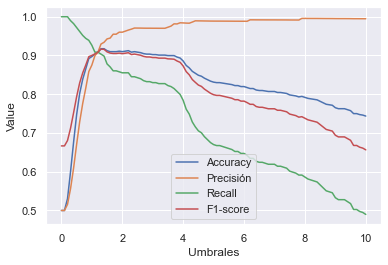

In [69]:
plt.plot(umbrales, accuracy, umbrales, precision, umbrales, recall, umbrales, f1)
plt.legend(["Accuracy", "Precisión", "Recall", "F1-score"])
plt.xlabel("Umbrales")
plt.ylabel("Value")

In [75]:
max_f1 = max(f1)
max_f1_index = f1.index(max_f1)
mejor_umbral = umbrales[max_f1_index]
print("Mejor umbral:", mejor_umbral)

Mejor umbral: 1.3


In [70]:
y_pred_val = (squared_errors > mejor_umbral).astype(int)

--------------------------------------------------------
Reporte para el modelo sobre datos de validación
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       394
           1       0.93      0.90      0.92       394

    accuracy                           0.92       788
   macro avg       0.92      0.92      0.92       788
weighted avg       0.92      0.92      0.92       788

--------------------------------------------------------


Text(54.260000000000005, 0.5, 'Etiquetas predichas')

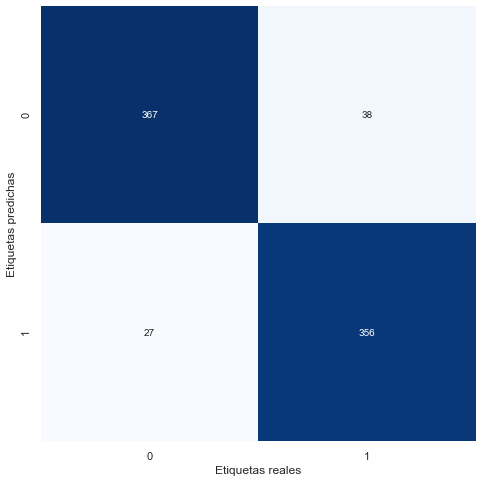

In [71]:
print('--------------------------------------------------------')
print('Reporte para el modelo sobre datos de validación')
print(classification_report(y_val, y_pred_val))
print('--------------------------------------------------------')
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_val.to_numpy(), y_pred_val)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')

In [52]:
squared_errors = []
for i in range(X_test.shape[0]):
    X_actual = X_test.iloc[i,:].to_frame().transpose()
    squared_errors.append(best_autoencoder['autoencoder'].model.evaluate(X_actual, X_actual, verbose=0))
squared_errors = np.array(squared_errors)
y_pred_test = (squared_errors > mejor_umbral).astype(int)

--------------------------------------------------------
Reporte para el modelo sobre datos de prueba
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     56864
           1       0.02      0.86      0.04        98

    accuracy                           0.93     56962
   macro avg       0.51      0.89      0.50     56962
weighted avg       1.00      0.93      0.96     56962

--------------------------------------------------------


Text(54.260000000000005, 0.5, 'Etiquetas predichas')

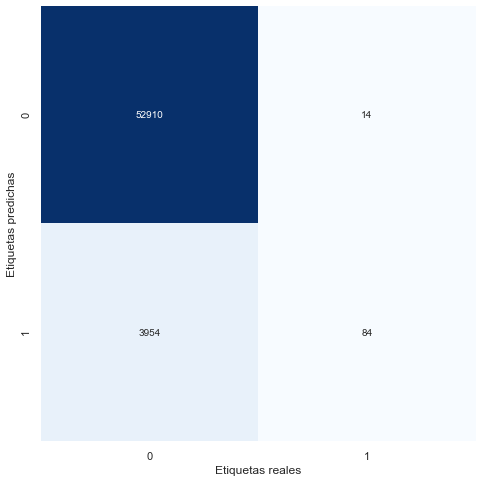

In [60]:
print('--------------------------------------------------------')
print('Reporte para el modelo sobre datos de prueba')
print(classification_report(y_test, y_pred_test))
print('--------------------------------------------------------')
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.to_numpy(), y_pred_test)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')